In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from pylab import rcParams
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.cluster import KMeans
from ggplot import *


/home/ramon/anaconda2/lib/python2.7/site-packages/ggplot/utils.py:81: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  pd.tslib.Timestamp,
/home/ramon/anaconda2/lib/python2.7/site-packages/ggplot/stats/smoothers.py:4: FutureWarning: The pandas.lib module is deprecated and will be removed in a future version. These are private functions and can be accessed from pandas._libs.lib instead
  from pandas.lib import Timestamp
/home/ramon/anaconda2/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
df_listing_high_renter = pd.read_csv('data/df_listing_high_renter.csv')

## Brightness and contrasts

In [3]:
df_contrasts_brightness =pd.read_csv('data/df_contrasts_brightness.csv')

df_contrasts_brightness=pd.merge(df_contrasts_brightness,df_listing_high_renter[['id','review_scores_rating','reviews_per_month','availability_90','price']],left_on='listing_id',right_on='id')

df_contrasts_brightness.corr()[['availability_90']]

,availability_90
listing_id,0.073245
R_contrast,0.018924
G_contrast,-0.001540
B_contrast,-0.031066
Brightness_mean,-0.018306
Brightness_std,-0.001834
id,0.073245
review_scores_rating,-0.125867
reviews_per_month,-0.023449
availability_90,1.000000


In [57]:
df = df_contrasts_brightness
cols = df.columns
df2 = pd.DataFrame([['---']*df.shape[1]], columns=cols)
df3 = pd.concat([df2, df])
df3.to_csv("table.md", sep="|", index=False)

In [49]:
def pandas_df_to_markdown_table(df):
    from IPython.display import Markdown, display
    fmt = ['---' for i in range(len(df.columns))]
    df_fmt = pd.DataFrame([fmt], columns=df.columns)
    df_formatted = pd.concat([df_fmt, df])
    display(Markdown(df_formatted.to_csv(sep="|", index=False)))

print pandas_df_to_markdown_table(df_contrasts_brightness)

listing_id|R_contrast|G_contrast|B_contrast|Brightness_mean|Brightness_std|id|review_scores_rating|reviews_per_month|availability_90|price
---|---|---|---|---|---|---|---|---|---|---
4725997|55|64|72|150|62|4725997|99.0|1.65|37|70
14159874|62|59|54|102|58|14159874|100.0|1.0|62|31
14195566|57|56|57|122|56|14195566|96.0|4.77|32|36
2751942|58|62|66|159|61|2751942|93.0|1.26|74|79
16948945|51|53|57|119|52|16948945|88.0|4.34|9|69
17844801|41|50|55|203|47|17844801|98.0|8.11|55|50
2323744|74|62|67|92|62|2323744|95.0|2.0|11|48
8163510|58|64|67|114|62|8163510|89.0|5.34|44|60
12728960|66|70|72|153|69|12728960|95.0|1.97|42|150
17432531|63|39|38|88|36|17432531|87.0|1.64|65|60
56960|60|65|64|146|63|56960|95.0|1.0|2|48
3964183|58|59|66|180|58|3964183|91.0|2.42|30|64
2590619|67|69|71|117|69|2590619|90.0|1.73|23|50
16377004|42|46|46|164|44|16377004|93.0|0.71|5|90
16348432|45|67|89|94|63|16348432|100.0|1.06|15|70
680999|65|67|70|171|67|680999|97.0|0.87|35|39
16269529|50|54|58|118|53|16269529|98.0|2.24|49|49
1448533|29|43|53|194|41|1448533|96.0|2.59|22|80
1541488|59|67|69|152|65|1541488|94.0|1.33|71|320
12062623|53|56|58|178|55|12062623|97.0|0.51|7|69
563505|47|51|55|176|50|563505|89.0|0.68|3|75
18056141|58|61|67|169|60|18056141|93.0|3.0|24|79
7245176|56|54|57|172|54|7245176|97.0|0.96|14|120
12047874|46|50|54|174|49|12047874|97.0|0.61|43|140
16410427|55|55|53|110|54|16410427|97.0|1.64|18|50
13188117|27|26|26|148|26|13188117|90.0|0.84|83|150
1205350|57|57|62|158|57|1205350|94.0|1.62|21|89
16174579|65|71|65|134|68|16174579|97.0|1.54|70|189
15335286|50|54|55|130|53|15335286|100.0|0.56|34|62
11684615|84|88|88|140|87|11684615|78.0|1.54|26|58
5410909|71|76|79|141|75|5410909|96.0|1.29|56|69
9721293|52|54|60|128|53|9721293|95.0|1.64|10|65
10647989|62|65|68|128|65|10647989|97.0|0.94|18|89
3256097|38|46|46|85|44|3256097|95.0|1.28|47|55
13926041|62|62|61|108|62|13926041|100.0|0.81|7|75
16011060|70|39|38|163|39|16011060|83.0|2.67|33|72
12121822|48|47|47|117|47|12121822|96.0|1.08|29|51
9152873|57|64|71|146|62|9152873|92.0|3.2|38|59
6501854|44|47|49|182|46|6501854|93.0|0.54|15|84
2390253|60|64|68|109|63|2390253|92.0|2.67|41|35
7196659|70|68|70|100|68|7196659|100.0|0.51|46|290
8031693|54|58|63|127|57|8031693|94.0|0.69|18|120
16696167|61|63|61|103|62|16696167|97.0|6.21|19|37
14104478|56|74|77|137|69|14104478|83.0|0.83|36|35
3872099|59|55|60|177|55|3872099|93.0|1.4|34|35
883847|54|52|53|176|52|883847|97.0|1.06|4|45
6465190|39|49|28|124|45|6465190|97.0|3.3|15|59
8700006|29|40|56|117|38|8700006|93.0|1.17|25|29
2294242|59|58|57|162|58|2294242|87.0|1.11|52|79
6163366|53|58|57|105|56|6163366|92.0|0.65|6|70
1159542|60|63|66|100|62|1159542|92.0|0.77|66|132
6454642|59|60|66|121|60|6454642|96.0|0.53|7|110
14985361|52|57|57|115|56|14985361|98.0|2.83|9|80
3762126|57|60|62|91|59|3762126|96.0|0.84|60|48
16237757|62|62|68|170|62|16237757|100.0|6.37|25|125
4746182|57|60|67|142|58|4746182|100.0|0.78|14|55
11446256|65|68|60|88|64|11446256|84.0|4.12|61|55
947362|62|69|72|138|68|947362|93.0|1.55|1|48
13482070|30|35|40|212|34|13482070|89.0|3.48|30|160
7677367|46|53|56|149|50|7677367|98.0|0.78|21|57
4182815|55|63|66|173|61|4182815|96.0|2.9|25|150
2087068|59|63|67|133|61|2087068|90.0|0.85|13|60
8462220|66|75|80|152|73|8462220|99.0|5.23|14|79
485726|61|68|72|154|65|485726|95.0|0.8|52|53
17292917|47|52|56|96|50|17292917|90.0|1.76|12|60
8963381|54|60|62|115|59|8963381|98.0|0.53|4|90
4791382|61|64|65|130|62|4791382|86.0|2.14|22|120
3626048|62|70|68|163|67|3626048|95.0|1.83|28|69
9103637|60|54|53|118|55|9103637|90.0|2.68|25|45
7828134|56|59|61|152|58|7828134|91.0|0.84|34|75
16920274|68|68|66|96|67|16920274|100.0|2.08|38|99
15152202|56|61|67|149|60|15152202|100.0|0.8|2|100
13248380|59|62|63|90|61|13248380|95.0|0.8|22|50
728981|63|74|88|174|71|728981|99.0|0.66|37|52
18066184|43|47|51|169|46|18066184|100.0|1.0|3|45
3030308|25|32|40|211|31|3030308|97.0|2.38|12|85
15309500|44|55|65|124|53|15309500|95.0|1.28|41|80
5093588|48|53|55|178|52|5093588|98.0|2.16|56|150
2063662|77|80|81|170|79|2063662|96.0|2.8|34|59
4643359|75|73|69|135|73|4643359|92.0|1.64|6|64
18025186|44|46|44|116|45|18025186|94.0|6.36|40|59
6540995|66|68|69|156|67|6540995|92.0|1.31|73|69
12916246|60|68|78|152|67|12916246|92.0|5.63|23|349
16265935|75|69|60|136|69|16265935|90.0|2.0|7|80
16802556|66|62|62|166|62|16802556|100.0|2.33|18|120
12088593|54|61|67|143|59|12088593|90.0|0.78|65|75
18001232|33|49|51|184|45|18001232|100.0|1.0|25|39
17413995|54|56|56|129|55|17413995|93.0|2.43|22|98
11977034|41|55|71|180|52|11977034|87.0|1.53|9|65
15969179|55|56|76|146|56|15969179|100.0|1.0|19|275
14171490|71|70|77|139|69|14171490|89.0|2.78|63|70
10750519|59|66|68|152|64|10750519|96.0|2.56|9|65
11530348|50|55|64|99|54|11530348|95.0|0.81|75|44
11538104|62|67|75|98|66|11538104|94.0|0.57|6|139
13179993|43|49|53|179|48|13179993|85.0|2.93|32|99
17010402|51|49|61|122|47|17010402|100.0|1.61|80|69
8904072|49|57|64|166|56|8904072|98.0|0.99|29|62
3607549|51|56|62|187|55|3607549|97.0|0.92|10|69
4027687|58|60|62|137|58|4027687|97.0|4.2|17|200
8063187|44|46|51|139|44|8063187|92.0|1.33|33|119
6790425|29|44|56|136|41|6790425|99.0|2.55|16|99
16200150|58|59|57|71|58|16200150|90.0|0.71|1|40
12017437|53|61|66|172|60|12017437|99.0|1.61|33|59
7314093|45|52|58|159|50|7314093|96.0|0.79|7|65
12488982|55|60|60|151|59|12488982|94.0|0.74|18|59
5161247|63|68|76|123|67|5161247|97.0|1.26|14|160
7891672|79|76|77|59|77|7891672|89.0|1.55|28|49
7080114|43|44|46|144|44|7080114|98.0|0.64|60|55
13499455|56|61|50|121|58|13499455|82.0|6.46|51|45
4577355|64|54|57|125|53|4577355|98.0|1.45|43|90
11861141|76|78|74|91|76|11861141|97.0|3.8|14|39
12290670|81|76|64|118|75|12290670|97.0|0.98|22|79
6251919|55|56|58|108|55|6251919|98.0|0.73|2|90
9036063|53|61|66|177|59|9036063|88.0|0.59|5|40
4834420|45|55|55|193|52|4834420|81.0|3.69|22|119
1532372|50|53|62|202|52|1532372|86.0|2.29|20|69
4282156|44|50|42|91|45|4282156|94.0|1.02|32|55
13373569|80|79|72|70|78|13373569|99.0|3.15|60|157
749134|69|68|67|170|68|749134|98.0|1.86|43|140
5804604|67|65|73|81|66|5804604|91.0|1.95|32|49
15528805|75|68|59|92|67|15528805|92.0|2.34|75|50
1645515|53|56|62|169|55|1645515|95.0|0.62|27|200
11818290|60|61|61|102|61|11818290|97.0|0.67|12|52
5991297|51|46|52|92|46|5991297|98.0|3.62|57|115
10065632|56|59|68|136|58|10065632|100.0|0.62|42|66
9242514|72|76|81|131|75|9242514|99.0|0.93|2|80
3693483|53|63|74|161|61|3693483|96.0|1.0|65|100
16343191|62|71|72|118|69|16343191|90.0|0.61|77|30
16434420|64|57|51|118|58|16434420|100.0|0.67|59|53
10003442|50|55|55|178|54|10003442|94.0|1.1|17|125
10537967|65|67|69|160|66|10537967|93.0|2.83|49|87
17688227|44|53|61|190|51|17688227|100.0|1.0|52|39
15305605|74|84|82|128|81|15305605|99.0|2.22|54|39
10673541|37|39|32|129|37|10673541|89.0|1.76|76|80
16591294|58|61|67|141|61|16591294|100.0|1.76|33|100
7590371|61|66|69|152|65|7590371|95.0|1.08|21|87
6800795|71|77|80|141|76|6800795|96.0|2.28|61|75
17522732|66|59|62|114|61|17522732|100.0|2.59|22|35
270477|45|55|64|113|53|270477|92.0|1.66|22|72
3213782|67|69|75|53|68|3213782|88.0|1.02|83|79
16049454|41|57|63|156|53|16049454|97.0|3.31|6|120
3213599|61|61|62|190|61|3213599|91.0|0.74|87|215
5782269|45|53|68|159|52|5782269|94.0|1.21|85|90
6114461|58|55|60|124|55|6114461|96.0|0.64|4|90
1427156|46|47|48|194|46|1427156|79.0|1.63|53|140
17260157|56|55|52|145|55|17260157|100.0|2.31|79|150
12360371|74|81|82|119|79|12360371|84.0|0.82|46|100
1052941|66|67|72|85|67|1052941|95.0|1.23|31|57
8108911|51|69|73|142|65|8108911|96.0|0.55|6|59
5417042|68|72|81|142|71|5417042|92.0|1.52|1|70
10115874|61|56|51|121|56|10115874|94.0|1.15|35|69
8028451|60|57|58|144|56|8028451|90.0|0.75|19|90
16656228|88|84|77|129|84|16656228|90.0|0.56|7|55
13091421|59|56|68|107|56|13091421|88.0|0.52|13|99
1624008|63|65|67|101|64|1624008|81.0|0.92|16|68
11290301|62|63|65|161|62|11290301|94.0|2.04|16|130
1017368|44|61|63|195|56|1017368|95.0|3.14|6|58
11565058|57|60|64|89|59|11565058|100.0|0.6|80|100
15809673|40|40|40|134|40|15809673|76.0|1.14|85|98
1574592|72|77|80|156|76|1574592|91.0|1.27|27|65
14668484|52|56|54|113|54|14668484|100.0|0.61|25|45
14392789|58|61|63|143|60|14392789|92.0|0.6|61|35
17383171|47|46|50|67|46|17383171|80.0|1.85|81|60
15951556|70|70|70|143|70|15951556|99.0|3.46|28|150
17316675|50|58|66|169|57|17316675|100.0|1.3|2|40
247604|37|43|48|170|42|247604|87.0|3.36|44|80
17598214|57|67|60|101|64|17598214|95.0|2.35|31|47
17134424|53|56|64|122|54|17134424|92.0|2.34|79|109
6232450|80|81|82|133|81|6232450|92.0|1.6|3|69
7357004|88|72|69|113|74|7357004|98.0|1.49|63|39
12226042|61|60|53|92|58|12226042|97.0|2.53|21|100
4290174|51|45|55|114|46|4290174|84.0|0.6|14|65
16322902|73|58|49|85|59|16322902|90.0|1.28|16|35
8495375|68|62|74|134|64|8495375|99.0|2.13|10|50
16066021|50|55|54|109|54|16066021|100.0|0.77|80|116
17990722|40|44|47|124|43|17990722|70.0|2.0|86|200
9806032|61|62|61|98|61|9806032|94.0|6.04|13|79
714312|59|60|63|115|60|714312|92.0|2.42|22|23
16941255|53|47|38|92|47|16941255|90.0|1.0|80|150
13581165|65|68|72|153|67|13581165|92.0|1.24|62|70
16298585|35|44|49|161|42|16298585|93.0|0.65|20|47
11579227|81|55|67|165|60|11579227|87.0|0.95|41|70
919931|41|43|49|186|42|919931|98.0|3.59|41|89
7016109|66|68|66|144|66|7016109|92.0|1.13|70|70
16314046|59|58|55|109|58|16314046|99.0|3.88|17|89
13588929|59|62|62|130|61|13588929|86.0|0.7|63|100
14882736|65|59|67|156|60|14882736|100.0|2.0|1|69
8870766|60|70|84|135|68|8870766|95.0|4.0|3|36
1829767|57|60|63|99|60|1829767|100.0|1.33|19|40
13666457|57|59|49|113|56|13666457|90.0|2.89|36|70
305987|41|41|44|113|40|305987|98.0|2.36|14|65
17429361|49|52|57|144|52|17429361|100.0|5.0|24|300
408756|50|48|47|108|48|408756|95.0|1.8|14|99
12053073|62|65|70|173|63|12053073|96.0|0.88|3|52
2133942|53|62|66|123|60|2133942|87.0|1.96|70|69
11578088|74|73|64|94|72|11578088|94.0|3.15|2|54
3955263|48|58|52|120|52|3955263|95.0|1.62|37|60
819658|47|50|55|161|49|819658|98.0|0.52|6|106
7570780|68|70|68|72|68|7570780|82.0|1.94|56|60
8216991|44|65|70|129|59|8216991|96.0|0.54|82|47
8648362|62|66|60|118|64|8648362|87.0|0.95|24|65
10516308|72|77|73|115|72|10516308|88.0|1.85|34|49
8957894|48|77|75|109|70|8957894|98.0|1.35|53|79
14117405|56|59|54|100|57|14117405|93.0|0.52|66|42
12923883|47|53|57|138|52|12923883|89.0|0.96|58|80
648747|59|57|63|191|57|648747|78.0|2.77|14|46
15985443|62|59|55|84|58|15985443|100.0|1.14|9|69
14818178|56|64|67|109|62|14818178|100.0|1.53|4|70
3366922|70|70|70|91|70|3366922|83.0|0.57|84|75
13760475|30|49|70|177|46|13760475|98.0|3.37|19|69
9472187|47|52|58|126|51|9472187|92.0|2.84|15|100
17281529|71|78|80|110|76|17281529|95.0|2.26|16|140
8161985|37|41|42|183|40|8161985|100.0|1.0|4|100
3070592|72|76|75|138|74|3070592|95.0|0.55|1|70
10897136|61|62|64|140|62|10897136|100.0|0.7|22|80
13491559|64|64|50|108|62|13491559|100.0|0.71|22|80
1159572|46|39|33|132|40|1159572|90.0|2.84|17|119
6737209|52|63|73|142|61|6737209|95.0|2.7|2|65
3541369|55|62|63|175|60|3541369|98.0|0.56|33|40
1115899|83|83|84|137|83|1115899|92.0|0.9|51|95
15597401|60|66|69|143|65|15597401|100.0|0.86|37|90
2369030|38|55|60|191|51|2369030|90.0|2.2|31|65
4342108|65|71|82|180|70|4342108|94.0|4.69|32|79
1010901|65|73|77|149|70|1010901|95.0|0.69|19|54
10766575|40|54|65|92|51|10766575|84.0|0.96|36|42
8023100|57|60|62|96|59|8023100|100.0|1.71|15|65
17164406|68|70|70|154|68|17164406|90.0|0.98|60|36
1947907|69|66|75|99|67|1947907|99.0|1.09|22|89
984052|65|71|73|161|69|984052|93.0|1.16|10|43
1501369|83|81|81|138|81|1501369|92.0|1.47|7|60
16250536|48|42|37|135|41|16250536|97.0|6.25|23|125
504259|60|70|72|180|68|504259|99.0|1.64|25|199
11496768|62|66|72|162|65|11496768|93.0|1.01|52|52
4508183|63|65|66|170|65|4508183|96.0|3.51|3|90
2691139|54|39|23|86|40|2691139|85.0|2.79|46|55
1214669|57|61|64|145|60|1214669|96.0|1.41|38|110
16752243|50|51|51|158|50|16752243|100.0|1.05|3|80
10614828|55|56|54|63|56|10614828|100.0|0.71|39|60
8629739|61|61|62|70|61|8629739|100.0|0.68|27|35
16584814|50|53|63|115|52|16584814|95.0|4.09|34|30
17411493|68|66|68|144|66|17411493|96.0|4.35|24|87
5035001|65|67|69|105|66|5035001|88.0|0.72|83|49
12149240|60|64|63|144|62|12149240|100.0|0.61|78|180
10349374|51|52|61|175|52|10349374|94.0|0.64|6|68
1326589|50|63|61|99|58|1326589|99.0|0.87|9|69
17263004|69|70|72|158|69|17263004|80.0|1.02|19|135
4655907|65|78|79|111|74|4655907|93.0|1.31|31|60
14948326|66|56|64|105|59|14948326|96.0|0.86|30|110
3663627|50|50|50|117|49|3663627|93.0|0.77|11|35
11238980|49|54|60|135|53|11238980|89.0|5.17|8|70
5151045|49|61|66|158|58|5151045|100.0|0.98|1|70
9268629|61|60|63|94|60|9268629|97.0|5.84|12|359
10017363|49|41|36|63|42|10017363|94.0|2.98|54|140
17803859|55|64|83|89|63|17803859|93.0|6.0|31|186
9289390|45|47|50|114|46|9289390|97.0|0.98|14|80
17923311|39|51|60|186|49|17923311|90.0|2.0|72|155
16468199|55|58|61|145|58|16468199|96.0|1.18|8|79
11101259|68|68|66|98|67|11101259|93.0|1.21|12|70
16445876|66|51|74|100|49|16445876|96.0|1.18|11|100
322520|52|56|60|193|55|322520|89.0|2.49|48|54
5335113|58|59|63|110|59|5335113|98.0|1.95|13|90
12044871|54|54|62|186|54|12044871|97.0|3.31|46|133
203634|78|71|72|126|72|203634|98.0|1.22|10|125
15391381|53|50|47|86|51|15391381|88.0|3.33|57|59
2191449|66|71|74|150|70|2191449|91.0|1.52|22|64
698727|76|75|82|156|75|698727|98.0|0.64|16|100
16868949|49|50|50|147|50|16868949|100.0|0.87|39|35
10958382|64|58|55|177|58|10958382|97.0|2.0|13|119
13904924|66|66|65|125|66|13904924|40.0|0.51|84|80
15742949|75|73|72|137|73|15742949|100.0|1.11|66|60
1915904|49|52|53|122|51|1915904|98.0|1.07|5|107
60754|48|50|50|103|50|60754|90.0|1.76|55|175
17941904|66|66|67|141|65|17941904|100.0|1.0|1|110
2504590|54|71|68|170|65|2504590|87.0|1.01|1|35
14034317|43|42|41|88|42|14034317|92.0|3.27|53|90
2650663|38|37|101|178|40|2650663|99.0|2.48|35|99
8592355|51|52|54|132|52|8592355|98.0|1.35|3|57
16517367|52|59|65|143|58|16517367|88.0|3.42|18|60
4335533|34|37|47|137|37|4335533|94.0|5.85|5|100
12081066|50|49|53|129|50|12081066|90.0|0.67|4|74
15787880|62|62|68|90|62|15787880|94.0|1.99|56|42
3717751|82|74|73|164|75|3717751|97.0|5.78|13|49
2623509|62|65|66|118|65|2623509|94.0|0.91|30|55
8787879|47|48|51|94|47|8787879|95.0|1.25|4|69
5418027|61|69|77|178|67|5418027|97.0|3.18|7|56
17451910|56|63|63|115|61|17451910|100.0|0.92|6|45
4889706|39|41|45|165|41|4889706|95.0|1.09|14|150
15941034|64|63|67|157|63|15941034|99.0|5.83|12|65
642955|40|56|70|170|53|642955|98.0|0.66|5|70
9037782|49|51|51|135|50|9037782|88.0|1.19|45|88
14327015|52|57|65|126|55|14327015|98.0|1.36|20|241
4207224|68|74|77|154|73|4207224|95.0|1.52|3|75
12141033|66|67|66|97|66|12141033|95.0|0.61|3|50
8300443|44|54|60|145|52|8300443|98.0|3.19|2|89
15494789|82|80|74|98|80|15494789|100.0|0.92|8|75
1814192|76|74|72|125|73|1814192|91.0|1.37|31|75
15093851|59|57|57|186|57|15093851|95.0|0.57|48|150
7878281|68|74|74|115|71|7878281|99.0|0.69|6|95
16278788|31|35|42|117|34|16278788|98.0|1.71|9|45
1867060|60|64|68|172|63|1867060|95.0|2.98|22|59
6295492|70|80|93|128|77|6295492|95.0|1.29|22|85
17859738|47|52|65|66|51|17859738|100.0|1.0|5|85
17605791|56|64|67|75|62|17605791|100.0|1.0|14|89
16305782|58|59|57|75|58|16305782|99.0|4.85|27|45
10053291|56|56|55|109|56|10053291|87.0|1.4|14|50
17969678|66|57|48|84|58|17969678|100.0|1.0|38|100
12099471|31|38|44|179|36|12099471|91.0|7.32|32|118
1307230|56|58|63|120|58|1307230|97.0|0.57|5|50
5237611|58|58|69|171|58|5237611|94.0|1.45|11|40
4420593|54|58|54|105|56|4420593|97.0|2.21|16|58
17008663|42|56|66|110|54|17008663|100.0|1.09|6|37
16965957|75|75|75|124|75|16965957|90.0|0.91|10|60
7299266|54|61|65|136|59|7299266|100.0|0.51|26|80
5065008|36|49|68|151|46|5065008|95.0|1.2|17|59
5391267|67|62|61|54|62|5391267|95.0|0.78|39|50
3928417|62|69|78|127|67|3928417|98.0|4.06|27|78
11486971|66|67|70|171|66|11486971|97.0|8.45|11|75
14649359|77|79|77|108|78|14649359|87.0|6.48|30|45
5216220|68|71|74|162|70|5216220|93.0|1.05|23|65
12117451|41|47|50|137|45|12117451|95.0|3.36|26|69
685944|55|53|54|133|53|685944|94.0|1.78|20|125
9893925|57|65|62|104|62|9893925|97.0|0.74|66|47
3306282|45|62|72|147|57|3306282|94.0|1.52|54|70
3930252|66|64|60|101|63|3930252|91.0|1.27|44|69
5147366|60|59|61|112|59|5147366|97.0|1.92|9|65
16079041|47|51|56|180|50|16079041|100.0|2.2|35|120
15698076|25|18|13|36|19|15698076|93.0|1.89|25|48
17824393|51|58|69|204|57|17824393|100.0|2.0|7|80
9010083|42|34|29|65|35|9010083|95.0|2.22|33|79
5073905|64|65|64|149|64|5073905|90.0|1.86|32|39
16641673|40|46|49|116|44|16641673|93.0|1.12|6|46
4416664|31|24|17|38|25|4416664|100.0|0.87|15|54
13698166|56|54|51|81|54|13698166|100.0|0.65|15|48
1777194|40|61|59|131|54|1777194|92.0|0.93|25|55
15979394|51|62|73|166|60|15979394|100.0|1.33|41|130
6826789|78|76|73|114|76|6826789|93.0|1.96|23|55
16249242|36|45|50|103|43|16249242|100.0|0.92|25|70
15750470|55|53|67|185|54|15750470|100.0|0.52|54|399
323260|59|57|54|125|57|323260|88.0|2.24|9|33
1863324|63|53|57|140|55|1863324|98.0|2.11|20|56
12708673|63|66|68|133|65|12708673|94.0|2.74|16|85
936642|59|62|66|188|61|936642|98.0|1.01|22|55
14838026|44|64|72|164|59|14838026|95.0|2.78|18|50
9027179|59|53|45|121|52|9027179|91.0|4.48|17|46
598407|45|50|53|154|48|598407|96.0|0.88|3|90
13090345|48|58|47|118|53|13090345|94.0|1.89|31|43
15248889|60|49|42|110|50|15248889|95.0|0.57|40|86
4581049|38|42|47|102|41|4581049|98.0|8.06|25|49
4424040|51|50|49|120|50|4424040|91.0|1.61|20|30
822091|64|70|70|126|68|822091|94.0|1.7|10|64
14663108|54|59|67|113|58|14663108|98.0|1.1|55|74
6464314|54|52|55|161|52|6464314|88.0|0.76|26|75
17708438|55|59|58|105|57|17708438|20.0|1.0|8|75
17410761|53|58|59|157|56|17410761|100.0|2.94|3|25
2649669|45|54|63|134|53|2649669|92.0|1.94|15|70
1312007|42|52|56|88|50|1312007|92.0|0.95|4|60
10490773|66|68|66|118|67|10490773|96.0|2.71|11|50
171746|69|71|77|124|69|171746|91.0|1.32|57|70
12979924|37|51|63|167|48|12979924|98.0|0.89|5|66
16787135|57|70|83|194|68|16787135|95.0|1.36|31|64
1969138|32|35|41|222|34|1969138|98.0|1.36|15|76
2784176|63|62|72|118|63|2784176|92.0|0.62|8|29
16646779|35|33|35|107|33|16646779|80.0|1.93|32|45
3948713|85|93|103|172|91|3948713|95.0|2.19|8|53
14857798|60|60|65|174|60|14857798|97.0|6.57|19|85
17454284|63|69|78|141|68|17454284|100.0|0.51|26|60
1213406|51|56|57|103|54|1213406|80.0|0.67|11|57
3668964|60|68|69|147|66|3668964|96.0|0.81|7|85
16091735|55|55|67|167|54|16091735|98.0|2.58|22|165
884293|41|48|59|170|46|884293|95.0|2.01|16|85
12818873|48|48|49|136|48|12818873|86.0|2.87|53|75
13303590|66|66|62|104|65|13303590|97.0|2.39|12|33
13868134|65|63|60|120|62|13868134|98.0|4.18|25|359
8396454|59|60|57|97|60|8396454|95.0|1.99|16|118
14720797|68|73|71|132|71|14720797|91.0|1.55|82|110
6666381|55|57|57|154|56|6666381|98.0|2.52|59|64
10691423|54|58|62|150|57|10691423|96.0|2.99|12|90
15677345|61|61|64|158|61|15677345|98.0|1.72|68|75
9287838|48|77|75|109|70|9287838|95.0|1.56|46|325
15711433|55|58|62|118|57|15711433|97.0|3.73|10|59
862555|63|67|68|85|66|862555|94.0|2.19|35|55
143605|32|39|45|179|37|143605|91.0|0.65|41|60
477515|65|67|67|169|66|477515|95.0|1.45|56|119
17649402|51|49|46|118|49|17649402|93.0|4.09|31|49
11833825|55|59|57|120|57|11833825|100.0|4.53|39|95
9747869|57|74|75|154|69|9747869|91.0|5.49|34|45
136243|89|84|75|134|84|136243|88.0|1.14|37|72
16446691|58|62|57|146|60|16446691|100.0|0.77|7|55
13419646|30|31|40|148|31|13419646|91.0|1.91|48|79
730323|54|72|70|164|66|730323|90.0|1.86|9|32
15243865|59|67|70|142|65|15243865|100.0|0.65|71|50
7656993|51|40|46|70|42|7656993|97.0|2.55|36|30
16882223|60|66|70|114|65|16882223|100.0|0.71|35|75
16317026|28|27|30|145|27|16317026|100.0|2.14|56|59
14364966|63|60|55|128|60|14364966|90.0|0.74|50|37
17420461|49|47|46|128|47|17420461|85.0|9.57|5|37
15387448|75|79|81|143|78|15387448|100.0|1.39|47|55
8822071|43|56|69|174|54|8822071|90.0|3.39|15|99
237372|35|44|55|204|42|237372|94.0|2.07|13|72
6564334|54|65|73|187|63|6564334|96.0|0.52|7|99
11467819|73|70|65|93|68|11467819|83.0|2.66|70|62
16865591|65|64|64|147|64|16865591|90.0|0.83|52|55
8127247|51|56|61|147|54|8127247|97.0|3.6|23|120
218127|68|73|76|158|72|218127|90.0|1.1|17|80
11307029|57|63|66|139|61|11307029|83.0|1.3|34|89
14794445|58|53|50|78|54|14794445|97.0|1.01|48|31
117649|48|76|73|142|68|117649|94.0|1.15|9|68
14197398|61|59|59|112|59|14197398|93.0|0.85|83|65
1379902|68|69|63|122|67|1379902|96.0|3.12|5|65
17314685|49|48|45|88|48|17314685|100.0|1.0|17|70
1135006|66|66|72|111|65|1135006|97.0|3.05|12|63
1865461|60|66|73|177|65|1865461|94.0|0.71|42|59
3215880|53|54|53|130|53|3215880|93.0|0.57|63|80
7343211|50|58|55|97|56|7343211|92.0|0.79|11|90
1548045|58|55|57|121|55|1548045|90.0|2.0|27|125
10164279|38|41|54|111|41|10164279|89.0|1.45|40|44
6172864|44|60|75|169|56|6172864|100.0|1.15|29|118
3904895|55|58|70|173|57|3904895|96.0|4.5|18|53
15391163|54|63|61|129|61|15391163|100.0|0.59|85|30
3108257|45|60|60|112|55|3108257|98.0|1.71|1|50
11772098|73|77|93|114|76|11772098|95.0|2.56|27|90
15778822|59|67|67|178|64|15778822|93.0|0.83|64|40
68448|72|81|82|150|78|68448|90.0|1.97|50|54
633116|34|49|59|194|45|633116|96.0|1.06|75|105
281103|53|70|94|160|67|281103|96.0|1.15|3|70
15078240|51|62|66|154|59|15078240|87.0|1.27|31|38
14323398|46|58|70|147|56|14323398||0.54|24|50
9002117|57|54|58|161|54|9002117|98.0|0.55|1|87
2485985|45|42|52|188|41|2485985|93.0|0.63|29|54
16792028|80|80|79|121|79|16792028|95.0|1.72|79|85
1871203|46|54|63|155|52|1871203|93.0|1.12|66|98
1314001|49|56|64|168|55|1314001|88.0|0.52|14|90
5366328|59|51|46|46|51|5366328|91.0|1.35|1|95
981612|42|36|43|182|37|981612|92.0|0.87|17|150
13893621|50|49|50|167|49|13893621|99.0|4.3|59|150
15203847|48|50|53|187|50|15203847|95.0|0.59|15|100
15060796|50|56|49|110|51|15060796|95.0|2.32|9|69
2349109|57|65|69|137|61|2349109|98.0|1.13|34|120
1273930|39|43|59|180|42|1273930|92.0|0.77|15|102
16539421|65|55|54|104|56|16539421|80.0|1.09|47|50
7634603|61|63|68|156|62|7634603|98.0|2.03|73|120
9730156|82|89|87|105|86|9730156|85.0|0.76|56|89
8270239|56|51|46|143|50|8270239|98.0|0.55|15|50
4050068|72|71|72|165|71|4050068|89.0|0.7|17|85
14702251|43|51|56|153|50|14702251|97.0|1.6|2|70
17913499|51|53|22|141|50|17913499|100.0|2.0|77|50
4349609|70|74|80|176|73|4349609|90.0|2.08|50|50
7495407|60|53|48|163|53|7495407|92.0|1.33|44|220
7133001|54|63|68|145|60|7133001|95.0|1.73|2|110
772854|64|65|65|109|65|772854|86.0|0.86|21|95
3314419|54|51|54|112|51|3314419|95.0|2.32|70|30
7645157|49|58|71|195|56|7645157|88.0|0.61|8|47
15265341|71|77|76|139|76|15265341|96.0|2.13|6|40
1745835|65|61|58|163|61|1745835|90.0|1.08|33|40
16093849|46|56|60|130|53|16093849|98.0|3.92|15|58
469080|58|65|70|157|63|469080|96.0|1.84|5|72
14397824|56|56|57|97|56|14397824|97.0|0.74|77|50
1204897|64|67|68|133|66|1204897|94.0|1.17|11|54
363454|64|67|71|158|67|363454|97.0|1.8|18|82
16268853|59|60|67|167|60|16268853|93.0|0.69|54|159
16865367|50|51|54|140|51|16865367|100.0|4.0|42|69
355494|44|44|45|197|44|355494|87.0|1.58|26|48
13654880|42|51|63|172|48|13654880|87.0|3.24|33|205
17704043|56|63|68|134|62|17704043|97.0|4.09|63|43
2954753|42|54|63|127|51|2954753|95.0|1.13|11|125
6371816|52|53|56|168|53|6371816|85.0|0.57|17|70
13669087|61|68|74|161|66|13669087|84.0|2.39|27|90
16410533|60|55|63|139|55|16410533|85.0|4.16|80|200
15389872|58|58|77|161|58|15389872|93.0|0.88|63|55
7918098|61|60|60|80|60|7918098|93.0|2.54|38|57
14275387|60|66|70|125|65|14275387|89.0|0.86|10|35
10850427|57|69|73|124|66|10850427|95.0|3.8|31|94
11855425|69|68|70|160|68|11855425|93.0|1.41|82|140
15995604|76|85|88|123|83|15995604|100.0|0.71|62|75
5771841|62|62|63|151|62|5771841|94.0|7.0|31|65
16821096|66|62|67|138|61|16821096|100.0|2.12|54|138
2201228|34|46|56|206|44|2201228|86.0|1.19|43|59
8432133|70|71|71|171|71|8432133|96.0|3.57|30|69
6942811|74|73|91|137|75|6942811|93.0|0.81|4|105
17154280|61|66|72|113|65|17154280|100.0|0.83|1|80
16423789|53|61|61|143|58|16423789|80.0|1.15|41|40
9291466|46|57|63|166|55|9291466|98.0|3.13|20|102
18000238|43|48|53|185|47|18000238|100.0|1.0|32|89
15198842|73|72|73|180|72|15198842|96.0|2.26|60|40
11577306|44|53|60|166|51|11577306|95.0|3.99|18|90
16153479|40|47|51|160|43|16153479|80.0|1.64|45|45
3988752|45|46|46|142|45|3988752|99.0|4.29|46|60
18012464|58|63|66|110|62|18012464|100.0|5.0|23|55
10941636|58|63|80|136|59|10941636|92.0|2.53|4|50
3004570|51|60|68|186|58|3004570|92.0|3.33|37|40
14839238|48|55|67|180|53|14839238|95.0|2.68|58|70
4996809|53|54|51|87|52|4996809|97.0|1.89|69|69
15894038|55|52|53|102|52|15894038|100.0|1.0|52|89
321295|55|64|70|191|62|321295|93.0|1.55|22|39
9364975|69|57|54|128|58|9364975|92.0|0.97|43|100
16570701|60|59|58|131|59|16570701|85.0|1.05|11|60
15868988|74|68|80|147|70|15868988|96.0|3.31|8|65
2690161|52|57|60|164|56|2690161|94.0|2.17|25|58
14596800|73|80|88|105|78|14596800|96.0|3.5|7|45
16461661|53|58|57|162|56|16461661|98.0|3.03|36|132
15712188|56|52|52|102|52|15712188|95.0|0.73|45|40
15012505|52|57|62|126|55|15012505|100.0|0.59|31|158
12504103|32|33|33|204|32|12504103|99.0|1.27|41|260
13646577|54|56|57|106|56|13646577|90.0|2.05|39|59
1099815|52|55|48|122|53|1099815|97.0|2.01|7|109
17004546|52|57|68|195|55|17004546|83.0|3.0|26|75
14316647|70|72|75|122|71|14316647|100.0|1.31|3|95
6563600|33|39|51|180|38|6563600|81.0|2.67|9|100
4448981|59|66|72|176|64|4448981|89.0|2.14|27|170
8026172|64|68|71|144|66|8026172|95.0|3.67|12|60
14048002|56|64|64|87|62|14048002|94.0|1.88|4|70
17773917|68|70|71|127|69|17773917|80.0|2.43|2|60
17279517|54|63|66|115|61|17279517|100.0|2.63|76|35
3823118|64|66|68|105|65|3823118|91.0|2.24|2|55
10063678|58|68|70|103|65|10063678|98.0|2.01|14|49
613219|66|70|63|119|68|613219|91.0|2.24|66|37
2662541|39|46|43|128|42|2662541|91.0|2.44|4|89
12838131|57|53|55|122|53|12838131|92.0|0.93|30|62
13086676|59|54|46|88|54|13086676|91.0|0.77|43|110
6067660|61|64|66|143|63|6067660|91.0|0.69|8|68
15075590|32|37|47|156|37|15075590|83.0|1.15|3|46
14823661|52|44|33|124|45|14823661|95.0|5.95|38|49
11831821|43|47|44|182|44|11831821|90.0|3.12|30|45
249419|69|65|68|155|65|249419|97.0|1.69|44|95
2766544|54|43|47|111|44|2766544|91.0|1.1|58|167
11599607|66|67|86|187|66|11599607|80.0|3.53|21|73
4876801|35|34|34|120|33|4876801|98.0|0.7|42|120
2742389|25|35|51|206|33|2742389|87.0|0.63|4|100
17119592|64|64|64|83|64|17119592|96.0|3.05|19|150
4156627|55|63|72|179|61|4156627|85.0|1.22|39|50
11684079|59|61|65|122|60|11684079|84.0|3.62|45|90
3555995|63|78|68|149|70|3555995|91.0|1.05|45|36
17734719|48|49|59|102|47|17734719|95.0|4.0|22|66
1177924|68|67|64|96|67|1177924|96.0|2.09|23|130
11983078|26|38|49|152|36|11983078|99.0|1.28|16|76
2812614|67|65|69|138|65|2812614|89.0|2.41|7|45
11593709|61|80|79|138|72|11593709|90.0|1.19|84|49
322463|55|67|68|175|64|322463|88.0|2.89|35|54
81081|69|71|78|161|70|81081|98.0|2.11|24|66
14175176|46|58|61|110|55|14175176|84.0|0.98|6|40
16944215|28|29|27|168|28|16944215|87.0|4.83|46|55
7695587|76|74|72|145|74|7695587|90.0|2.35|48|95
10327989|53|56|60|170|56|10327989|95.0|0.82|39|49
8296389|62|55|63|146|54|8296389|84.0|1.08|23|70
306829|48|49|47|110|48|306829|94.0|0.59|17|38
18052879|43|57|65|141|54|18052879|100.0|1.0|60|58
876984|81|86|85|109|84|876984|98.0|4.75|26|89
16752912|66|66|70|169|65|16752912|97.0|2.47|55|69
8039497|46|59|69|160|56|8039497|95.0|2.08|51|59
6802462|84|79|72|125|79|6802462|93.0|2.48|66|79
4215596|53|59|63|181|57|4215596|97.0|0.66|6|120
681132|51|62|61|122|58|681132|82.0|0.71|13|44
9224827|60|64|64|109|63|9224827|95.0|0.84|6|70
799899|48|53|56|174|51|799899|92.0|2.11|22|39
12103546|72|75|79|138|74|12103546|84.0|0.72|67|100
13145940|61|62|59|124|61|13145940|100.0|2.04|24|75
17376259|73|80|83|127|78|17376259|100.0|1.62|3|80
15986114|75|68|55|118|68|15986114|91.0|1.96|73|58
4974718|32|42|50|171|40|4974718|93.0|1.51|81|68
8624195|50|50|48|103|49|8624195|78.0|3.62|59|51
15995479|49|59|78|157|57|15995479|90.0|1.47|14|50
11306475|45|46|50|173|46|11306475|91.0|2.16|14|95
13698179|64|61|60|103|61|13698179|100.0|0.64|80|75
10169413|57|55|55|129|55|10169413|97.0|3.46|26|79
6834476|45|44|48|89|42|6834476|97.0|1.69|73|50
11968911|61|63|66|157|63|11968911|95.0|1.23|31|35
493539|32|39|46|192|37|493539|94.0|4.41|70|125
3738765|65|70|71|106|69|3738765|96.0|0.55|38|75
17603581|82|76|74|97|77|17603581|88.0|3.0|4|44
15801558|53|56|58|102|55|15801558|100.0|1.76|14|64
594027|58|56|69|168|57|594027|85.0|1.88|27|160
1329495|48|58|64|173|56|1329495|93.0|0.65|16|99
17250526|67|73|79|170|72|17250526|100.0|1.2|19|45
15860972|86|84|83|118|84|15860972|96.0|3.04|9|60
1867179|53|58|77|187|57|1867179|95.0|2.18|8|90
4106583|50|61|58|148|57|4106583|91.0|5.15|55|40
6368084|70|69|66|111|69|6368084|97.0|1.26|66|100
1328436|29|45|56|178|41|1328436|92.0|2.28|10|63
235766|49|59|69|197|57|235766|94.0|0.68|39|40
16972506|39|54|50|133|50|16972506|97.0|2.02|19|37
15251608|56|52|40|85|51|15251608|91.0|1.0|73|48
11579707|58|67|69|118|64|11579707|82.0|1.41|78|69
1521956|75|75|78|129|75|1521956|97.0|1.18|10|80
18046453|43|45|47|108|45|18046453|100.0|2.0|26|50
12347934|68|68|69|151|68|12347934|100.0|2.0|17|98
6207145|37|36|43|134|36|6207145|97.0|1.35|6|64
12840778|81|79|80|102|79|12840778|89.0|2.02|19|85
7742546|68|65|62|86|64|7742546|92.0|1.1|11|200
935026|49|31|36|106|32|935026|97.0|4.5|9|89
12601589|64|67|69|110|66|12601589|90.0|3.62|6|39
715519|64|70|77|153|69|715519|94.0|2.38|29|47
16992387|52|52|56|153|51|16992387|80.0|0.81|6|55
17951417|51|46|58|178|45|17951417|100.0|1.0|26|79
6818021|54|57|61|91|56|6818021|97.0|3.07|9|138
11580064|55|55|56|158|55|11580064|84.0|1.12|36|110
8215915|44|51|56|172|49|8215915|93.0|2.76|5|45
3489087|72|71|62|134|70|3489087|95.0|1.81|46|430
10086331|67|71|71|140|70|10086331|96.0|0.98|1|99
4844511|54|59|73|161|57|4844511|94.0|0.75|4|34
1421274|59|61|57|116|60|1421274|95.0|1.48|17|75
17612339|17|52|51|187|42|17612339|97.0|4.2|12|45
9915929|77|80|79|153|79|9915929|93.0|3.07|77|100
243063|55|59|63|130|58|243063|89.0|1.79|11|130
14933760|53|55|56|140|54|14933760|92.0|1.26|19|30
1290486|51|59|65|120|57|1290486|95.0|0.85|22|105
16268992|56|59|60|164|58|16268992|100.0|1.42|69|120
4759102|55|54|55|179|54|4759102|96.0|4.81|51|120
16299075|66|67|73|137|66|16299075|80.0|1.0|25|80
11005103|42|46|42|108|45|11005103|100.0|1.53|60|35
10423394|69|70|70|105|69|10423394|99.0|2.97|31|120
7374975|60|62|63|142|61|7374975|98.0|1.52|1|65
14599188|48|48|46|116|47|14599188|97.0|1.82|11|45
9011482|62|60|61|133|59|9011482|93.0|2.97|37|49
11373630|54|42|38|79|43|11373630|89.0|3.63|77|120
17941804|39|47|48|122|45|17941804|90.0|3.66|3|45
17084594|49|47|47|98|47|17084594|100.0|1.0|74|140
18034327|70|70|68|115|69|18034327|90.0|2.65|38|50
6139370|53|55|59|150|54|6139370|96.0|6.0|62|45
1176655|43|49|52|171|47|1176655|93.0|1.53|27|98
2021588|43|45|44|108|44|2021588|86.0|1.99|25|63
9744745|63|71|77|156|69|9744745|96.0|2.08|79|199
10351486|81|53|55|112|54|10351486|100.0|0.67|70|49
2987677|48|54|59|198|53|2987677|83.0|1.24|57|169
13582166|27|35|42|195|32|13582166|90.0|3.31|38|210
8746813|53|44|39|89|45|8746813|96.0|1.88|3|50
5544276|67|64|57|142|64|5544276|94.0|1.29|51|50
4328059|54|59|61|134|58|4328059|90.0|0.91|6|68
107968|59|60|61|118|60|107968|98.0|0.75|14|70
7489785|52|51|52|112|51|7489785|96.0|0.56|9|90
7448287|32|33|34|208|33|7448287|91.0|1.04|55|70
257766|46|49|54|186|48|257766|99.0|0.86|35|194
15557263|59|63|67|189|62|15557263|97.0|5.77|16|60
11576928|57|59|64|69|59|11576928|89.0|1.99|9|66
709602|56|68|76|173|65|709602|90.0|0.57|1|59
6231989|48|59|62|102|56|6231989|95.0|2.99|8|104
10094856|36|39|40|156|38|10094856|93.0|0.86|23|88
11241690|41|47|55|125|45|11241690|91.0|2.69|41|95
6253084|51|59|69|120|57|6253084|91.0|0.91|5|95
1086561|61|59|61|162|59|1086561|95.0|0.63|3|36
3419380|52|59|62|158|57|3419380|100.0|0.67|17|131
16790749|28|34|37|139|32|16790749|89.0|2.36|83|60
3665716|71|77|77|153|75|3665716|92.0|0.67|79|40
15035796|56|63|63|138|61|15035796|97.0|1.07|5|57
12001920|50|53|55|87|52|12001920|94.0|3.37|6|48
17858734|49|49|52|119|49|17858734|100.0|3.0|1|100
16810514|59|59|58|110|58|16810514|80.0|0.9|53|352
7838754|57|62|68|112|59|7838754|94.0|2.21|26|105
3546624|53|55|58|101|54|3546624|91.0|0.89|77|40
16237052|43|48|55|163|47|16237052|96.0|6.04|7|70
16462941|64|83|84|149|79|16462941|93.0|0.9|20|45
1268657|43|44|44|118|43|1268657|97.0|1.69|46|100
13483765|52|60|63|185|58|13483765|88.0|1.28|43|60
10746802|56|52|54|115|51|10746802|98.0|0.78|37|70
7876382|60|58|61|125|58|7876382|95.0|3.02|7|69
13306131|76|84|82|114|82|13306131|94.0|3.29|13|140
15263465|57|65|68|110|63|15263465|96.0|2.05|68|35
3187735|64|67|66|160|66|3187735|96.0|6.14|10|58
12526005|46|52|52|194|50|12526005|85.0|1.0|51|240
8375434|51|52|53|173|52|8375434|99.0|2.32|37|270
11795156|47|53|59|135|52|11795156|98.0|0.81|1|55
3686153|39|47|55|176|44|3686153|94.0|0.54|20|75
2647478|66|72|70|120|70|2647478|95.0|1.59|77|90
4206755|51|60|65|187|57|4206755|97.0|0.8|3|95
15528379|68|80|87|195|78|15528379|91.0|2.59|40|209
17002104|44|50|54|144|49|17002104|80.0|0.83|3|45
17103649|64|59|61|91|59|17103649|84.0|1.74|46|65
4813944|71|74|78|147|74|4813944|98.0|1.33|17|105
663130|67|71|82|172|70|663130|90.0|1.04|19|151
10225181|51|47|50|102|47|10225181|96.0|1.8|48|89
3738353|54|56|66|123|55|3738353|88.0|1.05|27|78
9265175|60|55|48|72|55|9265175|94.0|1.27|8|41
7130797|47|51|55|169|50|7130797|95.0|0.75|19|59
15242320|53|55|56|121|54|15242320|90.0|1.37|7|45
7889458|67|73|76|156|72|7889458|98.0|1.67|14|98
16010259|62|55|54|138|56|16010259|95.0|2.14|18|80
4224928|59|61|68|141|61|4224928|87.0|0.52|7|85
6488571|50|54|59|169|53|6488571|91.0|6.49|41|79
1362184|69|70|70|79|70|1362184|96.0|1.4|57|48
255912|70|68|70|123|68|255912|79.0|0.62|22|50
494884|72|82|76|158|78|494884|88.0|0.66|75|200
16887059|40|47|50|138|46|16887059|100.0|0.73|14|48
2363643|56|52|38|100|50|2363643|94.0|1.62|7|80
16867014|41|61|79|134|57|16867014|90.0|3.53|69|95
10172179|48|57|66|174|55|10172179|76.0|1.31|23|55
425411|58|62|68|182|61|425411|95.0|2.86|11|70
6486128|44|56|71|182|53|6486128|92.0|5.96|75|79
1259092|52|55|57|136|54|1259092|99.0|0.7|4|50
4110390|42|48|53|205|47|4110390|98.0|1.52|70|129
17786473|90|79|66|117|80|17786473|100.0|1.0|68|250
2548961|32|39|46|94|38|2548961|86.0|2.31|23|65
1153249|58|66|71|120|64|1153249|97.0|1.33|2|55
10080482|49|61|61|109|55|10080482|88.0|0.76|21|55
10029380|62|67|67|107|65|10029380|96.0|1.04|34|91
5380815|58|67|72|140|64|5380815|99.0|0.63|8|48
18075198|48|52|55|147|51|18075198|100.0|3.0|54|190
9836101|66|72|71|144|70|9836101|91.0|1.17|84|129
13394132|65|66|65|121|65|13394132|91.0|0.89|37|15
3475556|40|51|58|176|49|3475556|92.0|0.92|76|411
11487347|69|73|89|146|73|11487347|86.0|5.18|16|69
9985705|50|65|77|104|61|9985705|95.0|0.92|52|43
8699946|50|46|35|87|45|8699946|89.0|2.31|7|91
13967142|58|62|52|163|60|13967142|100.0|1.0|77|59
17934412|49|74|71|159|66|17934412|90.0|2.0|24|59
12459266|42|48|63|178|47|12459266|89.0|3.32|34|149
14722241|51|55|61|134|54|14722241|94.0|1.0|18|69
8419780|73|69|59|118|69|8419780|100.0|0.56|76|120
7335727|41|50|66|194|49|7335727|96.0|1.83|70|80
4462160|62|68|66|129|64|4462160|96.0|2.63|23|102
2053292|48|53|55|139|52|2053292|94.0|0.52|9|110
13748504|61|67|77|168|65|13748504|94.0|2.89|72|99
11542501|43|43|48|154|43|11542501|100.0|1.15|14|90
9386134|66|62|60|174|62|9386134|92.0|1.32|2|62
16777646|91|90|92|144|90|16777646|98.0|2.55|46|80
15351956|60|62|67|171|62|15351956|86.0|2.2|49|69
1585456|57|61|60|183|60|1585456|93.0|1.93|10|49
17243511|68|66|60|126|62|17243511|100.0|5.0|1|75
1196867|36|45|53|207|43|1196867|97.0|1.03|59|105
1852328|54|69|75|171|65|1852328|99.0|1.22|74|238
5977917|52|59|68|177|58|5977917|93.0|3.47|11|100
10691458|55|56|57|137|56|10691458|75.0|0.63|49|50
15227472|54|52|50|85|52|15227472|87.0|0.71|65|85
14009536|67|72|76|126|71|14009536|94.0|3.44|8|60
6816341|62|49|23|88|48|6816341|97.0|1.17|18|64
2079942|62|64|67|124|64|2079942|88.0|0.93|11|55
4467613|58|68|72|159|66|4467613|99.0|0.86|15|380
10880985|63|64|62|142|63|10880985|96.0|1.12|26|82
12976307|50|53|55|114|51|12976307|85.0|0.54|1|50
12541792|58|66|76|157|65|12541792|90.0|2.28|66|250
1459806|28|44|54|89|40|1459806|94.0|0.85|3|58
14063804|37|49|58|161|46|14063804|92.0|0.52|42|73
755936|50|65|70|150|60|755936|90.0|2.37|48|85
4136858|56|62|58|85|60|4136858|96.0|1.83|22|30
14308654|52|48|47|151|48|14308654|98.0|1.26|24|38
11604594|65|61|50|179|60|11604594|90.0|2.18|10|46
17897989|49|46|36|98|46|17897989|100.0|1.0|15|55
17714745|74|75|72|96|74|17714745|100.0|2.0|37|61
163287|62|76|84|153|73|163287|96.0|1.01|12|29
16307350|61|58|56|106|59|16307350|100.0|2.7|47|244
12613007|49|59|66|97|57|12613007|100.0|0.54|14|37
7282206|51|58|68|173|57|7282206|99.0|0.97|2|51
11224443|42|46|56|177|45|11224443|96.0|1.64|46|88
7219506|52|58|60|138|57|7219506|100.0|0.79|3|71
16554793|48|49|51|83|49|16554793|100.0|2.37|14|80
2549257|62|58|64|144|59|2549257|95.0|0.81|2|65
1426177|54|59|62|174|58|1426177|97.0|1.26|43|150
16715060|47|55|67|114|53|16715060|100.0|0.57|11|27
3659514|67|69|77|141|68|3659514|92.0|2.23|39|80
59249|37|60|89|120|56|59249|98.0|0.58|29|90
11808559|46|56|62|93|54|11808559|99.0|4.27|6|59
4008777|44|45|47|134|44|4008777|89.0|1.73|46|65
13557267|35|40|40|158|39|13557267|83.0|2.27|14|45
7140154|66|70|78|161|69|7140154|100.0|0.74|20|126
4282279|63|70|78|135|68|4282279|90.0|1.9|21|265
10219452|59|51|43|126|52|10219452|87.0|2.13|56|79
201224|46|42|40|108|42|201224|96.0|2.2|27|80
17837208|33|40|52|182|39|17837208|100.0|1.0|37|59
12986147|65|68|84|118|67|12986147|96.0|4.29|41|85
8600211|62|55|60|73|56|8600211|90.0|0.83|8|70
14703479|64|68|67|153|67|14703479|88.0|1.7|33|290
3236012|56|53|52|101|54|3236012|80.0|0.56|3|40
769334|48|54|58|163|53|769334|94.0|0.55|83|49
17741498|79|80|77|114|78|17741498|93.0|5.68|27|85
478015|44|55|66|189|53|478015|93.0|0.56|13|85
17151910|50|61|67|149|58|17151910|100.0|0.77|69|110
6764054|53|59|64|126|58|6764054|92.0|2.52|26|69
2093486|57|63|68|209|62|2093486|93.0|1.5|5|59
9892376|64|64|65|132|64|9892376|94.0|5.74|11|65
16616004|51|26|54|79|26|16616004|94.0|2.5|48|45
17435058|73|90|84|128|85|17435058|93.0|1.5|24|51
16584544|55|55|53|155|54|16584544|100.0|0.98|14|102
1277575|59|60|67|128|60|1277575|93.0|1.37|12|40
13197119|65|74|75|148|71|13197119|92.0|2.74|27|120
5794735|66|63|59|119|62|5794735|93.0|2.18|10|220
15472852|62|63|60|122|63|15472852|100.0|1.01|14|200
722871|82|82|86|87|80|722871|94.0|1.89|21|68
16840507|36|40|49|149|40|16840507|100.0|4.0|19|55
17414158|52|51|51|86|50|17414158|95.0|1.85|36|40
1324679|56|64|68|136|61|1324679|92.0|4.98|18|77
15277811|59|62|64|187|60|15277811|95.0|4.4|31|115
16296458|60|49|37|78|50|16296458|100.0|0.95|15|85
3427815|61|72|75|158|69|3427815|83.0|0.82|37|400
1137463|54|53|58|147|53|1137463|97.0|0.75|20|95
12302288|37|55|61|158|50|12302288|100.0|1.3|3|45
15350268|42|46|49|95|45|15350268|95.0|3.98|26|90
15701160|57|57|59|181|57|15701160|94.0|3.37|20|25
12098289|34|43|57|197|41|12098289|82.0|2.88|36|67
16182709|41|44|46|121|43|16182709|100.0|0.64|19|70
7535101|62|69|74|116|68|7535101|87.0|1.33|43|36
14246644|62|56|49|134|56|14246644|91.0|3.96|54|88
1130337|57|57|61|156|57|1130337|90.0|2.77|11|28
11374200|51|45|33|76|44|11374200|98.0|3.13|75|60
15408082|49|45|42|92|45|15408082|97.0|0.93|10|75
15081097|53|57|61|127|56|15081097|94.0|0.95|36|40
16695157|64|58|46|148|58|16695157|93.0|2.24|48|95
2981102|69|67|74|115|68|2981102|93.0|2.45|18|130
8021254|63|49|44|68|48|8021254|100.0|5.28|19|159
16466417|39|45|51|164|44|16466417|92.0|6.14|41|90
1353146|63|62|72|174|62|1353146|94.0|1.03|58|150
11425729|63|66|71|163|65|11425729|83.0|0.54|59|50
10736489|43|48|59|185|47|10736489|89.0|2.7|77|139
12488930|32|34|36|108|33|12488930|95.0|1.97|64|49
14162415|45|49|58|104|49|14162415|96.0|0.56|26|55
4823591|70|76|82|104|75|4823591|96.0|1.11|56|79
499353|41|43|41|96|42|499353|96.0|2.78|33|65
16348918|46|49|53|107|48|16348918|100.0|1.0|1|80
147339|53|58|61|166|56|147339|96.0|1.29|19|48
5639849|74|76|78|191|76|5639849|97.0|0.55|5|80
8871779|31|34|41|175|33|8871779|98.0|0.77|56|68
15557784|52|50|50|145|50|15557784|93.0|4.44|8|40
4706089|65|76|75|160|71|4706089|96.0|1.19|54|85
13484634|55|56|61|143|56|13484634|98.0|1.07|2|53
8312910|61|60|58|99|60|8312910|82.0|0.78|71|200
1536708|81|81|81|174|81|1536708|93.0|1.15|3|56
9456033|69|78|79|146|75|9456033|96.0|0.65|8|75
3546034|56|62|76|165|61|3546034|98.0|1.1|5|110
13371300|45|46|48|125|46|13371300|93.0|0.57|84|199
9248182|54|60|64|169|59|9248182|93.0|1.4|76|180
7896702|46|46|46|91|46|7896702|98.0|1.6|11|52
1937697|71|68|58|150|68|1937697|98.0|1.38|9|75
17298446|76|79|82|112|77|17298446|100.0|0.75|48|80
15130448|41|48|54|148|47|15130448|95.0|1.75|26|110
8834842|63|67|70|170|66|8834842|99.0|1.78|10|63
10305735|51|54|70|133|53|10305735|80.0|1.0|20|26
15369165|62|54|43|119|54|15369165|89.0|2.64|19|35
16063267|47|52|55|81|50|16063267|95.0|1.15|57|43
16156393|47|56|64|124|54|16156393|100.0|2.12|41|95
1102875|17|24|30|198|23|1102875|94.0|1.9|39|102
4054960|62|61|59|188|60|4054960|98.0|1.55|67|129
15069720|39|43|43|95|42|15069720|98.0|1.22|63|35
17330726|64|63|68|142|63|17330726|96.0|4.29|20|46
12375222|73|86|88|126|82|12375222|97.0|1.34|39|95
14459263|81|65|38|143|66|14459263|93.0|0.92|6|76
12485967|53|55|58|120|54|12485967|91.0|0.62|27|65
2849856|55|58|64|180|58|2849856|96.0|1.03|17|50
7755206|42|48|50|172|46|7755206|95.0|1.17|28|194
12355089|28|29|33|212|29|12355089|94.0|3.41|53|39
8217032|59|65|69|122|63|8217032|92.0|0.51|60|95
16067226|54|64|71|156|62|16067226|93.0|0.72|42|78
12624249|73|78|79|111|77|12624249|91.0|1.23|13|68
15760720|57|62|84|117|59|15760720|100.0|1.88|54|168
16498490|74|67|58|137|66|16498490|80.0|1.33|11|25
9521041|62|63|67|165|63|9521041|93.0|0.94|78|105
4136921|57|59|63|133|59|4136921|100.0|2.0|10|60
17688183|64|66|70|151|65|17688183|100.0|1.0|50|39
4535511|51|63|67|156|60|4535511|93.0|0.63|33|199
803960|50|58|68|154|56|803960|96.0|4.95|4|65
15051714|41|44|56|125|44|15051714|89.0|1.79|2|35
1816892|41|45|50|126|43|1816892|89.0|0.75|12|70
2411020|56|58|50|187|56|2411020|87.0|5.39|33|65
12483494|63|64|65|120|64|12483494|91.0|2.35|22|69
4946417|67|66|70|111|66|4946417|97.0|0.58|6|60
728865|28|32|37|201|31|728865|95.0|0.62|15|96
17768539|74|72|72|118|71|17768539|93.0|3.0|8|45
14630712|57|52|44|128|52|14630712|94.0|4.12|18|59
14091295|64|61|60|106|61|14091295|87.0|0.72|15|77
3495263|59|60|62|154|59|3495263|83.0|0.57|19|60
9376687|49|55|57|153|53|9376687|89.0|0.55|86|150
588011|49|62|66|165|59|588011|97.0|1.37|20|100
15258524|46|48|51|126|48|15258524|77.0|1.06|23|53
3034525|52|60|69|173|59|3034525|94.0|0.84|20|50
15121471|42|51|56|125|49|15121471|96.0|3.39|4|60
13699714|46|49|48|81|48|13699714|100.0|0.9|9|85
823209|42|59|72|196|55|823209|90.0|1.82|9|80
2589802|34|47|53|190|44|2589802|93.0|0.79|39|62
11687498|56|58|70|193|57|11687498|83.0|2.82|31|90
7486876|42|56|69|170|54|7486876|99.0|0.75|14|80
9263657|60|67|71|103|65|9263657|95.0|1.97|51|90
29279|66|63|55|84|63|29279|96.0|0.83|8|130
17899087|63|63|67|124|63|17899087|100.0|2.65|8|80
16785468|58|63|69|134|60|16785468|100.0|0.62|9|80
10287002|56|57|60|103|55|10287002|100.0|0.86|59|50
16299803|40|50|55|153|48|16299803|87.0|1.94|15|47
17170561|61|79|85|158|75|17170561|93.0|1.38|2|65
8510624|35|38|41|179|37|8510624|97.0|1.16|29|110
15290618|41|44|54|173|44|15290618|100.0|1.61|4|120
17379238|62|76|80|155|72|17379238|100.0|1.67|30|65
13469593|58|60|67|122|60|13469593|85.0|2.64|37|210
15368037|58|60|69|120|58|15368037|100.0|0.91|2|55
17002284|60|58|58|110|59|17002284|100.0|1.55|1|45
14464850|79|55|59|170|57|14464850|87.0|4.14|42|119
14989767|65|79|77|112|75|14989767|92.0|2.04|33|48
10895208|52|68|72|157|64|10895208|89.0|4.86|35|249
14497229|59|66|65|86|64|14497229|93.0|4.1|36|64
744274|45|35|30|207|37|744274|92.0|1.38|5|60
997825|44|55|66|175|52|997825|96.0|1.46|5|65
11796703|50|54|58|123|53|11796703|93.0|0.66|19|60
14071250|56|69|68|168|65|14071250|100.0|1.62|15|65
15198399|57|60|62|184|59|15198399|92.0|2.09|21|99
6620202|43|53|62|138|51|6620202|100.0|0.51|24|100
456902|48|45|57|163|43|456902|98.0|2.05|16|83
15651482|58|62|65|94|59|15651482|93.0|1.3|21|68
115534|47|64|68|171|60|115534|99.0|0.59|16|190
5844422|69|69|73|108|68|5844422|96.0|0.55|24|80
11302253|66|66|65|112|66|11302253|86.0|4.35|14|49
16701306|64|75|82|140|72|16701306|100.0|0.88|7|120
12981674|60|56|54|115|55|12981674|84.0|4.19|42|46
12220536|58|59|60|155|58|12220536|89.0|1.95|50|50
14544476|47|52|56|195|51|14544476|97.0|0.92|4|57
13469371|55|75|71|89|69|13469371|98.0|1.22|51|60
17863403|66|67|66|91|67|17863403|98.0|8.0|33|60
243081|54|60|69|140|59|243081|92.0|1.55|17|120
17819244|52|49|39|174|49|17819244|100.0|2.57|17|69
15977376|56|57|55|163|56|15977376|73.0|1.03|23|110
14682568|58|51|39|122|50|14682568|78.0|1.47|18|132
5824600|43|48|52|170|47|5824600|95.0|3.24|11|73
3565759|60|61|55|125|60|3565759|85.0|2.35|31|30
5180270|60|71|71|132|67|5180270|97.0|0.88|7|75
13503382|48|52|52|147|51|13503382|80.0|1.15|34|40
10051520|74|72|74|162|72|10051520|97.0|0.73|3|95
11647520|61|64|66|127|63|11647520|98.0|0.66|13|45
9818951|66|69|66|142|67|9818951|89.0|1.17|1|60
17901903|56|62|65|104|61|17901903|100.0|1.0|13|58
1959904|48|59|55|161|55|1959904|93.0|0.6|46|60
13855507|38|51|51|137|48|13855507|85.0|5.76|20|90
17435473|43|44|49|163|44|17435473|84.0|2.34|47|45
13477407|56|53|60|120|54|13477407|95.0|0.85|42|75
17948654|78|73|67|130|73|17948654|100.0|7.71|3|30
11386702|69|63|74|95|64|11386702|95.0|1.39|40|60
16280687|54|51|52|161|51|16280687|99.0|5.96|33|150
11040435|55|59|72|170|58|11040435|98.0|6.7|6|139
17869488|62|60|58|172|60|17869488|85.0|3.53|61|99
18066144|47|52|57|208|51|18066144|80.0|2.0|71|115
14701198|63|56|49|158|56|14701198|98.0|1.26|85|57
6418108|64|66|68|127|65|6418108|99.0|1.57|77|65
1385732|75|69|67|127|70|1385732|96.0|0.55|87|120
16415384|47|49|52|149|49|16415384|96.0|4.23|3|85
7684375|55|58|59|168|57|7684375|96.0|1.44|1|275
1396712|34|47|71|205|44|1396712|98.0|0.66|22|60
984501|62|61|58|150|61|984501|95.0|3.37|9|40
12066540|68|71|79|201|71|12066540|96.0|0.87|66|85
11369640|67|67|68|150|67|11369640|97.0|3.05|38|75
10156635|27|34|40|207|32|10156635|92.0|1.15|18|60
15699967|48|54|56|143|52|15699967|100.0|0.77|1|45
5679674|51|59|63|177|57|5679674|95.0|2.24|13|105
16423190|34|39|50|107|38|16423190|83.0|1.83|68|50
16080582|55|56|57|140|56|16080582|100.0|0.94|65|70
13511130|46|49|50|189|48|13511130|89.0|3.23|35|217
15832148|66|64|63|77|64|15832148|100.0|0.66|54|56
13873734|58|61|64|122|60|13873734|95.0|2.37|71|120
14400835|71|73|76|127|73|14400835|93.0|3.15|74|110
13860763|70|71|74|149|70|13860763|99.0|3.25|8|70
16279286|48|59|63|122|55|16279286|100.0|0.57|15|68
3521369|57|54|65|164|54|3521369|95.0|2.97|28|369
16058235|64|65|67|125|65|16058235|100.0|0.66|83|130
14114979|59|61|61|119|60|14114979|92.0|0.55|40|75
179102|48|59|70|186|56|179102|95.0|1.11|47|170
17234464|53|60|86|158|58|17234464|100.0|2.31|48|189
16466602|43|51|59|138|48|16466602|95.0|4.5|14|70
6103989|58|60|60|106|59|6103989|96.0|1.93|19|60
16721234|46|54|74|106|53|16721234|93.0|1.41|12|50
8479134|56|58|58|107|57|8479134|95.0|0.72|26|66
3609602|43|48|51|170|47|3609602|94.0|4.94|20|75
14481572|50|50|56|179|49|14481572|98.0|1.93|62|60
16640603|57|63|64|144|61|16640603|85.0|7.82|15|120
16468036|47|43|36|89|43|16468036|90.0|0.88|77|65
9662528|59|60|69|159|59|9662528|91.0|3.02|22|35
13667915|73|78|76|172|77|13667915|83.0|3.16|45|47
17169189|55|55|59|91|54|17169189|100.0|1.0|32|28
15445681|57|60|60|97|59|15445681|100.0|0.55|86|65
2504679|65|67|75|188|66|2504679|95.0|1.59|5|50
38074|54|60|62|206|59|38074|88.0|1.21|1|54
2165255|59|64|65|119|62|2165255|83.0|1.54|41|65
7453216|48|53|60|95|52|7453216|92.0|0.95|2|48
3292893|65|67|69|110|66|3292893|95.0|1.02|43|75
14589378|51|53|46|104|51|14589378|92.0|1.72|11|128
878074|40|41|50|197|40|878074|99.0|1.02|72|90
861698|55|53|53|81|53|861698|100.0|1.65|29|95
9949062|62|66|71|147|64|9949062|98.0|1.16|1|65
8747968|54|57|55|106|56|8747968|92.0|1.14|78|60
14846872|42|52|54|188|49|14846872|98.0|1.69|25|150
14082973|54|56|57|101|55|14082973|94.0|0.88|27|52
13711603|51|56|62|103|55|13711603|98.0|4.72|20|80
2163099|52|52|53|170|52|2163099|96.0|1.19|73|95
14002057|68|70|71|98|70|14002057|100.0|0.52|62|100
15998589|38|39|43|110|38|15998589|93.0|2.09|24|70
7333756|60|61|69|134|61|7333756|87.0|1.19|28|72
12198382|64|59|57|140|60|12198382|89.0|5.21|31|149
2941834|50|53|54|90|52|2941834|88.0|0.85|77|50
8705386|61|65|72|171|64|8705386|98.0|2.76|58|139
4149444|66|58|50|101|58|4149444|88.0|0.95|57|55
18106741|74|73|76|138|73|18106741|100.0|1.0|7|130
16465794|69|72|63|92|71|16465794|85.0|2.68|28|70
2610528|64|62|71|119|62|2610528|97.0|3.57|8|115
7915879|49|56|57|105|54|7915879|92.0|1.76|20|80
6810587|46|55|64|172|53|6810587|88.0|2.31|41|235
17134093|52|57|64|153|56|17134093|94.0|3.5|41|120
17452081|52|53|57|142|53|17452081|100.0|1.0|8|106
17806220|52|56|61|177|55|17806220|100.0|1.0|12|45
1297316|73|73|77|156|73|1297316|87.0|1.58|31|62
17087587|64|67|69|125|65|17087587|100.0|1.0|64|280
17312576|58|60|59|104|59|17312576|90.0|2.0|20|170
11907569|56|49|38|102|50|11907569|91.0|1.23|73|60
15049838|49|50|52|114|50|15049838|98.0|1.04|36|28
2773642|54|55|56|69|55|2773642|95.0|1.24|19|78
4095227|50|58|69|137|56|4095227|98.0|1.07|23|85
978997|58|54|63|117|55|978997|96.0|0.63|67|48
4510311|55|55|60|173|55|4510311|93.0|3.72|9|90
737374|32|41|48|187|39|737374|89.0|2.49|3|49
12886863|39|50|61|165|48|12886863|100.0|0.64|10|69
17985590|64|61|58|94|61|17985590|90.0|2.0|1|65
17017828|63|63|62|97|63|17017828|93.0|3.0|3|80
12746901|52|54|57|143|53|12746901|98.0|1.72|31|99
17049933|53|61|68|124|59|17049933|84.0|4.76|65|68
154433|54|59|64|181|58|154433|95.0|0.56|5|85
8117216|43|47|51|113|46|8117216|99.0|0.89|60|595
17419699|62|68|72|120|66|17419699|84.0|2.46|61|85
13219640|42|44|47|125|44|13219640|97.0|4.91|7|55
17309664|48|50|52|99|50|17309664|100.0|1.22|14|99
13986182|47|50|54|139|49|13986182|80.0|1.0|18|53
3685062|66|65|70|102|64|3685062|95.0|1.98|66|140
2923106|52|56|59|194|55|2923106|96.0|1.91|31|98
11718060|46|46|49|153|46|11718060|94.0|1.72|39|45
16066913|56|57|59|80|56|16066913|100.0|0.59|43|125
16269075|54|64|64|148|58|16269075|100.0|3.05|66|89
8685370|72|66|62|98|67|8685370|98.0|1.38|46|52
15307995|65|57|50|112|56|15307995|97.0|1.81|83|75
14368620|80|82|79|125|81|14368620|99.0|3.25|17|129
11393694|54|57|59|141|56|11393694|98.0|0.8|2|70
6067565|73|74|76|115|74|6067565|95.0|0.51|8|60
876839|48|55|59|120|53|876839|88.0|1.74|20|104
8249098|30|34|39|152|33|8249098|88.0|0.63|69|59
690578|56|71|87|165|67|690578|96.0|2.58|44|55
16940695|57|60|62|148|59|16940695|100.0|1.53|17|300
13472393|52|54|54|135|53|13472393|96.0|1.05|13|80
918301|61|68|76|122|66|918301|96.0|1.69|20|70
17458754|53|49|43|97|49|17458754|100.0|1.33|5|59
4636280|86|86|88|131|86|4636280|89.0|1.92|52|90
11584373|51|57|71|147|53|11584373|96.0|3.43|12|58
15985692|85|79|63|133|78|15985692|94.0|3.62|37|49
12492642|92|84|70|142|85|12492642|96.0|0.51|67|84
16630142|78|81|75|139|79|16630142|92.0|1.24|15|81
9122307|42|54|64|155|51|9122307|95.0|0.89|64|90
12690143|70|79|77|157|76|12690143|89.0|2.89|52|56
13552393|66|68|67|149|67|13552393|94.0|2.77|27|114
3978031|37|40|43|131|39|3978031|92.0|1.37|2|37
12055354|54|53|58|108|52|12055354|85.0|3.21|20|59
6723995|73|76|80|154|75|6723995|99.0|3.52|9|76
17454516|54|71|80|128|68|17454516|100.0|2.31|25|93
3955988|65|64|65|130|63|3955988|87.0|3.07|26|60
5188216|43|33|50|79|33|5188216|94.0|4.17|22|59
1095955|67|71|76|114|70|1095955|98.0|0.98|13|168
3218434|31|39|41|169|37|3218434|88.0|1.07|43|180
13897245|64|68|66|94|67|13897245|94.0|1.01|2|55
16694907|66|67|72|130|66|16694907|100.0|1.0|2|70
15005792|75|77|76|113|76|15005792|98.0|2.05|22|90
2616272|53|47|49|122|47|2616272|99.0|1.15|22|135
17326109|54|54|60|119|54|17326109|80.0|1.14|42|60
17562673|54|64|65|165|62|17562673|100.0|1.0|10|25
907791|33|38|41|195|37|907791|93.0|2.43|20|145
11883780|47|48|52|96|47|11883780|94.0|0.78|87|200
14708721|54|61|69|163|60|14708721|100.0|0.8|9|99
12722998|79|74|67|127|74|12722998|83.0|6.34|48|45
16664057|63|71|76|141|69|16664057|100.0|1.1|52|96
10431434|49|46|46|114|47|10431434|96.0|3.19|81|80
9355457|40|43|54|120|43|9355457|97.0|0.98|3|29
4348859|61|57|59|112|57|4348859|89.0|2.12|80|95
8248629|45|52|56|104|50|8248629|99.0|0.8|46|48
17603314|67|85|98|188|82|17603314|96.0|7.32|33|59
17543420|75|74|72|126|74|17543420|67.0|2.09|62|60
17680253|63|63|63|94|63|17680253|100.0|1.0|4|39
2233347|45|48|48|121|47|2233347|85.0|0.99|14|35
5312309|33|49|63|173|46|5312309|95.0|0.77|6|105
2192784|67|69|72|138|69|2192784|95.0|1.95|10|55
16479631|45|57|64|136|54|16479631|95.0|5.73|12|97
16222479|51|60|68|124|57|16222479|100.0|1.45|10|65
9128170|48|58|66|184|56|9128170|91.0|7.02|31|65
17663103|68|71|72|99|70|17663103|100.0|1.0|43|89
15869702|59|59|58|109|59|15869702|100.0|1.65|43|35
4871474|47|44|41|126|44|4871474|90.0|1.15|73|47
13872278|66|66|67|147|66|13872278|99.0|2.93|27|100
3242700|58|56|52|148|56|3242700|94.0|0.77|13|50
17165653|63|64|66|128|64|17165653|100.0|1.0|14|80
13621433|69|63|52|92|63|13621433|93.0|0.77|61|75
8774005|69|68|70|139|68|8774005|93.0|1.62|53|286
17648507|62|68|70|83|66|17648507|100.0|0.59|29|45
7980878|55|57|62|85|56|7980878|95.0|0.92|5|50
11171241|79|77|74|102|77|11171241|89.0|5.54|17|59
257317|44|51|59|169|50|257317|92.0|0.81|22|59
16855323|64|65|64|146|65|16855323|83.0|3.0|28|160
1111145|38|46|55|189|44|1111145|86.0|1.45|12|85
255872|48|50|53|148|49|255872|89.0|6.41|7|78
491528|66|67|68|174|66|491528|83.0|0.59|62|35
2599765|44|52|61|131|50|2599765|92.0|3.82|17|159
16876354|54|56|50|106|55|16876354|92.0|2.03|5|61
17384054|47|56|70|146|54|17384054|98.0|6.0|48|170
16922853|68|67|64|119|66|16922853|100.0|1.2|26|98
17274065|70|71|81|98|70|17274065|100.0|1.02|11|125
12055265|60|69|77|162|67|12055265|93.0|1.76|21|50
17340004|67|71|74|114|70|17340004|93.0|1.55|40|160
7409470|55|55|55|131|55|7409470|86.0|3.12|9|60
17492643|63|66|71|163|65|17492643|20.0|1.0|87|50
14855497|65|68|69|159|67|14855497|96.0|0.63|18|80
14148823|55|68|78|127|65|14148823|84.0|1.64|32|122
14139752|57|61|66|148|61|14139752|97.0|1.41|31|99
12162674|72|79|69|125|76|12162674|96.0|1.22|4|50
653677|70|71|75|118|71|653677|93.0|0.84|17|95
752227|42|60|70|183|56|752227|95.0|1.81|16|85
4020404|68|70|74|157|69|4020404|95.0|6.34|15|60
4830714|49|54|57|136|53|4830714|98.0|1.08|52|130
16863581|52|56|58|201|55|16863581|84.0|3.3|25|210
221015|48|64|71|171|60|221015|95.0|4.18|11|60
7905519|55|61|60|134|59|7905519|94.0|1.3|53|65
270032|49|46|45|136|46|270032|86.0|2.81|4|50
15334135|50|55|54|140|53|15334135|95.0|5.94|57|55
16526318|68|66|55|132|65|16526318|90.0|0.91|62|100
11374429|45|52|58|185|51|11374429|88.0|0.97|34|159
8490278|76|60|94|124|62|8490278|92.0|1.22|86|75
5836929|61|62|61|99|62|5836929|91.0|1.9|1|49
1488624|49|52|56|190|51|1488624|97.0|1.99|28|189
11613416|41|45|50|202|44|11613416|100.0|2.36|58|65
744264|46|50|52|102|49|744264|88.0|1.8|17|95
15654371|77|77|73|86|76|15654371|98.0|2.81|25|25
13489704|60|61|72|120|59|13489704|97.0|2.94|1|80
12227751|42|45|48|192|44|12227751|85.0|1.9|83|50
13872900|48|29|41|88|29|13872900|91.0|1.17|7|95
8280634|40|58|59|111|52|8280634|96.0|0.69|27|62
13206007|77|66|64|84|67|13206007|96.0|1.75|3|50
2464284|58|64|68|117|63|2464284|83.0|2.25|14|59
15543358|58|62|63|135|60|15543358|92.0|0.94|63|25
16326653|67|66|71|189|66|16326653|100.0|1.87|47|180
5835131|74|77|77|95|76|5835131|93.0|1.18|2|42
17674230|46|48|53|98|47|17674230|100.0|3.0|1|60
14701638|56|67|68|124|64|14701638|100.0|1.29|27|43
6306535|38|39|53|200|39|6306535|83.0|1.14|36|128
17662758|54|52|47|93|51|17662758|100.0|3.57|14|30
16688037|61|63|68|135|62|16688037|96.0|4.55|35|110
6299317|51|55|60|155|54|6299317|94.0|1.5|17|199
13508386|52|56|60|183|55|13508386|86.0|3.74|61|99
11163826|50|48|47|81|47|11163826|91.0|5.65|20|45
738921|54|62|64|123|57|738921|97.0|0.85|3|80
7831501|68|70|73|80|70|7831501|91.0|0.67|79|59
7653620|65|65|61|112|64|7653620|93.0|3.92|31|49
7803239|45|57|62|158|54|7803239|93.0|0.67|13|45
8734771|67|76|78|143|72|8734771|92.0|1.71|47|69
12224023|72|66|71|183|67|12224023|85.0|1.32|74|50
17585274|44|79|75|119|70|17585274|98.0|6.0|18|34
1929610|69|70|69|160|70|1929610|81.0|0.79|68|60
14956202|58|67|80|161|65|14956202|100.0|0.58|26|252
7497735|49|49|47|129|49|7497735|98.0|0.99|50|50
194546|47|47|54|158|46|194546|90.0|0.68|53|75
16386292|42|44|47|85|43|16386292|80.0|0.88|15|65
1442066|58|56|65|124|57|1442066|100.0|0.92|13|70
4693680|59|63|63|106|62|4693680|81.0|0.77|1|75
14504182|80|93|96|175|90|14504182|80.0|2.36|65|72
14648612|70|76|78|99|74|14648612|89.0|1.31|40|65
7847326|51|55|57|129|54|7847326|65.0|0.74|76|74
993985|66|75|75|114|73|993985|88.0|0.78|40|55
16545424|55|67|69|150|64|16545424|100.0|2.27|1|53
6013165|50|51|52|179|50|6013165|88.0|4.55|61|80
929443|60|60|60|117|60|929443|99.0|1.56|55|165
14651493|57|52|44|128|52|14651493|93.0|4.65|9|59
14496985|51|67|71|176|63|14496985|88.0|2.24|66|59
18055916|59|62|68|113|61|18055916|100.0|1.76|2|89
16183018|42|45|45|123|44|16183018|98.0|1.53|6|49
8859670|67|78|81|135|75|8859670|93.0|5.5|34|65
18087315|61|59|50|109|58|18087315|100.0|3.0|57|125
10666374|75|75|76|135|75|10666374|96.0|4.95|10|69
11171605|53|55|56|108|55|11171605|95.0|5.11|33|79
11746050|54|53|57|134|52|11746050|95.0|0.73|52|240
2118068|54|55|59|149|54|2118068|95.0|1.69|5|68
17244738|51|58|63|194|56|17244738|73.0|1.41|34|75
17822270|69|62|63|117|63|17822270|85.0|3.24|42|75
14562079|64|56|63|73|57|14562079|97.0|2.72|41|75
8638365|32|43|55|187|41|8638365|98.0|2.46|85|200
11999136|79|79|82|147|78|11999136|88.0|4.18|57|69
16989179|65|65|70|99|65|16989179|92.0|1.83|9|60
18053647|76|79|83|160|78|18053647|80.0|1.76|19|60
8216019|40|41|43|176|41|8216019|94.0|3.9|34|49
16150767|53|59|62|105|57|16150767|80.0|0.62|50|26
11018730|50|52|60|162|52|11018730|96.0|2.25|37|82
11099159|56|64|68|169|60|11099159|89.0|7.13|48|25
16954420|48|52|57|142|51|16954420|96.0|1.88|10|69
14561545|57|60|65|143|59|14561545|100.0|0.59|32|99
4072095|65|69|71|162|68|4072095|86.0|2.26|51|93
10122398|41|39|38|25|38|10122398|97.0|8.14|19|60
16307861|47|50|59|125|49|16307861|100.0|0.71|33|45
259474|55|63|69|163|61|259474|86.0|0.96|77|69
16252509|66|67|70|167|66|16252509|99.0|5.84|32|100
15473864|66|69|72|106|68|15473864|90.0|0.93|71|209
16730380|60|61|55|113|59|16730380|96.0|2.37|16|140
5110989|59|67|68|159|66|5110989|97.0|0.92|58|95
16889808|42|45|48|117|44|16889808|100.0|3.62|25|100
9689519|31|33|39|135|33|9689519|97.0|3.29|24|40
10531843|66|68|70|95|67|10531843|91.0|1.12|26|40
16076790|29|40|39|185|38|16076790|90.0|1.04|19|57
1946067|28|37|49|188|36|1946067|96.0|2.54|34|75
2549564|37|48|59|184|45|2549564|91.0|3.34|10|104
692248|47|51|55|189|50|692248|92.0|1.93|66|65
3872557|43|52|60|176|50|3872557|98.0|1.8|29|180
9967282|46|49|56|159|49|9967282|95.0|1.03|44|60
4300348|53|47|85|110|45|4300348|92.0|0.88|22|149
9127721|40|46|61|204|45|9127721|86.0|7.58|21|80
14166874|68|74|77|118|73|14166874|80.0|0.65|4|59
12548871|46|50|53|197|49|12548871|90.0|0.64|50|160
15838228|55|53|49|116|53|15838228|92.0|4.84|17|56
12941711|80|82|81|136|81|12941711|90.0|1.2|81|50
18080874|54|62|70|167|61|18080874|90.0|2.0|5|120
17162543|46|58|68|180|55|17162543|100.0|1.46|9|80
14214339|68|70|72|184|70|14214339|96.0|1.94|42|120
14235336|52|53|63|126|53|14235336|95.0|5.81|17|48
14852373|59|60|61|159|60|14852373|100.0|2.02|8|150
9899840|45|43|39|151|43|9899840|96.0|0.88|4|49
11079301|65|66|63|98|64|11079301|98.0|0.92|60|99
15416165|45|51|63|141|49|15416165|94.0|2.19|16|50
12723428|61|62|49|145|61|12723428|91.0|2.35|27|100
17569557|37|41|40|113|40|17569557|80.0|2.05|17|65
15955305|49|57|55|109|55|15955305|100.0|0.71|13|50
8898542|62|71|86|184|69|8898542|98.0|5.35|39|139
8663668|70|70|70|110|70|8663668|91.0|1.36|64|83
7852724|70|68|71|105|68|7852724|90.0|0.61|21|89
16823703|64|68|67|92|67|16823703|70.0|1.1|58|80
7236877|54|58|60|114|57|7236877|95.0|1.48|5|70
1955484|24|30|40|212|29|1955484|86.0|0.86|57|130
14920197|71|71|76|70|71|14920197|93.0|3.66|20|100
14146520|60|63|63|126|62|14146520|93.0|0.53|10|75
17156050|51|50|53|128|50|17156050|100.0|1.0|10|75
5925974|48|56|60|183|54|5925974|96.0|0.63|38|90
12048269|32|60|55|191|52|12048269|94.0|1.44|37|300
7417539|72|70|71|153|70|7417539|87.0|3.04|72|68
2697809|63|69|77|166|67|2697809|93.0|2.62|52|49
3807087|38|36|38|127|35|3807087|98.0|0.7|40|43
9991612|54|63|74|115|59|9991612|94.0|2.55|58|65
8386451|102|92|85|160|93|8386451|94.0|1.8|87|60
16541850|46|52|60|161|50|16541850|89.0|3.45|62|55
15936881|44|58|69|165|55|15936881|93.0|0.7|31|52
13666450|48|77|75|109|70|13666450|97.0|2.05|47|390
15880956|94|94|96|67|94|15880956|88.0|1.2|38|69
5369564|39|41|44|102|41|5369564|95.0|0.62|66|88
11770009|36|44|53|127|41|11770009|94.0|3.5|24|250
13933300|56|54|59|107|55|13933300|92.0|0.66|14|10
17554896|54|61|65|126|60|17554896|100.0|1.09|5|43
9732393|83|80|69|109|80|9732393|98.0|1.5|10|45
7667663|42|47|53|144|46|7667663|91.0|0.59|14|120
14381251|61|66|66|153|65|14381251|94.0|2.11|71|185
13589056|66|70|73|85|69|13589056|80.0|2.36|27|70
8469891|53|56|58|137|55|8469891|99.0|3.6|13|129
3124110|73|69|74|115|67|3124110|97.0|1.07|59|66
17035096|79|74|68|127|74|17035096|97.0|3.04|7|85
13206979|43|43|45|113|42|13206979|97.0|1.39|4|69
15766299|43|48|42|88|46|15766299|92.0|0.95|53|19
14581527|69|72|72|89|71|14581527|66.0|0.88|69|300
3474302|68|60|74|113|61|3474302|98.0|0.73|31|70
17360906|71|79|85|141|77|17360906|90.0|4.53|7|40
16049527|49|49|49|119|49|16049527|100.0|0.89|79|60
6613672|51|46|60|107|46|6613672|90.0|4.14|15|109
14424087|43|51|57|143|49|14424087|91.0|1.35|8|90
896103|68|67|71|145|67|896103|95.0|1.88|14|85
15145934|47|59|63|177|56|15145934|100.0|0.69|10|80
12375589|64|62|60|95|61|12375589|97.0|0.77|37|70
12787034|57|58|59|108|57|12787034|96.0|0.82|43|55
14299166|36|45|55|194|42|14299166|95.0|5.35|22|115
6837577|55|63|65|107|61|6837577|96.0|0.83|6|65
13184130|61|67|68|120|66|13184130|88.0|6.09|31|40
12689517|67|78|68|142|73|12689517|96.0|2.9|24|65
14980489|70|76|85|115|75|14980489|95.0|0.6|59|55
10696077|52|51|50|114|51|10696077|98.0|1.7|85|49
10823974|61|61|62|110|61|10823974|100.0|0.51|83|75
16517076|61|62|75|163|62|16517076|95.0|3.93|54|100
15430351|76|63|60|92|65|15430351|100.0|0.95|5|120
14332936|53|51|50|101|50|14332936|97.0|0.79|19|75
4876336|56|53|52|66|53|4876336|97.0|4.52|20|230
571074|55|53|76|174|53|571074|99.0|0.61|27|50
16045353|45|51|60|146|50|16045353|100.0|1.0|15|55
13336061|52|57|61|122|56|13336061|98.0|1.59|61|79
2036547|81|74|69|85|75|2036547|92.0|0.96|39|95
8351359|50|55|60|145|54|8351359|92.0|2.25|1|43
5771842|43|48|52|164|46|5771842|93.0|1.08|46|185
16615909|35|47|36|174|42|16615909|90.0|1.14|16|50
6040963|48|47|55|127|46|6040963|89.0|5.46|41|60
5536095|48|48|56|128|47|5536095|91.0|0.85|23|58
11254695|59|64|64|143|62|11254695|99.0|3.47|58|54
473386|48|52|57|174|50|473386|92.0|0.73|45|95
13450966|51|51|53|140|51|13450966|86.0|0.67|73|75
1599410|83|76|70|174|75|1599410|93.0|1.5|29|60
3744265|63|62|53|156|60|3744265|96.0|0.63|8|70
10816856|49|53|57|193|52|10816856|100.0|0.91|17|130
8350544|66|67|66|116|66|8350544|97.0|0.95|64|130
3924691|44|50|54|133|49|3924691|94.0|0.63|43|95
14141814|48|50|53|148|50|14141814|91.0|2.95|17|58
11990118|57|69|84|165|67|11990118|93.0|0.59|55|79
4876448|34|40|50|194|39|4876448|97.0|0.67|14|49
16763955|50|48|46|93|48|16763955|90.0|2.7|76|55
12895026|55|54|52|126|54|12895026|94.0|0.59|19|65
16364769|38|60|73|173|56|16364769|89.0|4.01|21|36
5266853|57|63|67|181|62|5266853|93.0|0.87|8|70
13483676|62|64|63|102|63|13483676|84.0|3.18|45|71
3871990|60|66|70|86|62|3871990|95.0|2.53|8|42
3525306|37|44|50|193|42|3525306|86.0|1.22|38|59
12628630|49|59|60|160|56|12628630|99.0|1.51|58|500
4761642|40|56|58|93|51|4761642|100.0|0.51|1|110
6524333|59|54|82|130|56|6524333|90.0|2.58|6|135
12098980|50|49|50|114|46|12098980|92.0|6.28|41|79
8433000|35|49|61|172|47|8433000|82.0|2.43|12|84
4772095|87|96|101|136|94|4772095|88.0|0.63|17|50
11069091|71|72|71|121|71|11069091|96.0|3.2|62|70
14411608|45|45|44|129|45|14411608|87.0|1.58|86|60
4629438|47|53|54|137|51|4629438|93.0|0.65|55|40
12987277|62|63|63|86|63|12987277|89.0|2.29|65|79
17775607|62|62|61|187|62|17775607|100.0|1.0|10|65
7479300|60|59|59|88|59|7479300|93.0|0.57|1|140
11326938|43|48|59|185|47|11326938|93.0|3.34|66|35
5286381|63|69|75|171|68|5286381|91.0|1.4|30|90
14009161|28|31|33|113|30|14009161|84.0|0.56|75|60
5878311|38|37|37|131|37|5878311|91.0|1.33|81|65
13457448|65|61|58|96|60|13457448|86.0|2.96|40|59
11685448|52|65|58|191|61|11685448|79.0|2.25|20|58
12334987|51|50|54|126|50|12334987|97.0|2.07|65|50
1559030|77|79|81|174|78|1559030|97.0|2.9|42|84
16160151|56|61|70|172|60|16160151|97.0|5.56|65|33
7335250|32|35|36|117|34|7335250|99.0|0.73|47|35
10198221|56|55|51|107|54|10198221|93.0|0.55|1|36
13883046|79|79|80|127|78|13883046|82.0|1.05|32|65
835872|57|60|80|183|58|835872|97.0|2.1|21|60
15409518|68|68|70|110|68|15409518|93.0|0.57|44|200
14118907|55|52|48|140|52|14118907|77.0|2.68|67|59
14493646|50|54|58|186|51|14493646|91.0|2.31|25|64
1790509|73|77|84|158|76|1790509|93.0|0.65|86|279
1017000|74|79|85|172|77|1017000|93.0|0.61|65|300
1346757|86|62|71|148|62|1346757|96.0|2.48|35|49
9116672|55|65|52|156|61|9116672|96.0|2.21|25|113
912787|46|53|60|178|51|912787|97.0|4.09|8|74
6103941|44|47|49|181|46|6103941|93.0|2.32|62|125
5906473|67|70|89|136|70|5906473|95.0|1.65|9|109
8033284|54|59|63|171|58|8033284|92.0|1.52|66|60
16951935|64|63|61|112|62|16951935|95.0|1.45|86|199
18017208|62|59|63|140|59|18017208|100.0|3.0|21|75
3270111|73|75|76|107|75|3270111|95.0|0.69|46|580
4712991|59|62|66|126|61|4712991|97.0|0.73|39|40
13785009|46|47|51|138|47|13785009|92.0|2.64|32|89
2741691|43|51|59|109|49|2741691|93.0|0.6|80|50
7812509|49|57|56|99|55|7812509|91.0|0.64|10|69
909895|51|55|59|176|54|909895|98.0|0.76|57|90
9132683|58|59|56|128|58|9132683|89.0|1.14|61|69
7956833|57|58|58|101|57|7956833|88.0|1.61|13|95
11244833|68|70|66|173|69|11244833|97.0|1.14|13|87
52570|51|54|58|112|52|52570|97.0|0.54|81|69
921223|40|53|71|202|51|921223|94.0|2.8|25|65
589285|32|40|46|190|39|589285|95.0|1.16|2|55
6618245|53|57|54|109|54|6618245|96.0|2.85|44|110
10507195|63|65|69|157|64|10507195|92.0|0.77|3|130
17149924|57|62|63|160|60|17149924|97.0|4.77|50|45
14163014|36|43|48|183|42|14163014|95.0|0.88|8|84
9690326|46|60|58|153|56|9690326|83.0|0.93|9|40
14330319|51|60|68|123|57|14330319|95.0|2.54|6|90
11429575|50|51|53|179|49|11429575|88.0|1.59|19|62
1283324|61|66|70|163|65|1283324|94.0|1.27|54|85
106290|50|53|59|140|50|106290|88.0|1.32|47|50
7224073|54|55|56|190|55|7224073|100.0|0.73|75|200
4010360|72|72|75|191|72|4010360|98.0|1.03|4|75
16171533|30|34|44|144|33|16171533|100.0|0.94|33|100
4091388|60|63|68|151|62|4091388|92.0|2.48|68|65
14940385|56|59|60|84|58|14940385|100.0|0.96|1|60
17633333|45|52|60|146|51|17633333|100.0|2.11|58|75
16405504|71|73|75|74|72|16405504|100.0|0.94|4|128
16686263|38|43|46|146|42|16686263|90.0|1.45|15|54
16337472|67|67|67|165|65|16337472|93.0|1.26|20|65
7171950|34|44|52|141|42|7171950|96.0|1.0|1|60
22677|54|58|62|143|56|22677|92.0|1.91|24|99
7504952|56|60|63|133|58|7504952|100.0|1.76|4|35
16585886|43|53|65|168|51|16585886|92.0|3.36|36|249
16592215|52|59|62|165|57|16592215|100.0|1.64|80|49
17898297|66|67|72|124|66|17898297|100.0|3.08|68|149
3117317|41|45|52|196|44|3117317|95.0|1.87|15|140
13276162|63|46|42|87|48|13276162|100.0|0.64|4|50
2307668|62|69|73|114|67|2307668|91.0|0.78|39|87
16542344|46|53|50|150|51|16542344|87.0|1.5|34|46
7412656|38|55|57|140|51|7412656|96.0|0.82|15|40
5978434|43|66|64|174|59|5978434|89.0|1.41|61|115
17804004|35|44|52|141|42|17804004|100.0|1.0|1|53
2718380|36|39|41|133|38|2718380|95.0|2.12|39|189
16333600|57|51|48|106|51|16333600|88.0|1.49|7|55
6487184|51|55|61|161|52|6487184|92.0|6.03|67|79
17710786|76|83|89|158|81|17710786|73.0|2.14|20|69
8360878|46|50|55|170|50|8360878|90.0|1.76|47|91
12418852|32|42|59|175|40|12418852|96.0|1.88|34|95
44423|77|77|82|162|77|44423|96.0|0.77|8|56
2098124|63|64|83|154|62|2098124|94.0|2.55|83|60
12297219|33|26|29|113|26|12297219|92.0|2.19|59|80
12825423|61|70|69|120|67|12825423|91.0|0.91|18|49
13557541|61|63|65|106|63|13557541|97.0|0.6|71|65
17645092|41|55|57|125|50|17645092|100.0|1.0|24|100
14502786|63|65|76|155|64|14502786|91.0|2.13|72|69
17209086|66|61|60|116|61|17209086|87.0|2.86|58|89
14797387|53|59|61|91|58|14797387|94.0|2.56|20|130
11360913|59|51|64|121|52|11360913|100.0|0.83|12|43
14496469|67|72|73|115|70|14496469|87.0|4.1|23|64
14191082|47|48|50|105|48|14191082|100.0|1.93|12|130
10095851|77|78|77|126|77|10095851|90.0|3.98|56|65
17842207|49|56|64|157|55|17842207|100.0|1.0|3|49
15795637|56|54|53|108|54|15795637|80.0|1.65|17|129
1163196|44|42|45|103|41|1163196|86.0|1.01|22|60
17970395|45|53|60|184|51|17970395|80.0|1.0|28|80
5081996|52|58|62|141|56|5081996|99.0|0.8|54|190
13071955|71|76|78|131|75|13071955|94.0|1.92|20|110
753152|54|59|67|158|59|753152|96.0|0.7|60|107
9768373|76|77|76|114|75|9768373|97.0|0.56|16|27
2375733|56|58|61|189|58|2375733|88.0|0.94|53|222
9377260|70|72|71|93|71|9377260|100.0|0.74|35|90
11259997|64|67|74|206|66|11259997|91.0|4.89|18|60
598982|59|67|72|159|65|598982|97.0|0.88|28|120
5413747|51|58|64|175|57|5413747|99.0|0.58|7|95
7841096|66|70|71|158|68|7841096|99.0|1.92|21|39
17706444|60|50|49|155|48|17706444|100.0|2.86|31|77
15421232|49|50|55|151|49|15421232|99.0|4.39|3|65
11624443|68|64|63|153|64|11624443|96.0|3.65|74|99
13670601|44|58|66|152|55|13670601|90.0|2.26|29|48
273986|74|75|76|181|74|273986|92.0|2.52|20|55
9443106|53|61|57|183|58|9443106|94.0|6.52|18|53
13558214|49|40|36|130|38|13558214|98.0|2.08|21|58
6465019|42|52|57|120|50|6465019|97.0|0.52|35|195
742211|50|61|76|138|59|742211|95.0|1.14|25|129
8620446|51|50|50|136|49|8620446|76.0|0.51|33|38
18018944|59|72|77|155|69|18018944|100.0|1.0|11|79
9787679|32|38|44|153|37|9787679|92.0|1.04|6|34
6566904|48|66|65|123|61|6566904|92.0|2.34|29|70
11914556|68|72|72|135|71|11914556|94.0|5.51|52|121
10621841|59|58|59|120|58|10621841|87.0|1.08|11|39
9446232|55|53|61|97|53|9446232|95.0|0.85|67|139
9195781|73|72|70|71|72|9195781|96.0|1.02|72|99
15933377|45|42|39|109|42|15933377|92.0|2.59|50|59
17778315|62|66|64|172|64|17778315|100.0|1.0|3|60
14811839|43|47|49|90|46|14811839|92.0|2.63|50|90
16655645|48|54|60|219|53|16655645|87.0|1.53|16|90
2598705|60|67|75|158|66|2598705|88.0|1.1|17|75
10092288|51|49|52|113|49|10092288|79.0|1.27|23|75
6635677|51|49|50|98|48|6635677|93.0|1.92|2|60
4194279|43|45|44|151|44|4194279|90.0|1.29|19|59
17484656|56|66|79|173|63|17484656|90.0|2.07|41|35
14618013|58|60|62|173|59|14618013|83.0|3.1|28|130
1538414|79|80|79|122|79|1538414|94.0|0.81|83|80
1845815|48|50|55|122|50|1845815|89.0|0.62|39|37
6455946|51|41|55|95|42|6455946|88.0|2.83|6|99
13923418|52|51|56|128|51|13923418|97.0|0.72|36|21
7462450|68|65|61|126|65|7462450|95.0|1.25|18|59
13507504|57|58|60|118|58|13507504|86.0|3.74|63|72
15838757|50|53|57|114|52|15838757|93.0|0.51|11|90
17688231|45|56|58|212|53|17688231|80.0|1.62|53|39
6282613|59|63|66|142|60|6282613|95.0|5.96|43|55
14158229|63|65|68|121|65|14158229|89.0|5.78|53|45
16254081|48|42|37|135|41|16254081|99.0|8.51|14|100
1809622|50|54|57|194|53|1809622|85.0|4.38|44|55
306312|30|40|43|202|38|306312|95.0|1.77|20|165
13905587|62|67|74|159|66|13905587|80.0|0.77|19|105
5356569|57|58|58|143|57|5356569|91.0|1.79|19|44
7299683|56|56|72|102|56|7299683|98.0|3.18|6|40
603252|57|63|68|160|61|603252|91.0|0.69|17|79
1339936|43|56|72|184|53|1339936|96.0|1.95|24|65
17251929|57|56|56|84|56|17251929|80.0|3.75|3|50
2147777|36|48|58|128|46|2147777|93.0|1.57|46|51
2142728|55|64|69|183|62|2142728|96.0|2.77|4|120
9981567|41|48|52|112|46|9981567|85.0|5.08|43|54
697887|62|69|72|156|67|697887|89.0|2.36|36|75
15332010|43|60|56|126|55|15332010|100.0|0.75|79|69
109658|71|92|97|165|85|109658|96.0|0.77|1|60
16299453|38|51|53|177|47|16299453|90.0|0.53|30|50
849431|61|67|71|167|66|849431|89.0|1.8|21|62
8863985|55|57|61|162|57|8863985|94.0|2.66|71|125
18106942|65|63|51|109|62|18106942|100.0|1.0|7|70
14542554|58|60|61|181|59|14542554|100.0|1.56|56|80
15338484|59|61|57|124|60|15338484|87.0|4.39|51|45
11029458|61|49|41|97|49|11029458|92.0|3.07|25|85
17949548|65|69|71|82|68|17949548||0.83|8|45
17355165|67|71|76|137|70|17355165|100.0|1.85|57|53
83614|67|72|80|189|71|83614|96.0|3.5|39|96
14366863|50|53|54|90|52|14366863|88.0|0.61|8|55
11734455|53|59|71|174|58|11734455|94.0|3.82|54|37
16248079|53|42|26|72|43|16248079|94.0|1.64|12|65
14247015|56|58|60|92|57|14247015|87.0|1.71|41|60
17661215|50|52|57|178|52|17661215|100.0|1.0|77|249
878037|42|47|55|134|46|878037|95.0|1.54|60|69
17518244|43|54|61|195|51|17518244|100.0|1.8|19|75
16775168|54|56|60|205|55|16775168|100.0|3.53|38|180
15157419|50|43|58|174|45|15157419|88.0|0.66|3|55
11357981|78|78|79|144|78|11357981|87.0|0.91|4|59
14622574|64|64|65|107|64|14622574|96.0|1.28|4|55
2162672|71|77|81|155|74|2162672|93.0|1.65|68|99
16543844|65|58|57|136|59|16543844|95.0|3.78|33|99
15262702|44|43|46|104|42|15262702|97.0|1.75|13|59
16075487|64|74|85|166|72|16075487|84.0|5.03|64|89
17904432|38|40|49|136|40|17904432||0.68|11|45
3341130|56|57|62|196|57|3341130|95.0|2.76|9|49
809155|44|57|70|203|54|809155|75.0|2.73|7|47
11351075|42|46|50|189|44|11351075|88.0|4.54|42|95
1081793|56|64|70|186|63|1081793|94.0|4.81|6|98
4462848|55|58|59|127|56|4462848|93.0|4.01|21|58
15269205|69|71|68|126|70|15269205|91.0|1.02|1|37
12262629|54|55|58|144|55|12262629|91.0|1.41|5|100
9580758|44|55|55|160|52|9580758|95.0|0.89|55|90
6357303|69|72|75|135|71|6357303|100.0|0.67|11|55
14314574|44|63|88|166|59|14314574|100.0|0.97|20|262
18046408|39|38|65|120|36|18046408|100.0|2.0|12|71
15945638|58|64|69|200|63|15945638|100.0|1.0|62|90
5845894|65|78|83|100|74|5845894|94.0|0.85|47|70
7494459|56|60|61|116|59|7494459|93.0|0.95|22|79
12047754|40|49|63|152|47|12047754|91.0|0.76|48|100
16391921|55|61|51|116|59|16391921|73.0|0.7|39|55
1935049|58|64|69|174|63|1935049|90.0|0.95|22|49
15435294|42|57|55|173|53|15435294|94.0|1.59|42|95
14989511|71|70|70|125|70|14989511|89.0|5.61|57|70
13186322|64|63|53|109|62|13186322|98.0|0.92|5|119
17820067|49|59|76|180|57|17820067|100.0|2.0|42|75
7303262|68|66|80|70|66|7303262|100.0|0.7|23|89
1309100|56|57|61|129|56|1309100|91.0|0.74|22|89
16453518|42|38|34|85|38|16453518|83.0|3.6|32|49
1338928|55|56|53|111|55|1338928|85.0|4.03|23|120
6336112|51|58|64|150|56|6336112|97.0|0.57|24|75
8936980|58|60|63|159|60|8936980|96.0|0.66|20|85
533523|45|59|60|149|55|533523|97.0|2.31|46|64
9713321|68|68|76|111|68|9713321|93.0|0.77|16|45
1282857|62|64|69|116|63|1282857|91.0|1.92|25|76
2355398|43|45|46|99|44|2355398|95.0|1.26|28|150
3143527|34|44|55|203|42|3143527|93.0|1.99|21|99
16143418|54|54|54|110|54|16143418|80.0|4.69|73|49
1537928|29|36|44|179|34|1537928|97.0|0.76|53|29
2760290|58|67|72|141|65|2760290|79.0|1.86|76|89
3156270|60|70|79|165|68|3156270|100.0|0.54|70|80
6488461|41|43|44|170|42|6488461|91.0|5.66|80|79
9821903|48|51|59|180|51|9821903|78.0|4.14|28|47
8103433|45|39|38|71|39|8103433|74.0|2.1|35|70
18001493|58|57|56|172|57|18001493|80.0|2.73|47|269
4001622|39|46|54|167|44|4001622|90.0|1.71|33|99
4427662|80|84|85|167|83|4427662|91.0|1.49|44|60
5784956|60|59|58|115|59|5784956|97.0|4.88|23|40
15923119|82|83|84|153|83|15923119|88.0|0.88|73|150
12152230|64|68|68|167|67|12152230|95.0|1.2|1|126
316462|68|76|78|142|74|316462|93.0|1.88|11|84
1084512|38|48|58|146|46|1084512|96.0|0.78|41|29
11573390|56|70|71|144|65|11573390|89.0|1.17|35|44
1232656|55|49|46|97|49|1232656|87.0|4.86|14|89
14494017|44|47|49|132|47|14494017|86.0|2.63|37|64
7560506|68|48|42|177|50|7560506|96.0|1.63|38|230
12323782|51|57|58|81|55|12323782|94.0|0.78|6|84
42809|82|80|84|149|79|42809|97.0|0.75|26|119
9365194|58|72|84|164|69|9365194|96.0|1.96|27|39
4055279|40|52|57|170|49|4055279|96.0|5.74|21|52
15055148|53|64|69|135|61|15055148|100.0|3.05|8|59
5543479|70|71|71|144|71|5543479|93.0|1.21|49|40
6874985|55|59|57|79|58|6874985|90.0|2.08|5|55
3378236|68|74|75|154|72|3378236|100.0|0.73|61|195
12060080|59|63|63|170|62|12060080|98.0|0.97|4|69
15801957|42|50|61|133|49|15801957|90.0|5.68|29|59
6531190|48|53|54|118|51|6531190|88.0|1.65|84|68
147946|50|58|60|127|56|147946|98.0|0.57|3|31
11139956|65|66|63|76|65|11139956|93.0|2.25|26|48
12561583|26|37|45|125|34|12561583|92.0|3.84|32|63
871945|70|81|79|167|77|871945|90.0|1.32|26|65
13926629|44|39|35|136|38|13926629|77.0|4.82|45|95
197132|68|70|68|133|69|197132|87.0|4.0|43|45
1493899|46|53|53|144|52|1493899|97.0|1.12|11|55
17599695|56|54|57|120|54|17599695|95.0|2.93|6|60
12419908|60|60|59|100|60|12419908|98.0|1.53|15|29
4382388|62|59|63|86|60|4382388|92.0|1.56|9|50
4624139|53|50|42|109|50|4624139|88.0|3.14|69|65
6563004|47|49|49|107|48|6563004|86.0|0.98|40|45
15016170|64|64|65|158|63|15016170|92.0|0.78|45|32
11746726|78|59|43|150|61|11746726|74.0|0.78|36|58
16311885|31|31|28|36|31|16311885|88.0|3.15|17|92
14298245|60|56|58|123|56|14298245|100.0|0.55|24|120
17342987|65|57|46|66|57|17342987|100.0|1.64|5|27
9134425|59|59|62|122|58|9134425|100.0|2.68|3|96
942867|44|43|37|81|43|942867|95.0|0.68|74|89
15899882|70|73|75|130|72|15899882|97.0|1.11|6|55
10608680|49|60|62|130|57|10608680|92.0|4.84|72|33
8622788|49|57|64|144|56|8622788|90.0|0.53|7|50
14854731|45|51|56|222|50|14854731|95.0|2.73|27|89
23834|55|63|65|186|61|23834|87.0|1.12|6|65
12059821|63|63|72|116|63|12059821|98.0|3.6|58|79
8827446|49|50|56|123|50|8827446|94.0|0.82|5|50
17363737|71|72|72|154|72|17363737|100.0|0.83|31|85
7607944|62|67|69|187|66|7607944|95.0|2.4|21|150
4066963|77|66|51|93|67|4066963|94.0|1.29|26|49
1906076|55|41|16|93|42|1906076|91.0|1.26|1|41
18020473|49|58|50|105|54|18020473|100.0|1.0|15|50
8747868|51|71|71|96|66|8747868|92.0|4.68|11|55
16313527|67|60|54|79|60|16313527||0.71|59|95
14948533|49|49|48|60|49|14948533|92.0|0.66|75|71
16322067|51|58|61|138|56|16322067|96.0|1.21|55|119
16254049|80|85|83|112|83|16254049|95.0|2.73|71|90
13618121|62|60|59|108|60|13618121|99.0|4.07|49|222
14436882|53|48|45|90|48|14436882|87.0|0.95|21|81
15630288|45|48|52|123|48|15630288|100.0|2.42|35|99
1843134|40|55|65|133|52|1843134|91.0|3.99|9|75
3723104|74|83|82|173|80|3723104|93.0|0.86|13|39
8501033|61|62|62|124|62|8501033|93.0|0.8|8|180
11473585|67|65|63|106|64|11473585|84.0|3.47|65|54
11585944|51|53|57|133|53|11585944|96.0|3.78|10|70
253128|59|62|69|172|62|253128|94.0|1.11|7|49
8572047|54|52|47|93|51|8572047|100.0|0.68|10|30
17025167|54|50|52|134|50|17025167|100.0|1.0|6|28
11810798|67|66|78|98|66|11810798|97.0|3.04|41|70
12927482|49|53|56|201|52|12927482|97.0|1.15|39|84
827752|61|61|46|122|59|827752|98.0|0.81|36|45
4466694|42|43|43|129|42|4466694|92.0|1.72|14|118
11078656|45|44|41|131|43|11078656|87.0|4.9|33|59
2147642|55|58|70|123|58|2147642|98.0|1.93|19|30
14692920|66|68|66|135|67|14692920|98.0|2.99|29|65
13213986|70|70|67|113|70|13213986|95.0|2.7|70|110
15798495|66|65|62|103|64|15798495|96.0|1.17|2|70
11961560|56|61|74|107|58|11961560|86.0|3.15|32|99
16208839|57|72|74|159|69|16208839|90.0|0.85|32|210
5436429|71|75|75|147|73|5436429|93.0|3.13|26|200
789136|59|68|71|175|65|789136|91.0|3.61|63|65
1193404|46|44|50|182|44|1193404|94.0|2.09|20|65
15318074|66|62|51|64|61|15318074|95.0|3.22|28|99
11409008|66|67|66|145|67|11409008|99.0|1.88|59|50
13172404|39|47|43|191|45|13172404|96.0|0.86|8|75
1437246|78|75|81|172|73|1437246|97.0|1.87|14|89
9626172|57|52|47|149|51|9626172|90.0|5.01|15|54
11771926|58|61|60|108|60|11771926|85.0|2.79|66|49
242978|38|44|51|184|42|242978|88.0|1.07|13|63
11899985|52|56|59|166|55|11899985|93.0|3.14|4|134
17183282|72|71|72|171|71|17183282|97.0|2.47|13|51
6969430|58|59|73|140|58|6969430|83.0|1.24|3|41
341910|40|52|51|179|46|341910|88.0|2.77|33|65
17493057|67|65|74|183|66|17493057|90.0|1.36|2|65
4845797|41|48|54|154|47|4845797|96.0|1.45|5|89
3854731|34|37|51|203|37|3854731|94.0|0.7|22|45
16159325|64|61|58|147|61|16159325|100.0|0.75|87|69
17913282|75|78|79|101|78|17913282|80.0|1.0|83|45
13622082|52|56|59|108|55|13622082|88.0|1.53|12|45
1265542|51|49|43|117|48|1265542|92.0|4.39|4|120
14228132|53|54|52|98|54|14228132|88.0|1.39|43|70
17688187|47|53|54|194|51|17688187|100.0|1.0|41|35
14496880|30|50|61|193|45|14496880|95.0|1.88|66|69
18093451|62|70|81|150|69|18093451|100.0|4.0|16|49
11573559|58|70|88|111|66|11573559|88.0|5.29|8|49
2057982|48|49|61|134|48|2057982|97.0|1.74|15|127
12406900|52|75|84|155|65|12406900|98.0|1.51|30|130
12226106|49|50|54|212|50|12226106|78.0|1.54|2|50
16177640|51|47|45|119|47|16177640|100.0|0.57|1|100
11416178|59|57|54|99|56|11416178|95.0|2.1|9|60
8448939|49|48|49|77|48|8448939|88.0|0.52|5|89
14756409|68|70|66|138|69|14756409|96.0|4.76|16|45
3857343|49|54|57|164|52|3857343|100.0|1.73|3|60
13567958|64|66|66|109|65|13567958|98.0|1.33|19|90
16142158|43|57|76|73|53|16142158|95.0|1.18|35|61
14807731|57|63|65|158|61|14807731|98.0|4.01|21|49
17916373|70|68|67|169|67|17916373||1.67|75|145
16216270|44|53|58|146|49|16216270|100.0|2.59|15|77
15530951|49|50|52|126|49|15530951|85.0|0.89|28|150
13931031|37|58|65|166|53|13931031|90.0|3.38|35|155
5994440|68|70|68|167|67|5994440|91.0|3.16|40|150
1215078|61|64|69|130|64|1215078|96.0|0.67|31|45
16439215|52|54|58|178|54|16439215|97.0|3.3|4|99
8757619|35|33|43|156|33|8757619|100.0|0.64|2|38
15044956|74|75|76|122|75|15044956|93.0|0.96|3|120
11398136|57|59|58|146|58|11398136|90.0|4.87|17|49
9225893|49|50|54|167|50|9225893|99.0|2.33|6|85
9348447|59|60|59|76|60|9348447|99.0|1.17|84|29
2421223|45|60|57|144|55|2421223|99.0|2.32|12|75
6857271|52|68|90|132|65|6857271|91.0|3.06|67|79
17889096|59|61|61|96|60|17889096||1.0|69|60
17922315|54|63|69|146|61|17922315|100.0|2.37|6|45
14132402|56|52|47|103|52|14132402|98.0|2.08|1|40
7573649|40|43|50|189|42|7573649|81.0|2.65|37|55
13202673|66|68|70|116|67|13202673|93.0|0.82|6|40
930578|40|47|55|165|45|930578|90.0|2.0|4|80
321378|40|45|55|155|43|321378|92.0|1.57|27|119
3681220|51|53|54|104|53|3681220|93.0|0.94|47|49
16037480|64|68|71|114|67|16037480|87.0|1.76|8|55
512321|43|48|56|180|46|512321|93.0|2.6|2|86
8376891|57|60|62|133|59|8376891|97.0|1.4|80|65
593269|67|68|70|159|68|593269|94.0|1.05|8|65
106331|79|81|81|126|80|106331|95.0|1.21|19|78
17639016|72|70|67|107|70|17639016|60.0|2.0|16|50
7772720|64|68|73|109|66|7772720|96.0|0.51|72|36
14038647|61|60|55|112|60|14038647|91.0|1.57|3|51
14997220|51|51|54|90|50|14997220|97.0|0.78|10|47
12224523|77|82|88|131|81|12224523|98.0|1.11|69|80
10226031|58|60|63|157|59|10226031|98.0|3.93|37|107
12865572|38|44|47|179|42|12865572|82.0|4.38|24|55
3936899|52|53|56|85|52|3936899|91.0|0.6|75|89
12643031|55|56|56|99|56|12643031|88.0|0.98|28|56
6270335|53|53|53|97|52|6270335|97.0|1.76|24|86
3330000|64|62|61|166|62|3330000|96.0|3.56|57|28
12110842|62|65|68|133|64|12110842|78.0|1.29|25|40
282760|72|66|65|127|67|282760|97.0|0.58|7|120
16045649|62|61|60|138|61|16045649|100.0|1.15|10|100
7909403|62|62|61|142|62|7909403|97.0|1.15|10|55
12083232|46|48|52|94|47|12083232|93.0|1.93|3|39
7752167|50|46|46|134|46|7752167|92.0|6.07|55|80
17876733|48|51|51|59|50|17876733|80.0|1.0|16|33
3862358|70|70|70|98|70|3862358|96.0|1.31|82|249
15228456|62|64|63|120|63|15228456|92.0|2.25|33|49
1251299|44|53|59|146|51|1251299|95.0|2.7|2|63
16291730|56|69|79|143|66|16291730|95.0|1.18|20|58
10865666|44|48|52|104|47|10865666|94.0|1.66|11|41
17650843|46|52|55|133|50|17650843|88.0|5.77|52|95
494685|65|60|54|151|58|494685|84.0|0.6|87|215
5534005|42|47|54|159|46|5534005|98.0|1.57|15|91
3566182|52|74|79|189|69|3566182|98.0|0.53|5|55
466044|51|54|56|168|53|466044|96.0|1.75|26|80
2348602|69|75|79|144|73|2348602|80.0|1.58|9|250
461826|53|57|59|126|56|461826|89.0|0.91|78|50
25814|55|65|74|191|63|25814|96.0|1.85|26|50
1177810|45|48|52|187|47|1177810|93.0|1.13|22|45
9130421|48|53|59|152|52|9130421|93.0|1.76|42|75
16342324|56|63|67|160|62|16342324|89.0|2.11|3|89
3408290|37|43|50|190|42|3408290|91.0|4.59|23|63
17542228|52|51|52|173|51|17542228|96.0|3.56|62|49
16462692|51|57|64|174|56|16462692|96.0|2.4|53|62
13518932|73|68|40|85|66|13518932|94.0|1.65|23|41
14305660|61|74|95|193|73|14305660|95.0|2.68|27|45
2418617|40|47|53|151|45|2418617|94.0|0.96|74|49
17567564|86|84|63|152|82|17567564|80.0|1.36|71|50
13060403|58|56|55|90|56|13060403|94.0|1.22|79|299
15958152|39|43|50|135|42|15958152|70.0|0.69|53|72
2611163|70|59|53|145|60|2611163|96.0|1.71|6|99
13516569|22|37|51|217|35|13516569|90.0|3.42|41|170
16545245|74|68|60|142|68|16545245|83.0|4.18|61|99
11479539|53|56|62|155|55|11479539|90.0|2.35|71|47
530527|36|49|56|177|47|530527|97.0|3.31|38|49
2095733|56|61|66|159|60|2095733|93.0|0.69|66|115
1742438|72|65|63|120|65|1742438|97.0|1.06|12|55
6396590|65|71|75|158|70|6396590|80.0|0.72|6|70
5759115|49|57|64|160|55|5759115|92.0|3.39|17|61
10620903|36|39|36|143|38|10620903|100.0|0.73|66|22
14971017|69|73|75|119|72|14971017|74.0|1.0|75|230
3942465|68|77|81|141|74|3942465|90.0|1.33|45|79
5114728|62|64|66|83|64|5114728|78.0|1.87|59|35
8057477|30|40|39|146|36|8057477|89.0|1.82|34|39
12888538|55|55|52|170|55|12888538|86.0|4.18|44|249
17948289|52|55|56|115|54|17948289|100.0|1.62|48|55
272454|45|54|61|186|53|272454|91.0|3.52|8|60
5124541|51|50|53|107|50|5124541|94.0|1.74|11|49
38062|49|65|80|202|62|38062|95.0|2.41|24|56
4376944|55|53|54|125|53|4376944|90.0|4.55|13|85
615114|54|53|59|190|52|615114|97.0|2.08|9|70
12040693|53|63|75|161|61|12040693|98.0|0.78|9|80
63209|65|70|73|172|69|63209|93.0|2.11|10|66
7725475|65|58|54|115|58|7725475|91.0|1.03|86|78
16951349|40|42|44|180|41|16951349|100.0|2.0|46|98
16449709|44|59|61|140|55|16449709|94.0|1.67|44|55
14133569|64|66|69|130|66|14133569|100.0|1.24|11|123
16961383|61|72|73|135|70|16961383|85.0|1.4|50|98
14795265|58|57|57|186|57|14795265|96.0|1.19|58|40
12843786|62|65|68|173|65|12843786|81.0|3.44|43|48
15031615|60|64|75|173|63|15031615|92.0|1.6|22|55
1838879|67|69|70|139|68|1838879|94.0|2.17|24|300
10878873|62|70|71|134|68|10878873|89.0|3.17|78|100
846489|38|54|76|187|52|846489|94.0|3.14|10|85
1245728|63|63|65|150|63|1245728|92.0|1.02|23|59
11286498|48|55|68|166|54|11286498|92.0|5.28|9|50
16450988|71|74|75|146|73|16450988|100.0|0.94|11|50
12691454|59|53|58|126|53|12691454|94.0|2.77|12|40
10110547|65|69|71|127|68|10110547|98.0|4.96|25|99
15792951|68|67|79|175|68|15792951|90.0|1.66|42|49
16251314|59|60|62|115|60|16251314|100.0|1.17|77|95
1237914|51|57|64|172|55|1237914|90.0|1.21|26|77
8955752|61|59|57|165|59|8955752|93.0|1.68|1|134
1968442|73|73|75|170|73|1968442|96.0|1.94|83|95
12578602|54|55|57|102|55|12578602|90.0|2.18|36|90
511935|63|59|58|124|59|511935|98.0|0.55|3|245
3269097|62|60|74|166|61|3269097|97.0|0.59|45|75
17841157|66|71|71|108|70|17841157||0.64|49|35
17688168|48|58|72|157|57|17688168|80.0|1.0|42|39
15801211|49|61|89|200|59|15801211|97.0|3.11|23|92
4229389|52|53|60|107|53|4229389|97.0|1.15|75|85
17300570|59|66|68|118|65|17300570|90.0|1.03|33|145
6773090|53|54|55|78|54|6773090|93.0|2.52|18|39
15066323|46|53|59|179|52|15066323|97.0|0.93|61|79
197850|51|60|62|175|57|197850|97.0|3.23|18|72
14584511|57|62|63|117|61|14584511|97.0|1.99|3|55
16484124|46|54|56|101|52|16484124|80.0|2.05|12|77
4373337|56|51|52|138|51|4373337|100.0|0.77|20|80
18085455|61|58|51|153|57|18085455|100.0|3.0|74|35
638017|62|78|81|106|72|638017|93.0|1.44|10|69
17644772|60|63|62|96|62|17644772|95.0|5.0|3|50
5335219|57|64|60|155|61|5335219|96.0|0.86|34|58
11998895|65|58|66|141|57|11998895|86.0|3.88|18|85
17492209|30|36|42|169|35|17492209|87.0|1.53|76|50
3472648|55|67|72|154|65|3472648|93.0|0.7|60|60
16375878|46|50|53|81|49|16375878|93.0|0.7|56|70
11847541|66|66|65|156|65|11847541|100.0|3.14|9|55
3626713|66|66|65|104|65|3626713|93.0|0.68|26|61
15268834|29|38|53|186|37|15268834|100.0|0.63|79|154
1068269|26|40|61|213|38|1068269|92.0|2.45|11|69
11451652|53|60|62|182|59|11451652|77.0|1.57|60|65
14510968|45|46|50|107|45|14510968|90.0|2.49|45|100
2203300|44|51|54|100|50|2203300|92.0|0.65|16|150
4674601|48|63|72|160|60|4674601|94.0|0.7|18|200
2760770|62|69|84|166|68|2760770|82.0|0.87|71|89
10033310|72|61|69|114|62|10033310|99.0|5.08|17|120
9750755|48|55|58|114|53|9750755|96.0|0.67|12|60
9701019|42|46|49|203|45|9701019|83.0|3.74|36|170
1030060|59|60|62|174|59|1030060|95.0|3.01|28|30
3988314|57|54|65|164|54|3988314|96.0|1.41|27|250
13144683|58|65|70|140|63|13144683|100.0|0.74|2|79
15517670|59|68|76|157|66|15517670|100.0|1.53|14|50
11383656|66|67|64|166|65|11383656|81.0|3.25|17|40
7209443|65|68|67|83|67|7209443|93.0|0.61|72|70
9027633|55|52|51|102|50|9027633|96.0|1.19|16|65
12281907|54|51|51|120|51|12281907|83.0|2.38|71|69
11818254|48|65|67|145|60|11818254|73.0|1.05|86|160
6878095|65|68|70|147|67|6878095|97.0|0.71|1|100
4240183|57|63|63|154|60|4240183|92.0|1.02|19|75
127708|79|79|79|139|79|127708|96.0|4.94|12|89
16967143|70|71|70|123|70|16967143|100.0|2.0|25|89
10247010|73|77|79|147|76|10247010|92.0|1.46|6|64
1070891|61|51|47|184|52|1070891|93.0|2.84|13|95
5492749|56|60|54|91|56|5492749|90.0|1.34|40|75
6569548|40|46|48|150|44|6569548|89.0|1.62|71|59
15614917|75|77|77|114|76|15614917|88.0|0.8|3|45
1600862|66|63|58|141|62|1600862|92.0|3.04|18|60
7494920|78|77|78|128|77|7494920|98.0|0.61|9|140
6846819|52|57|60|175|56|6846819|95.0|4.51|24|60
772353|65|75|73|153|71|772353|88.0|2.45|23|44
16280875|70|75|80|139|74|16280875|96.0|1.18|27|43
5865532|50|50|51|60|49|5865532|86.0|1.73|64|49
5122318|75|82|89|129|81|5122318|89.0|1.52|5|68
16432900|36|43|48|190|42|16432900|100.0|0.91|48|50
969200|65|71|73|148|69|969200|87.0|3.04|49|54
4896459|63|71|76|110|69|4896459|77.0|0.81|3|70
14584880|54|53|53|134|52|14584880|100.0|1.05|6|55
17227006|81|77|73|76|76|17227006|100.0|1.0|1|100
922941|59|64|67|170|63|922941|96.0|2.6|2|99
16803475|63|66|84|140|64|16803475|92.0|4.08|31|62
7560830|68|50|46|175|52|7560830|88.0|1.6|28|210
2110056|59|65|75|170|63|2110056|91.0|0.73|39|67
578821|57|63|73|177|61|578821|90.0|1.32|5|23
17934473|63|66|71|128|65|17934473|100.0|4.5|28|64
4692502|44|48|49|78|47|4692502|78.0|0.91|33|31
12398605|60|56|55|107|56|12398605|97.0|2.18|31|87
15045647|57|53|54|157|54|15045647|95.0|1.57|40|40
6960091|57|56|55|104|56|6960091|88.0|1.98|9|75
2037138|77|78|76|91|77|2037138|90.0|1.9|43|45
9323756|72|79|80|113|77|9323756|100.0|0.67|4|55
14493186|57|57|58|82|57|14493186|92.0|0.87|62|50
255861|62|70|71|167|67|255861|85.0|2.16|24|55
5856064|69|77|75|141|74|5856064|81.0|0.61|40|55
14913724|40|48|54|205|47|14913724|100.0|1.26|6|55
14082396|40|60|78|161|56|14082396|90.0|3.15|27|215
14143918|80|78|73|133|78|14143918|90.0|0.55|32|59
14311032|67|68|67|129|68|14311032|95.0|2.78|36|132
8170712|56|59|58|89|58|8170712|95.0|0.66|9|45
15351464|39|47|55|121|43|15351464|97.0|0.88|79|70
13648211|57|60|59|109|59|13648211|93.0|1.43|21|45
11036569|53|61|78|169|59|11036569|99.0|1.39|3|35
816748|57|61|64|175|60|816748|93.0|1.14|11|62
16870837|55|56|59|97|56|16870837|100.0|1.38|14|61
16176629|49|50|57|139|50|16176629|93.0|1.41|19|75
5784809|49|59|59|178|56|5784809|92.0|1.23|35|70
11643878|32|45|57|194|42|11643878|100.0|3.61|30|195
8916091|59|57|52|99|56|8916091|86.0|1.3|19|45
14998963|45|57|62|158|54|14998963|94.0|3.41|62|99
16386214|35|42|46|128|40|16386214|87.0|0.9|18|40
14649703|50|58|72|163|57|14649703|88.0|3.78|48|200
17983042|51|52|52|114|51|17983042|100.0|3.24|5|48
14766482|71|73|73|138|72|14766482|98.0|1.16|4|55
16343871|58|56|51|117|56|16343871|100.0|0.9|3|45
8835498|43|43|44|160|43|8835498|93.0|1.85|17|80
9426577|59|71|70|129|67|9426577|93.0|1.38|4|60
13850708|49|53|60|159|52|13850708|86.0|0.7|84|80
17886143|46|50|54|113|49|17886143|100.0|3.43|2|65
160381|43|50|57|195|48|160381|96.0|1.3|1|89
11622396|56|60|65|154|60|11622396|99.0|1.17|56|89
547804|55|56|58|160|55|547804|87.0|2.98|26|65
9305676|54|53|59|118|53|9305676|93.0|1.13|40|95
5426613|67|72|77|162|70|5426613|94.0|1.74|6|116
17544847|73|77|78|135|76|17544847|100.0|5.08|21|95
13747845|42|45|47|179|44|13747845|91.0|1.14|20|48
11668816|74|82|82|165|80|11668816|90.0|5.63|53|49
14356524|53|55|62|132|55|14356524|93.0|1.76|5|49
13877081|50|54|57|131|52|13877081|100.0|0.66|4|130
16889386|42|45|48|208|44|16889386|70.0|2.55|26|210
9273023|52|56|58|110|54|9273023|92.0|1.19|48|279
11585739|61|61|62|121|61|11585739|94.0|3.54|12|69
7625444|53|57|61|141|56|7625444|98.0|1.03|25|55
4789025|51|61|68|173|59|4789025|92.0|5.67|49|60
17003748|55|66|61|84|61|17003748|100.0|0.7|21|60
11576596|52|54|57|147|53|11576596|88.0|0.57|76|49
11093875|52|61|70|140|60|11093875|95.0|0.56|10|97
4748491|79|77|80|148|77|4748491|93.0|1.33|18|68
17170685|52|70|72|121|66|17170685|100.0|0.51|52|98
16949375|87|55|66|132|61|16949375|100.0|1.0|79|299
14098956|54|67|67|128|63|14098956|90.0|2.68|71|70
397129|52|66|77|187|63|397129|92.0|0.7|71|78
2027140|56|47|46|111|48|2027140|97.0|1.3|20|68
2112730|47|51|50|130|50|2112730|86.0|1.12|20|49
3396235|52|56|59|202|55|3396235|99.0|1.2|5|105
255557|54|62|69|174|60|255557|86.0|1.07|38|55
15737160|65|71|73|84|70|15737160|95.0|0.77|8|35
606926|44|56|66|143|51|606926|95.0|0.59|10|70
16375769|79|77|65|148|76|16375769|89.0|2.54|80|60
16469975|38|38|39|136|37|16469975|91.0|4.18|36|49
18020857|48|52|53|126|50|18020857|93.0|3.0|1|67
14347044|56|57|59|106|57|14347044|93.0|1.08|42|55
1918705|56|55|53|120|54|1918705|85.0|2.68|14|59
6253378|48|53|57|147|52|6253378|93.0|0.73|26|30
11290790|51|47|48|120|48|11290790|90.0|3.31|10|50
14834759|44|51|53|169|48|14834759|96.0|7.01|74|60
210734|53|58|64|197|56|210734|94.0|2.39|43|140
358122|68|73|79|117|71|358122|99.0|0.66|13|71
1004686|57|63|71|167|61|1004686|95.0|1.1|10|49
13767734|49|57|61|105|54|13767734|89.0|2.74|59|70
15928214|59|58|63|133|58|15928214|93.0|0.55|5|20
1917774|74|79|74|133|76|1917774|85.0|3.02|83|55
3919030|55|71|62|115|66|3919030|91.0|0.91|21|45
11999660|57|62|77|170|61|11999660|84.0|2.67|72|75
18031051|48|57|54|141|55|18031051|100.0|2.0|6|65
16237185|69|74|79|114|72|16237185|100.0|0.61|15|90
2104313|69|75|74|100|73|2104313|90.0|1.06|31|35
5612413|66|70|73|109|69|5612413|100.0|0.65|32|130
1868763|48|51|54|151|51|1868763|89.0|1.56|33|62
13743710|56|57|53|111|55|13743710|100.0|0.52|14|129
17914783|50|39|45|186|40|17914783|80.0|1.0|51|49
11553072|57|59|58|150|57|11553072|88.0|4.78|7|49
16466052|41|49|58|156|48|16466052|99.0|4.81|35|90
15981956|63|54|51|95|55|15981956|93.0|2.39|15|49
17936179|60|74|59|178|67|17936179|90.0|2.0|75|75
16553523|47|55|63|181|53|16553523|83.0|3.04|24|110
16864079|64|66|57|161|64|16864079|70.0|0.88|33|46
656248|51|51|51|184|51|656248|98.0|1.78|6|69
4024815|37|37|40|103|36|4024815|86.0|0.69|24|75
328255|61|66|74|170|65|328255|89.0|0.61|16|90
17901748|71|79|94|100|78|17901748|100.0|1.0|41|50
1273965|34|42|50|186|40|1273965|85.0|1.53|31|85
12985474|60|61|61|156|61|12985474|97.0|1.37|32|150
1596498|49|52|63|181|51|1596498|92.0|3.3|32|59
18003009|53|60|69|157|59|18003009|100.0|3.0|6|49
189288|37|46|56|175|44|189288|92.0|0.66|35|100
16462997|67|69|69|142|68|16462997|100.0|0.75|1|21
13570229|49|56|63|172|54|13570229|89.0|2.81|43|210
6002679|68|74|79|149|73|6002679|93.0|5.23|64|80
186570|71|75|80|159|74|186570|90.0|1.49|44|65
11820747|69|70|63|144|69|11820747|95.0|1.3|80|110
11748388|38|42|51|99|40|11748388|69.0|0.79|54|58
17913105|59|59|61|89|59|17913105|100.0|3.0|14|80
17708823|61|59|56|88|59|17708823|100.0|2.73|71|60
5312511|55|65|66|144|60|5312511|94.0|2.07|51|49
15754069|44|44|48|100|44|15754069|99.0|2.35|43|99
817454|66|72|68|131|69|817454|86.0|0.61|23|89
694802|43|50|55|168|49|694802|97.0|1.48|37|95
17724854|49|55|60|135|54|17724854|100.0|2.37|41|50
86090|54|63|72|158|61|86090|95.0|0.81|9|89
17837210|37|43|49|185|42|17837210|100.0|2.0|51|59
9760769|68|72|75|184|71|9760769|100.0|0.56|22|75
6209151|47|52|57|114|51|6209151|90.0|2.54|11|48
1885501|47|56|54|206|54|1885501|96.0|1.03|13|47
16224663|57|60|64|141|59|16224663|100.0|0.52|69|69
5494100|36|42|47|81|41|5494100|97.0|3.16|57|220
17492826|88|87|85|104|87|17492826|95.0|2.0|53|199
13131259|58|61|64|108|60|13131259|100.0|0.52|37|45
17248912|49|52|63|162|51|17248912|100.0|0.51|18|135
16824680|43|47|50|130|46|16824680|90.0|1.5|82|50
3992681|51|57|67|177|56|3992681|98.0|1.05|63|180
8089854|74|74|74|134|74|8089854|95.0|1.09|4|40
14495412|59|62|56|113|57|14495412|93.0|1.78|2|70
10829319|51|56|61|181|55|10829319|92.0|1.61|85|75
8379833|46|47|50|128|47|8379833|86.0|1.22|17|59
5817836|60|47|48|82|46|5817836|90.0|0.57|35|130
9919630|40|55|63|153|52|9919630|97.0|1.4|1|40
7121108|52|67|71|177|62|7121108|95.0|6.52|16|51
9804540|56|68|65|152|63|9804540|88.0|0.93|65|110
16606731|82|73|62|71|69|16606731|96.0|2.46|42|53
16759213|30|36|42|169|35|16759213|60.0|0.71|86|50
4047430|39|41|36|115|40|4047430|80.0|2.59|30|49
18019143|54|54|53|155|53|18019143|100.0|2.0|21|69
5682500|74|69|69|144|69|5682500|99.0|1.24|19|77
17136577|40|52|58|126|48|17136577|100.0|0.53|12|80
16128703|54|53|55|115|53|16128703|93.0|1.18|6|30
17539072|68|64|59|86|64|17539072|100.0|2.0|80|39
6625278|63|64|64|137|63|6625278|93.0|0.77|2|55
17453416|56|57|58|146|57|17453416|85.0|3.97|18|55
4446421|61|64|68|127|63|4446421|93.0|1.95|39|280
14831103|58|59|64|153|58|14831103|72.0|0.64|70|60
12105184|65|69|73|102|68|12105184|94.0|3.35|12|49
238396|68|68|68|117|68|238396|95.0|4.16|13|60
16494804|51|61|66|143|59|16494804|82.0|2.13|8|43
14937570|71|69|68|101|69|14937570|90.0|0.75|27|99
11661596|32|29|32|219|30|11661596|98.0|3.06|23|99
3253599|77|73|77|151|71|3253599|96.0|1.19|76|99
16821408|44|47|50|89|46|16821408|92.0|1.9|9|60
16365146|75|74|72|124|72|16365146|90.0|4.93|16|52
1033506|42|47|55|122|46|1033506|92.0|1.83|47|68
11542409|60|62|71|124|61|11542409|94.0|1.47|47|100
17163611|69|67|74|120|68|17163611|100.0|1.0|30|80
5123152|54|59|65|127|58|5123152|95.0|1.65|10|84
1632187|70|61|75|96|61|1632187|93.0|1.03|87|120
15657743|68|66|66|164|66|15657743|100.0|2.5|18|180
13761071|32|38|59|204|37|13761071|92.0|1.93|10|55
17984217|70|71|76|158|71|17984217|90.0|2.0|50|65
2599552|63|64|61|124|63|2599552|100.0|2.37|41|48
541569|86|89|90|142|88|541569|89.0|1.52|24|68
9544340|68|68|67|71|68|9544340|97.0|1.9|72|60
4362185|42|48|50|116|46|4362185|98.0|0.98|78|370
3188899|67|69|72|192|67|3188899|95.0|5.96|12|114
15997495|62|71|79|138|69|15997495|90.0|0.93|27|70
1234638|89|52|65|185|59|1234638|80.0|0.86|11|90
16912586|61|66|73|174|65|16912586|100.0|0.57|2|60
13313824|56|58|59|139|58|13313824|76.0|1.37|79|47
11794103|92|90|86|171|90|11794103|85.0|3.86|10|54
5486459|51|55|63|133|54|5486459|87.0|0.8|11|60
17817369|46|64|81|187|61|17817369|100.0|1.0|1|45
17434540|73|68|61|115|69|17434540|80.0|1.0|2|79
4784859|55|49|44|83|49|4784859|93.0|0.76|11|97
13595571|47|48|53|146|47|13595571|93.0|0.79|13|60
16886124|45|43|42|52|43|16886124|87.0|1.15|61|55
16464222|40|70|69|189|60|16464222|81.0|3.44|6|180
11558136|64|58|55|84|59|11558136|100.0|0.63|71|180
17629552|69|63|65|142|63|17629552|60.0|1.0|63|95
2985030|53|63|68|170|61|2985030|93.0|1.33|20|140
13706624|57|58|59|81|57|13706624|95.0|0.77|67|55
16465740|37|36|35|123|36|16465740|100.0|1.25|76|175
17932405|55|55|56|106|55|17932405|100.0|1.87|18|43
15235950|83|79|77|119|78|15235950|100.0|1.32|64|90
4732406|47|44|42|116|44|4732406|93.0|1.83|64|55
5617670|59|62|62|191|61|5617670|85.0|6.39|23|80
5148033|49|57|57|114|55|5148033|97.0|1.01|8|49
16137777|60|60|58|86|60|16137777|100.0|0.76|30|70
14200949|55|62|70|143|61|14200949|92.0|0.77|75|40
17788630|62|59|60|83|59|17788630|100.0|0.81|3|55
18036906|57|69|49|152|65|18036906|100.0|2.0|5|66
17376384|79|76|70|119|76|17376384|80.0|2.0|80|29
17005447|54|52|50|100|51|17005447|100.0|0.52|33|99
14194727|61|63|65|119|62|14194727|85.0|0.59|33|90
15184325|61|69|72|139|67|15184325|90.0|0.81|40|44
7969942|50|52|55|176|51|7969942|93.0|5.11|17|180
9610457|52|58|60|75|57|9610457|96.0|2.08|44|60
17004276|36|40|42|206|39|17004276|76.0|4.07|24|135
17827676|41|44|45|187|44|17827676|100.0|1.0|83|150
9454705|51|65|64|111|61|9454705|96.0|0.87|50|60
9184413|35|37|42|188|37|9184413|96.0|1.9|28|96
250007|63|69|62|118|67|250007|92.0|1.05|20|69
8137765|59|64|66|118|63|8137765|99.0|0.87|7|95
17887372|58|65|81|95|63|17887372|100.0|2.81|35|140
17621318|50|52|59|138|51|17621318|100.0|2.0|3|65
15925405|41|46|46|114|44|15925405|100.0|0.64|44|80
11036659|49|51|54|157|50|11036659|92.0|1.07|60|50
8712952|51|61|69|130|59|8712952|96.0|3.37|24|45
2137277|36|94|88|161|75|2137277|95.0|2.84|66|60
909305|53|79|66|180|67|909305|84.0|2.36|33|54
14813714|75|68|60|79|69|14813714|97.0|1.46|28|85
17373198|45|54|61|127|51|17373198|100.0|2.09|29|49
14925630|73|74|69|124|73|14925630|100.0|3.95|46|59
3393282|73|75|78|131|75|3393282|99.0|0.54|33|75
17875272|50|52|55|149|51|17875272|85.0|7.69|4|69
17676505|58|65|68|150|63|17676505|80.0|2.5|15|90
2255103|45|46|51|126|46|2255103|98.0|0.87|4|200
4947163|66|57|60|104|58|4947163|88.0|0.7|42|50
14295933|55|57|59|112|56|14295933|92.0|1.52|62|50
17936863|65|69|74|168|69|17936863|100.0|3.0|12|50
17885198|49|59|61|140|55|17885198|93.0|3.0|75|65
7812910|68|72|78|181|71|7812910|87.0|0.79|82|86
4819112|64|75|96|115|74|4819112|85.0|0.7|29|49
15724176|60|62|67|121|62|15724176|96.0|1.09|3|55
16490352|66|69|68|131|67|16490352|100.0|2.29|22|69
11694480|60|64|68|169|62|11694480|94.0|0.54|30|36
1299854|30|55|33|192|46|1299854|76.0|3.63|12|109
17459139|65|69|69|92|68|17459139|80.0|1.0|3|55
16498599|73|74|76|123|74|16498599|91.0|2.45|4|70
12015708|50|61|69|158|58|12015708|95.0|1.91|50|160
5342048|73|70|73|139|70|5342048|98.0|0.94|44|68
8068061|50|50|59|195|50|8068061|92.0|3.54|38|200
14877590|46|58|52|139|54|14877590|100.0|0.51|24|69
15782118|60|68|61|128|64|15782118|100.0|0.54|15|27
16912161|37|48|58|195|46|16912161|94.0|5.0|55|85
4985257|48|55|59|147|53|4985257|95.0|0.53|63|180
4643340|56|55|56|133|55|4643340|93.0|3.18|8|70
4360816|62|64|53|131|61|4360816|84.0|1.19|28|60
16239458|53|60|68|97|59|16239458|97.0|1.21|5|50
6232949|52|55|65|100|54|6232949|92.0|3.36|15|94
12979677|59|63|64|167|62|12979677|85.0|3.68|9|110
17680406|48|52|59|155|51|17680406|80.0|1.0|62|250
16939260|51|40|42|168|42|16939260|100.0|1.0|61|85
2131667|36|41|49|195|39|2131667|97.0|1.17|13|70
344856|64|59|60|144|59|344856|96.0|1.39|33|60
11489409|50|51|55|119|51|11489409|97.0|1.35|11|90
9897057|66|70|75|98|69|9897057|93.0|2.68|30|50
6171627|70|71|71|144|70|6171627|100.0|1.48|39|69
5646235|56|67|64|118|64|5646235|91.0|1.18|7|42
9824035|78|75|56|132|74|9824035|95.0|2.08|19|55
16039709|71|57|79|84|53|16039709|99.0|8.45|10|74
17664172|36|42|54|98|41|17664172|100.0|4.88|25|55
972033|46|49|58|181|49|972033|87.0|4.16|17|55
694871|61|73|95|188|72|694871|95.0|0.59|73|148
14335678|41|75|81|163|66|14335678|100.0|1.0|24|241
4924150|64|66|68|150|65|4924150|95.0|0.54|2|77
6664185|70|73|75|127|72|6664185|94.0|2.58|28|54
12049319|80|81|86|152|81|12049319|97.0|0.6|6|99
10893572|51|63|68|144|60|10893572|93.0|0.75|36|47
16343271|50|52|58|76|52|16343271|90.0|0.76|53|30
11098022|48|53|54|123|51|11098022|88.0|1.84|29|49
14665613|63|65|63|110|64|14665613|98.0|1.23|36|119
6453255|42|47|53|189|46|6453255|97.0|0.63|16|155
11438054|60|64|64|130|63|11438054|97.0|0.76|25|100
14836783|67|75|75|147|72|14836783|97.0|5.98|33|65
15659984|71|73|64|139|72|15659984|88.0|3.87|45|55
11627489|42|50|57|186|49|11627489|98.0|4.15|52|125
1904731|68|67|68|121|67|1904731|96.0|1.04|79|490
17130089|61|63|61|100|62|17130089|80.0|1.0|3|65
9267723|68|70|75|142|69|9267723|95.0|1.71|32|150
14974548|67|71|68|107|69|14974548|97.0|2.15|6|170
17085387|41|43|48|103|42|17085387|100.0|0.52|73|140
7766201|49|52|55|147|51|7766201|93.0|1.63|31|59
16025032|49|38|51|81|39|16025032|100.0|0.92|87|90
9428090|73|82|76|128|79|9428090|97.0|3.01|20|75
12053317|53|59|64|173|57|12053317|96.0|0.7|2|79
18015898|21|25|28|227|24|18015898|100.0|2.0|32|98
5556158|53|51|62|89|51|5556158|97.0|2.7|14|79
7611890|48|47|35|141|45|7611890|83.0|1.26|78|60
16295639|34|41|53|135|40|16295639|88.0|1.3|32|80
11291006|48|48|52|119|47|11291006|97.0|1.91|14|113
13630761|59|69|71|112|67|13630761|81.0|3.01|46|62
9881695|52|54|59|132|53|9881695|95.0|1.3|8|95
15794068|72|80|75|126|78|15794068|95.0|3.35|21|45
12502780|51|54|55|97|52|12502780|90.0|0.7|34|75
254762|43|68|73|173|61|254762|89.0|1.37|28|85
827462|27|43|50|168|39|827462|82.0|3.68|11|40
17643451|55|59|54|143|57|17643451|93.0|2.22|6|39
3863511|59|59|58|143|58|3863511|93.0|0.87|67|60
2162565|82|81|83|169|81|2162565|89.0|2.71|28|220
36790|43|54|59|178|52|36790|84.0|2.32|58|48
15756493|67|69|73|110|68|15756493|95.0|1.31|13|69
6864976|39|43|46|206|42|6864976|93.0|3.55|52|160
15993543|55|58|62|135|57|15993543|100.0|1.67|41|190
14310308|59|64|66|83|61|14310308|92.0|3.85|16|59
4303872|81|78|69|64|78|4303872|100.0|1.66|25|82
3785525|52|55|58|182|54|3785525|96.0|6.41|64|55
6351378|31|37|45|188|36|6351378|92.0|0.75|2|75
4666339|53|45|62|120|45|4666339|94.0|1.19|5|50
5856452|66|66|71|157|66|5856452|96.0|0.68|6|75
17185924|65|78|89|179|75|17185924|95.0|4.59|62|65
736906|32|37|48|148|35|736906|94.0|1.25|27|79
16050152|40|42|49|168|42|16050152|93.0|1.41|30|70
14018867|52|54|55|160|53|14018867|93.0|3.71|4|149
16168242|66|69|69|124|68|16168242|100.0|1.43|62|120
2657972|48|56|57|119|53|2657972|86.0|1.85|59|200
8280619|62|67|71|135|66|8280619|92.0|0.61|27|140
17756613|46|52|59|196|51|17756613|90.0|2.0|13|20
17223235|50|78|74|108|71|17223235|98.0|5.32|19|129
1273954|31|44|51|184|42|1273954|85.0|1.18|30|104
9222642|73|70|73|131|70|9222642|95.0|0.71|44|55
14065111|65|36|39|75|38|14065111|81.0|6.44|36|95
11899062|61|55|50|103|55|11899062|98.0|4.97|10|189
6922834|54|55|56|122|54|6922834|91.0|1.32|29|96
17441777|59|63|74|189|62|17441777|100.0|2.07|10|70
13595968|57|56|56|97|56|13595968|98.0|0.82|59|230
17021597|46|47|49|152|47|17021597|100.0|0.51|64|50
16127249|59|68|72|111|66|16127249|80.0|0.7|39|21
15065917|62|61|64|151|61|15065917|94.0|1.38|55|67
257373|52|62|69|183|60|257373|93.0|1.28|30|99
9801393|71|74|79|152|74|9801393|94.0|1.6|13|45
6595429|42|45|44|139|44|6595429|90.0|1.08|80|99
16681028|69|73|86|143|72|16681028|100.0|0.52|16|120
11853029|42|43|44|129|42|11853029|94.0|3.47|3|50
5101901|58|62|62|167|59|5101901|97.0|0.85|48|85
10638475|67|64|69|166|64|10638475|94.0|1.34|11|48
12718398|52|58|61|177|56|12718398|85.0|3.07|42|95
15019718|58|63|61|136|61|15019718|100.0|0.61|8|185
14574834|49|52|55|132|52|14574834|88.0|2.55|2|49
7466959|57|61|64|119|60|7466959|86.0|1.58|4|35
16415711|75|74|76|86|74|16415711|94.0|1.68|17|60
6010441|57|52|53|89|53|6010441|99.0|0.93|64|195
18054420|45|46|40|97|45|18054420|100.0|1.0|21|65
17883016|80|81|80|83|80|17883016|90.0|1.62|5|50
16285489|55|51|45|114|51|16285489|90.0|2.0|46|275
17403518|44|50|57|181|49|17403518|71.0|4.09|21|90
15001954|52|54|53|111|53|15001954|100.0|0.77|36|65
6220071|57|62|67|148|60|6220071|91.0|5.84|24|55
12416167|55|55|53|126|55|12416167|78.0|1.05|64|200
9985964|77|78|70|138|76|9985964|94.0|1.68|27|155
9293487|57|59|59|99|59|9293487|96.0|3.22|65|120
17497917|35|43|55|174|41|17497917|93.0|3.0|35|85
16888974|61|66|70|189|65|16888974|80.0|2.45|23|140
1851247|59|64|67|167|63|1851247|94.0|2.73|10|75
16153411|27|41|54|196|37|16153411|100.0|2.5|16|250
15126682|68|62|60|148|63|15126682|91.0|7.3|19|67
15540225|64|72|78|149|70|15540225|81.0|2.38|11|55
926670|24|52|51|193|42|926670|95.0|4.68|7|60
14118554|54|56|57|74|55|14118554|80.0|0.76|48|69
11901953|50|56|60|129|54|11901953|97.0|0.72|65|65
15799597|39|56|80|209|53|15799597|99.0|2.62|28|88
3591020|67|74|66|135|71|3591020|96.0|0.62|2|52
15358435|51|55|58|150|53|15358435|84.0|2.75|59|27
2501758|58|59|61|114|59|2501758|93.0|1.14|86|90
6932795|54|51|39|78|50|6932795|93.0|2.62|21|55
4215500|70|74|77|167|73|4215500|98.0|1.03|52|150
5430339|52|54|57|169|54|5430339|94.0|0.77|4|39
7518928|61|61|58|88|60|7518928|91.0|1.1|46|60
13857894|64|63|60|178|61|13857894|89.0|2.29|32|115
749508|37|47|61|207|44|749508|95.0|2.48|35|48
6744830|52|63|59|124|60|6744830|97.0|0.63|3|68
6496008|55|58|58|117|57|6496008|95.0|0.52|80|85
2501415|58|65|71|137|64|2501415|81.0|1.14|41|60
76990|44|51|57|143|49|76990|92.0|1.27|17|42
2654187|27|42|73|204|39|2654187|95.0|0.54|63|90
17871205|55|56|56|106|55|17871205|100.0|1.0|6|65
13746501|32|42|50|151|40|13746501|85.0|0.96|49|55
16047623|55|60|66|125|59|16047623|100.0|1.29|1|72
1971894|52|55|61|184|53|1971894|96.0|2.31|2|56
16358924|56|60|62|116|59|16358924|97.0|1.42|76|60
8407084|52|64|80|169|62|8407084|97.0|0.66|17|80
15491436|59|67|68|155|65|15491436|100.0|0.63|25|95
7489134|66|63|73|173|64|7489134|95.0|0.74|24|74
1353717|44|48|45|87|46|1353717|98.0|1.32|1|35
17521268|68|66|66|93|64|17521268|76.0|3.16|1|30
14649800|40|61|77|180|55|14649800|100.0|1.0|42|65
13357121|65|68|71|105|67|13357121|94.0|1.66|11|133
11751826|70|61|77|118|57|11751826|88.0|1.53|61|125
11338088|42|52|62|111|49|11338088|100.0|0.51|62|40
3376773|41|52|71|192|50|3376773|93.0|1.46|82|125
15630397|27|32|50|193|32|15630397|100.0|1.0|34|60
12062058|67|75|87|115|73|12062058|100.0|0.53|2|54
789554|67|74|80|163|72|789554|94.0|0.51|12|70
10153847|44|52|58|150|50|10153847|94.0|2.25|29|220
16971937|61|60|58|97|59|16971937|93.0|1.58|84|70
16512872|49|48|50|88|48|16512872|91.0|2.44|13|52
13784836|63|63|61|144|62|13784836|92.0|4.26|37|89
9121139|55|58|71|129|57|9121139|94.0|5.3|11|65
11932837|72|73|74|149|73|11932837|80.0|0.51|31|92
57049|79|76|72|118|76|57049|99.0|0.65|30|195
15780988|51|51|59|103|50|15780988|100.0|1.04|38|69
15488106|54|46|49|121|46|15488106|80.0|1.0|2|30
17039257|48|44|43|118|43|17039257|96.0|5.0|38|159
1701164|49|49|53|143|48|1701164|93.0|1.34|57|99
16467336|41|55|56|189|50|16467336|90.0|6.92|5|130
11629270|61|48|56|57|48|11629270|92.0|1.41|74|99
9169927|59|71|58|118|65|9169927|96.0|1.03|82|77
17869882|60|68|71|156|66|17869882|91.0|6.59|35|80
1976810|44|52|58|200|49|1976810|98.0|0.67|6|94
12361323|77|79|82|160|79|12361323|91.0|0.85|8|49
17383508|69|68|66|113|68|17383508|100.0|1.97|4|125
13034750|56|48|29|76|46|13034750|94.0|3.66|23|120
242366|45|47|50|125|46|242366|77.0|1.16|47|49
7651298|40|43|48|110|43|7651298|91.0|2.83|9|52
10240999|31|42|55|164|40|10240999|93.0|3.14|28|149
8263711|21|29|36|195|27|8263711|99.0|4.03|39|59
1845645|51|64|71|188|60|1845645|88.0|2.46|15|83
10332030|67|65|66|86|66|10332030|83.0|1.8|40|530
11031031|57|58|63|150|58|11031031|92.0|5.42|17|99
14609404|47|56|63|115|54|14609404|100.0|1.52|27|95
1802020|79|55|35|104|57|1802020|92.0|1.97|14|39
16646383|58|56|55|105|55|16646383|98.0|2.94|22|52
3397857|54|55|59|212|54|3397857|92.0|0.68|5|65
13818931|61|68|70|185|66|13818931|89.0|0.91|20|85
17837214|44|51|63|177|50|17837214|100.0|1.0|27|79
8110330|46|44|42|149|44|8110330|96.0|0.51|25|78
187326|69|68|68|151|67|187326|96.0|0.87|22|59
2408311|58|54|54|84|53|2408311|98.0|2.78|38|60
1342415|47|49|50|182|49|1342415|85.0|0.51|10|95
262585|60|61|73|178|60|262585|96.0|0.75|30|119
552927|58|66|70|170|64|552927|88.0|1.19|23|59
4604780|72|77|83|131|75|4604780|94.0|0.85|21|85
14540326|39|40|43|128|39|14540326|96.0|1.3|60|145
16234724|77|75|69|132|74|16234724|90.0|0.85|30|75
16204571|56|59|62|114|58|16204571|87.0|0.6|3|39
2456055|60|63|65|187|62|2456055|84.0|1.0|81|65
5349474|53|54|55|178|54|5349474|97.0|0.78|78|185
12484123|51|49|46|88|49|12484123|89.0|5.12|29|69
15473840|72|73|72|170|73|15473840|96.0|3.98|51|99
877975|66|70|77|161|69|877975|89.0|2.95|41|84
198239|58|64|69|110|61|198239|90.0|1.08|9|69
8162575|70|65|73|108|66|8162575|89.0|1.08|17|85
8043085|61|63|64|100|62|8043085|84.0|0.7|33|150
5999099|58|53|40|141|53|5999099|95.0|1.7|17|78
16892205|58|64|69|195|63|16892205|74.0|3.41|25|140
15268996|77|78|77|164|78|15268996|100.0|1.47|41|89
1235272|71|68|78|171|69|1235272|97.0|0.85|57|160
10092197|40|39|38|113|39|10092197|88.0|2.81|15|75
15777459|63|65|69|184|64|15777459|100.0|0.54|7|17
13198443|43|51|61|160|47|13198443|91.0|0.82|6|52
4119526|45|51|56|98|50|4119526|99.0|0.55|4|120
12484357|57|59|73|145|58|12484357|83.0|2.44|46|76
30295|63|62|79|161|62|30295|95.0|1.89|18|100
17566471|41|44|54|132|41|17566471|100.0|1.0|16|56
17296115|62|65|83|88|65|17296115|60.0|1.0|30|47
16696589|60|68|70|139|66|16696589|91.0|3.1|56|95
17001209|64|59|51|80|57|17001209|100.0|1.38|74|127
11750348|65|71|75|105|69|11750348|88.0|4.31|28|45
6267020|44|40|32|109|40|6267020|90.0|0.88|15|70
15546504|43|40|45|119|40|15546504|97.0|1.42|84|45
1189460|61|61|66|98|61|1189460|93.0|1.8|32|55
886398|30|34|39|198|33|886398|87.0|1.32|13|100
2550111|51|74|78|138|68|2550111|98.0|0.6|45|66
16296127|53|57|56|134|56|16296127|98.0|3.22|38|65
4646609|42|42|46|121|41|4646609|91.0|0.85|24|67
12728215|76|83|83|93|82|12728215|95.0|2.02|53|33
687582|53|66|73|195|62|687582|94.0|1.58|9|81
1986327|55|78|62|161|69|1986327|87.0|2.2|40|70
1917991|50|47|49|109|47|1917991|95.0|0.78|74|79
16078880|54|58|62|152|57|16078880|85.0|0.94|46|120
2358235|63|63|64|112|63|2358235|100.0|1.0|10|120
3685250|56|61|67|163|60|3685250|77.0|2.66|27|59
11644885|48|54|58|176|52|11644885|97.0|2.43|36|125
9423727|65|61|58|167|61|9423727|95.0|3.63|61|190
5115511|62|68|76|152|66|5115511|96.0|1.94|24|285
11352279|56|57|59|141|56|11352279|100.0|1.0|13|47
4104417|55|57|57|159|57|4104417|94.0|0.61|5|90
17246080|56|60|68|198|59|17246080|73.0|2.43|22|75
14308920|67|64|59|177|63|14308920|95.0|5.56|24|120
10767188|56|50|49|117|51|10767188|87.0|2.35|3|117
512476|39|46|53|174|44|512476|93.0|2.12|18|53
1658942|66|74|70|161|71|1658942|92.0|0.53|76|35
17248060|44|55|62|143|52|17248060|87.0|4.19|27|80
11557206|60|60|60|143|60|11557206|96.0|1.5|39|180
14906952|70|73|73|110|72|14906952|98.0|1.13|19|27
11517189|66|67|72|126|67|11517189|97.0|1.14|50|45
13610176|67|71|75|141|70|13610176|86.0|4.12|32|59
492776|33|37|42|183|37|492776|95.0|4.01|16|69
9440314|62|62|66|183|62|9440314|98.0|1.88|5|220
156010|50|54|51|182|52|156010|93.0|1.28|3|36
16867221|42|41|43|95|41|16867221|100.0|1.0|45|105
13500874|54|57|67|128|56|13500874|90.0|1.52|8|31
11294127|55|68|69|79|63|11294127|95.0|4.16|27|89
9039631|56|58|60|156|57|9039631|96.0|5.47|10|69
5898552|59|61|65|172|60|5898552|92.0|1.73|4|55
7676115|52|59|64|147|57|7676115|96.0|2.13|30|210
15457766|34|41|49|116|39|15457766|88.0|2.03|34|60
282724|51|50|52|165|50|282724|93.0|1.14|11|55
15477131|54|56|56|98|55|15477131|82.0|5.56|35|59
11253043|52|60|66|158|58|11253043|90.0|6.11|27|50
17273321|71|61|52|51|62|17273321|90.0|0.9|6|34
7318438|54|56|57|80|55|7318438|98.0|1.09|4|68
1607008|48|55|62|188|54|1607008|90.0|5.41|2|95
9355118|38|40|42|120|40|9355118|100.0|0.8|15|51
3152463|64|64|69|107|64|3152463|98.0|0.96|1|40
17261849|58|60|59|163|59|17261849|100.0|3.5|49|111
9981299|65|71|72|79|69|9981299|98.0|1.1|11|71
5618560|47|53|62|189|51|5618560|95.0|2.24|32|135
7890785|35|37|40|173|36|7890785|93.0|0.55|31|29
11998252|68|73|78|131|71|11998252|91.0|1.15|7|47
14549513|57|55|59|137|55|14549513|90.0|2.47|62|75
16515893|60|40|21|54|42|16515893|95.0|3.15|28|150
12675577|50|53|56|191|52|12675577|91.0|1.31|56|160
3899011|48|54|62|133|52|3899011|97.0|0.94|69|85
8839956|54|59|64|175|58|8839956|94.0|2.12|69|79
9892556|63|64|76|194|64|9892556|91.0|3.24|12|65
15755657|64|65|64|115|65|15755657|100.0|0.94|14|48
12791745|66|64|58|155|64|12791745|93.0|0.99|80|99
16426912|66|69|70|115|68|16426912|87.0|0.71|5|45
17028099|32|34|38|171|33|17028099|100.0|2.17|17|39
2307105|68|87|87|163|82|2307105|93.0|1.64|1|36
17444238|54|55|48|136|54|17444238|100.0|0.52|6|68
5610827|49|61|68|172|58|5610827|95.0|1.61|11|65
4376953|45|49|56|178|48|4376953|94.0|3.56|5|65
948728|63|59|62|161|59|948728|88.0|2.47|7|57
2237527|54|62|69|182|60|2237527|96.0|1.79|17|199
11599270|72|75|81|133|74|11599270|88.0|4.47|45|79
11540433|71|69|61|100|68|11540433|85.0|2.85|25|74
5951144|49|50|52|155|50|5951144|93.0|5.64|45|55
17810975|73|77|79|145|76|17810975|100.0|2.0|14|75
4091498|78|88|93|137|85|4091498|93.0|2.48|41|59
6808626|39|43|45|116|42|6808626|92.0|1.69|86|42
17292942|58|70|68|169|65|17292942|100.0|4.0|10|89
11880366|67|75|71|130|72|11880366|92.0|3.67|34|249
11459612|55|60|63|165|59|11459612|84.0|0.68|49|68
8161618|38|45|56|151|44|8161618|91.0|3.58|21|85
16786281|65|67|69|141|67|16786281|100.0|0.53|15|79
12207976|45|56|58|118|53|12207976|94.0|0.81|1|50
11695296|64|68|71|140|67|11695296|99.0|2.06|48|55
9127963|57|61|66|196|60|9127963|87.0|7.18|28|84
1880361|62|68|70|137|67|1880361|95.0|1.03|2|95
7257995|50|50|51|106|50|7257995|91.0|1.35|13|45
2481413|61|63|64|102|62|2481413|91.0|0.65|1|32
16704073|65|68|71|96|68|16704073|90.0|0.64|1|50
15863074|50|49|60|134|48|15863074|91.0|1.24|4|85
1718032|46|50|51|111|49|1718032|86.0|2.84|30|39
768616|66|70|78|130|69|768616|98.0|2.41|7|48
8565437|66|58|58|137|58|8565437|92.0|1.38|15|49
7476587|43|46|56|176|45|7476587|89.0|3.54|66|80
17788001|50|53|58|180|52|17788001|100.0|1.0|50|80
9873256|56|59|59|110|58|9873256|94.0|0.85|1|75
9506499|65|57|50|64|58|9506499|89.0|1.96|25|68
2104006|62|70|68|131|68|2104006|84.0|0.55|86|69
7883735|62|72|70|134|69|7883735|95.0|2.01|14|60
16296818|56|60|66|143|59|16296818|93.0|1.58|46|56
10193160|56|59|65|159|59|10193160|89.0|2.98|16|89
12016452|30|34|39|219|34|12016452|95.0|2.64|12|115
3228955|59|61|62|147|61|3228955|98.0|0.94|10|60
2835973|77|76|74|140|76|2835973|96.0|1.39|39|60
13571153|68|71|69|127|70|13571153|98.0|0.94|9|70
7526348|60|53|46|134|54|7526348|96.0|3.46|16|94
14294597|43|48|47|120|46|14294597|96.0|0.79|66|43
7711734|49|55|61|154|54|7711734|98.0|4.54|20|92
615018|62|63|63|206|62|615018|95.0|3.54|5|57
13552203|57|57|51|109|56|13552203|91.0|1.5|77|47
13602242|66|75|83|141|74|13602242|97.0|2.97|47|99
17197117|67|76|78|100|74|17197117|87.0|1.53|31|279
16373826|57|65|61|105|62|16373826|100.0|2.11|37|45
6282727|79|63|72|157|65|6282727|95.0|0.92|65|70
13593507|48|76|75|108|69|13593507|95.0|1.82|56|285
533864|42|49|58|203|47|533864|96.0|0.62|43|97
7486087|58|62|68|165|61|7486087|92.0|3.15|84|80
16995870|60|71|71|101|68|16995870|100.0|1.29|83|118
11489351|69|72|76|129|72|11489351|86.0|5.97|16|54
16158912|63|64|65|96|63|16158912|96.0|1.03|57|79
16928813|54|58|63|175|57|16928813|72.0|1.72|31|85
16968741|38|80|76|152|67|16968741|60.0|0.71|78|49
3989996|57|57|53|102|56|3989996|97.0|0.77|1|55
362701|65|72|77|185|71|362701|98.0|3.77|13|89
9242135|40|55|61|188|51|9242135|96.0|0.85|40|89
3210996|61|76|90|108|72|3210996|97.0|1.62|15|70
5197354|49|57|58|166|53|5197354|95.0|1.79|27|65
625121|53|60|71|180|59|625121|97.0|0.71|12|77
6658190|54|52|53|102|52|6658190|94.0|3.36|29|70
17989561|62|64|65|87|64|17989561|100.0|2.0|7|50
15243579|62|67|67|176|66|15243579|80.0|2.47|29|99
17198211|68|68|69|180|68|17198211|87.0|2.57|45|119
16819662|48|41|44|138|41|16819662|100.0|0.74|60|68
1808396|36|48|65|187|46|1808396|91.0|1.94|2|40
9167632|58|72|83|174|69|9167632|99.0|1.92|27|150
17730458|39|48|56|181|46|17730458|100.0|5.0|40|90
16642934|45|44|45|165|43|16642934|89.0|5.25|33|79
17084979|63|64|66|115|63|17084979|100.0|0.78|14|65
16007434|42|49|55|171|48|16007434|92.0|4.79|35|54
17688173|62|71|74|161|68|17688173|90.0|2.0|52|39
12505608|65|65|69|171|64|12505608|92.0|1.61|53|260
16151895|53|48|47|79|48|16151895|100.0|0.56|13|50
16164068|66|72|79|127|71|16164068|85.0|5.2|50|60
13773939|42|45|44|137|44|13773939|83.0|1.71|33|60
17020147|39|43|47|190|42|17020147|90.0|1.03|36|120
17861303|55|61|60|136|58|17861303|100.0|1.0|84|110
17214218|42|45|47|166|44|17214218|97.0|3.18|9|57
15887560|55|55|61|121|55|15887560|90.0|1.13|13|50
15019290|36|64|75|167|58|15019290|96.0|2.52|56|40
16689831|60|59|59|124|58|16689831|100.0|2.9|25|60
9421220|58|59|59|80|58|9421220|90.0|0.88|30|89
15728111|47|51|53|133|50|15728111|91.0|3.09|35|60
5281256|59|60|61|100|60|5281256|97.0|2.18|28|69
5322843|56|60|57|138|58|5322843|86.0|4.44|69|39
12778001|35|38|42|166|37|12778001|95.0|2.55|57|69
12691039|64|64|63|108|64|12691039|87.0|1.78|5|45
13617722|44|54|57|93|51|13617722|93.0|1.83|47|46
8349687|50|50|51|175|50|8349687|87.0|3.04|20|165
8177672|57|62|57|151|60|8177672|94.0|2.12|5|40
14291393|61|66|69|95|64|14291393|100.0|0.68|16|114
14872272|48|52|55|148|51|14872272|91.0|1.88|49|160
183988|51|56|58|202|55|183988|94.0|4.08|40|100
9557777|39|65|65|172|57|9557777|96.0|1.28|1|120
14150874|59|63|66|119|62|14150874|100.0|0.87|3|41
6841988|59|79|74|112|73|6841988|97.0|2.07|51|125
11247438|50|58|60|175|56|11247438|94.0|6.39|66|60
4014486|64|59|64|107|60|4014486|98.0|0.71|16|85
15325618|31|33|39|135|32|15325618|90.0|4.4|15|59
2678724|58|56|56|100|56|2678724|94.0|1.15|25|121
196149|51|56|61|124|54|196149|87.0|4.19|23|74
5292599|55|51|45|100|51|5292599|94.0|0.7|2|89
5608466|50|51|54|135|51|5608466|96.0|0.71|22|71
12674528|31|42|51|161|39|12674528|89.0|1.83|35|240
243238|64|61|58|169|60|243238|84.0|1.08|24|56
15817155|61|60|61|142|60|15817155|98.0|1.8|6|111
14286620|93|90|88|92|90|14286620|86.0|3.2|44|44
10031729|20|19|17|151|19|10031729|97.0|5.11|70|125
14190543|63|60|63|102|60|14190543|80.0|1.0|5|80
16926322|51|51|55|88|50|16926322|100.0|0.95|30|39
14415817|73|70|66|159|70|14415817|78.0|1.25|82|76
2581656|48|47|50|148|46|2581656|95.0|0.71|34|99
8286681|47|49|53|162|49|8286681|98.0|1.02|5|65
11299622|56|56|60|166|56|11299622|91.0|1.85|64|65
4962997|76|72|69|122|72|4962997|96.0|1.85|62|160
12612915|51|54|55|90|54|12612915|95.0|0.9|20|70
13529726|74|73|71|141|73|13529726|88.0|3.07|79|120
16041490|32|32|32|135|32|16041490|96.0|1.15|86|70
4744063|36|43|46|112|41|4744063|89.0|1.3|33|40
14804266|49|47|45|84|46|14804266|99.0|3.75|33|82
5501882|100|84|75|143|83|5501882|97.0|0.61|55|108
11703105|61|61|64|142|61|11703105|89.0|1.09|52|80
3864924|71|71|71|126|71|3864924|91.0|2.12|4|51
11330453|72|75|75|126|74|11330453|95.0|2.03|51|55
901837|62|61|65|106|61|901837|97.0|1.66|18|135
7595804|57|58|60|161|58|7595804|100.0|0.91|13|63
1675786|57|65|59|187|62|1675786|95.0|1.56|5|90
80259|80|73|60|82|69|80259|88.0|1.46|76|90
7191470|57|57|59|160|56|7191470|82.0|3.25|11|89
13736022|56|59|74|170|58|13736022|82.0|2.82|27|70
7267682|41|49|61|184|47|7267682|96.0|0.97|9|85
7761611|67|68|63|140|67|7761611|94.0|1.39|13|43
17613424|69|70|68|135|69|17613424|96.0|2.78|18|89
12235017|76|78|80|159|77|12235017|100.0|1.76|7|40
11053102|50|53|56|103|52|11053102|89.0|2.86|26|69
17676267|46|56|61|164|54|17676267|100.0|1.58|30|79
3811694|53|59|64|193|58|3811694|96.0|1.3|6|99
1874967|58|48|56|118|49|1874967|92.0|2.08|32|63
1739631|43|46|52|184|45|1739631|93.0|4.12|42|200
15217428|69|87|93|138|81|15217428|87.0|0.83|13|65
4064707|50|57|59|149|55|4064707|94.0|0.59|5|59
3826848|75|66|69|126|68|3826848|88.0|4.03|61|42
7524443|56|62|59|123|60|7524443|98.0|2.42|25|65
17214835|34|44|50|129|42|17214835|93.0|2.41|1|57
65340|60|54|55|140|54|65340|84.0|1.24|51|86
186851|49|64|60|162|60|186851|92.0|0.8|23|31
4027713|57|62|74|146|62|4027713|97.0|2.46|35|215
16633391|39|37|38|103|36|16633391|98.0|2.65|6|65
16826685|66|67|75|156|67|16826685|90.0|3.11|17|35
11579438|54|59|65|132|58|11579438|89.0|1.19|46|49
15828047|48|50|52|71|50|15828047|93.0|2.42|11|85
16452627|57|51|39|71|49|16452627|100.0|0.56|50|63
8238806|47|51|55|146|50|8238806|98.0|0.78|7|110
1191779|56|61|70|157|60|1191779|100.0|1.21|67|100
401242|49|51|52|161|50|401242|99.0|0.55|9|125
7285275|51|50|47|77|47|7285275|90.0|2.15|37|89
2045991|75|73|70|138|73|2045991|99.0|2.14|4|115
17382803|57|58|58|83|58|17382803|92.0|2.5|61|70
6331387|51|49|66|99|48|6331387|100.0|1.52|46|145
13030392|29|36|46|152|35|13030392|83.0|3.75|72|110
15283834|54|52|52|101|52|15283834|90.0|0.88|70|150
13903254|58|69|81|169|66|13903254|95.0|0.8|14|60
17688175|56|66|75|158|64|17688175|100.0|1.0|51|39
7745422|64|63|66|115|63|7745422|94.0|0.91|5|100
7543419|49|49|42|115|48|7543419|96.0|6.33|16|60
4424125|53|54|59|122|54|4424125|98.0|1.91|57|75
3577007|50|53|54|67|52|3577007|89.0|1.31|35|57
8537772|60|49|53|162|49|8537772|95.0|4.98|40|79
6397457|75|75|74|123|74|6397457|88.0|0.6|48|93
17324938|38|35|31|78|35|17324938|90.0|1.3|40|39
2199980|55|56|57|150|55|2199980|88.0|0.6|3|37
16423646|54|61|67|127|60|16423646|100.0|0.87|19|35
15156032|62|66|69|151|65|15156032|100.0|0.99|12|92
10156006|63|58|59|128|57|10156006|95.0|2.81|21|89
16978306|55|62|63|121|60|16978306|87.0|1.7|13|135
11334684|52|57|59|104|56|11334684|95.0|1.43|7|77
446975|56|59|57|156|58|446975|97.0|1.73|8|48
16774833|52|60|81|162|59|16774833|88.0|4.86|19|59
1238867|36|69|64|172|59|1238867|87.0|1.88|31|62
11552933|43|44|44|167|43|11552933|89.0|3.99|22|44
8059702|52|56|58|175|55|8059702|81.0|1.92|28|97
17971005|83|85|87|114|84|17971005|80.0|1.0|15|95
2324202|61|69|70|145|67|2324202|89.0|1.46|31|60
2129460|52|61|74|176|58|2129460|95.0|0.8|27|58
3022839|35|42|50|188|40|3022839|97.0|5.42|10|55
3310624|55|58|64|151|57|3310624|95.0|6.25|77|65
6677596|56|70|81|159|67|6677596|89.0|5.98|37|94
726092|57|57|63|192|57|726092|91.0|0.6|55|60
15810587|61|62|65|118|61|15810587|87.0|0.7|45|80
17989990|41|46|48|111|43|17989990|67.0|3.0|7|43
9673555|68|70|66|171|68|9673555|92.0|1.31|1|71
6985756|60|57|55|128|57|6985756|87.0|0.68|17|70
17033720|63|67|69|125|66|17033720|90.0|2.17|74|66
11598037|69|63|57|134|63|11598037|88.0|1.78|54|105
14496476|61|66|68|115|64|14496476|87.0|3.31|39|64
788811|79|72|64|136|73|788811|95.0|1.13|86|455
17564461|61|62|62|147|61|17564461|80.0|2.86|25|60
15353049|63|58|51|117|57|15353049|67.0|0.7|27|63
1306679|67|62|58|105|62|1306679|98.0|1.58|17|65
18102320|41|43|50|151|43|18102320|100.0|1.0|19|85
16299548|65|65|68|103|65|16299548|100.0|2.4|17|80
17526368|56|58|61|167|58|17526368|90.0|1.97|6|90
15711059|62|72|77|126|70|15711059|91.0|3.39|28|72
5881972|59|68|76|81|67|5881972|87.0|3.62|11|59
15702706|49|56|61|112|55|15702706|96.0|5.97|76|60
10103689|51|56|65|85|55|10103689|97.0|9.01|11|60
6708791|38|44|51|146|42|6708791|90.0|2.85|55|185
946634|52|61|66|130|59|946634|98.0|0.77|36|45
2394897|59|63|66|189|62|2394897|98.0|4.46|6|94
12787155|55|55|53|90|54|12787155|94.0|2.33|20|100
7089610|55|56|54|96|52|7089610|96.0|0.76|6|130
15094672|54|56|61|124|56|15094672|94.0|1.05|7|49
15011263|56|59|62|96|58|15011263|100.0|1.03|33|50
6786965|53|64|52|95|61|6786965|95.0|0.54|65|55
183206|67|68|78|129|68|183206|91.0|3.58|13|64
8289432|77|77|80|143|77|8289432|82.0|0.68|19|85
16821725|64|68|71|161|67|16821725|100.0|2.0|25|98
9839151|80|62|58|90|65|9839151|95.0|4.88|21|60
3242577|44|47|51|75|46|3242577|92.0|2.88|27|150
17135938|53|57|62|148|56|17135938|100.0|1.9|49|109
4999999|62|55|48|132|54|4999999|98.0|1.26|46|550
15780902|60|56|49|102|56|15780902|89.0|3.39|9|49
752358|57|67|73|180|64|752358|85.0|1.25|24|55
5809508|63|66|66|146|65|5809508|90.0|0.63|3|50
16024071|74|73|71|108|72|16024071|100.0|1.92|23|90
6460025|51|52|56|89|52|6460025|85.0|0.97|14|75
13044693|75|68|65|91|69|13044693|90.0|3.06|24|59
9625405|38|49|61|163|47|9625405|82.0|3.22|39|180
12957871|58|59|61|105|58|12957871|97.0|0.82|10|39
3560310|44|54|54|192|51|3560310|94.0|2.04|66|62
16670343|54|50|52|133|51|16670343|95.0|1.25|79|65
9968731|63|49|39|81|51|9968731|96.0|0.92|1|49
17900705|60|54|58|102|55|17900705|93.0|3.0|10|30
3763803|58|63|64|118|61|3763803|94.0|1.04|53|85
11775402|67|66|78|98|66|11775402|95.0|2.82|49|72
13457300|58|59|60|164|59|13457300|95.0|2.02|1|58
854315|50|52|53|184|52|854315|94.0|0.68|9|80
843224|66|72|75|148|70|843224|94.0|5.41|26|47
9895564|52|52|51|68|52|9895564|91.0|0.66|8|85
1675969|58|66|74|96|63|1675969|89.0|2.45|13|69
10229937|59|59|57|107|58|10229937|89.0|1.07|57|65
17399068|48|55|56|98|53|17399068|80.0|1.0|53|89
12925015|38|47|55|142|45|12925015|96.0|2.05|30|99
13812209|38|55|64|208|51|13812209|94.0|4.03|55|70
5521914|60|56|59|168|56|5521914|96.0|1.46|50|70
11117573|65|69|68|131|68|11117573|97.0|0.99|80|95
5305267|64|65|67|118|64|5305267|93.0|0.71|7|50
17308345|58|53|48|75|54|17308345|100.0|3.0|74|80
5268037|52|55|69|77|54|5268037|95.0|0.94|77|50
17100847|59|66|70|91|64|17100847|100.0|1.0|47|98
6462250|48|54|61|135|52|6462250|84.0|1.72|72|75
8351800|62|67|66|181|65|8351800|95.0|1.51|5|53
15727512|49|56|62|140|55|15727512|98.0|5.87|11|38
6136644|34|47|62|189|45|6136644|97.0|0.58|1|68
15783123|69|73|74|126|72|15783123|98.0|1.47|2|104
16853187|44|45|48|173|44|16853187|80.0|2.11|4|94
12524829|33|36|37|204|35|12524829|84.0|1.34|59|190
15105723|44|42|35|122|42|15105723|100.0|1.8|5|80
869793|58|60|65|116|60|869793|95.0|2.44|9|70
9981480|60|63|66|140|61|9981480|78.0|0.65|4|95
183996|47|56|62|174|55|183996|98.0|1.09|22|375
9969974|55|53|52|122|53|9969974|94.0|1.52|83|89
18082169|37|36|35|127|36|18082169|100.0|1.0|73|65
1793251|60|63|64|167|62|1793251|88.0|1.65|60|39
3641771|49|59|86|125|58|3641771|96.0|1.53|52|179
5836850|52|54|61|178|54|5836850|95.0|0.71|55|79
2365615|55|62|66|161|60|2365615|96.0|1.35|24|60
17011838|70|72|71|153|71|17011838|100.0|2.73|4|40
13024519|50|57|60|145|56|13024519|87.0|0.85|8|50
488161|46|50|58|192|50|488161|96.0|0.97|18|70
17876581|62|58|52|88|58|17876581|100.0|1.0|48|94
9688380|60|61|61|92|61|9688380|96.0|0.71|79|145
17376494|59|69|76|117|66|17376494|100.0|3.44|31|45
13785253|50|52|46|146|50|13785253|82.0|1.81|70|99
4708656|62|67|71|179|65|4708656|85.0|1.98|49|100
12672130|56|63|56|96|61|12672130|93.0|1.39|68|67
17396668|63|71|76|92|69|17396668|93.0|2.65|28|98
8027030|75|74|74|97|74|8027030|94.0|0.69|20|79
1705205|59|59|59|153|59|1705205|90.0|0.62|13|57
9557985|69|71|71|155|70|9557985|97.0|1.36|6|70
13748825|52|65|68|110|61|13748825|97.0|1.26|46|45
14105805|69|70|73|107|69|14105805|96.0|4.66|58|85
14497067|56|69|75|129|66|14497067|86.0|3.31|18|66
1296116|47|52|61|133|51|1296116|85.0|2.6|15|52
4829312|83|75|50|98|74|4829312|98.0|1.32|87|150
13202867|58|61|65|104|60|13202867|96.0|0.91|31|59
13476470|39|45|63|212|43|13476470|82.0|2.0|67|155
10879479|49|48|51|91|47|10879479|90.0|3.41|43|100
4586766|75|76|78|93|76|4586766|94.0|1.1|9|35
10641334|89|80|67|97|81|10641334|88.0|1.33|20|140
16451952|63|78|79|126|74|16451952|88.0|1.3|57|60
17095784|73|75|74|149|74|17095784|100.0|0.75|13|120
15985840|60|63|68|157|62|15985840|96.0|1.24|6|56
11654786|83|85|88|180|84|11654786|95.0|3.13|43|70
1323516|61|61|60|110|60|1323516|95.0|0.92|19|42
2060962|42|42|46|101|41|2060962|87.0|2.06|43|57
17330421|65|66|67|137|65|17330421|100.0|2.73|17|98
10361698|34|35|43|166|34|10361698|94.0|5.06|17|62
6612088|55|58|63|152|57|6612088|87.0|0.54|47|50
703286|70|76|73|152|74|703286|95.0|0.64|4|55
774974|44|49|53|190|48|774974|89.0|4.4|7|45
2850204|50|50|53|117|50|2850204|92.0|1.29|59|40
14089858|58|62|64|74|60|14089858|99.0|2.57|7|70
16978527|64|71|72|139|68|16978527|73.0|3.33|24|160
4563394|50|47|49|161|47|4563394|97.0|1.47|16|60
10331199|58|65|69|140|63|10331199|93.0|0.7|27|191
17035410|58|57|57|74|57|17035410|100.0|2.57|36|80
16865733|58|64|69|195|63|16865733|84.0|5.06|22|140
1828107|60|58|58|135|57|1828107|97.0|1.62|45|98
16466562|43|49|58|150|46|16466562|90.0|5.54|46|65
17472711|59|61|54|159|59|17472711|100.0|2.77|67|40
16146274|61|64|67|184|63|16146274|90.0|6.04|20|149
2924980|56|57|66|187|56|2924980|97.0|1.8|1|90
1770342|33|39|49|196|38|1770342|92.0|1.92|9|65
7490983|46|54|58|205|52|7490983|96.0|1.55|11|76
2674929|68|81|80|148|73|2674929|92.0|1.74|41|46
12244628|64|62|58|107|62|12244628|75.0|5.6|17|55
17412240|53|60|66|160|58|17412240|84.0|2.59|35|50
17633128|72|72|74|145|71|17633128|100.0|2.05|14|48
17122755|45|51|58|71|48|17122755|97.0|2.47|6|65
14502991|64|70|72|117|68|14502991|91.0|2.41|60|70
17771331|43|47|50|96|46|17771331|93.0|4.19|5|49
12693289|43|40|35|121|39|12693289|95.0|0.72|74|37
11823355|67|63|48|110|62|11823355|97.0|1.4|3|30
14193661|55|64|70|107|61|14193661|79.0|1.9|41|69
13179446|46|48|51|190|47|13179446|100.0|0.8|1|69
12060184|50|56|59|181|54|12060184|96.0|3.82|12|85
15230747|57|57|56|171|57|15230747|79.0|2.52|33|47
16720246|67|54|45|92|55|16720246|100.0|0.98|5|50
772627|65|70|73|189|69|772627|96.0|1.34|12|55
8404505|61|55|49|146|55|8404505|92.0|2.47|70|180
14401746|57|57|50|78|56|14401746|86.0|2.05|50|25
545235|51|60|69|168|58|545235|98.0|3.41|7|62
4055135|48|54|58|103|52|4055135|83.0|0.61|5|68
5747908|52|60|69|179|59|5747908|91.0|1.76|18|170
1005027|48|53|53|76|52|1005027|93.0|0.81|64|60
3686678|42|43|59|188|42|3686678|77.0|2.65|35|59
1003478|64|61|63|124|60|1003478|91.0|2.1|48|60
15656479|43|49|56|157|47|15656479|100.0|1.81|15|130
15777636|51|53|50|73|52|15777636|100.0|1.0|23|55
4406052|52|54|74|175|53|4406052|88.0|0.57|43|60
17688899|82|76|68|129|76|17688899|88.0|2.94|19|63
18050687|57|50|48|110|50|18050687|80.0|1.0|34|50
795976|57|59|65|197|59|795976|94.0|3.84|7|60
17536068|53|57|52|127|55|17536068|90.0|2.27|1|41
14974846|64|67|73|145|67|14974846|95.0|2.51|59|120
9292804|49|49|52|192|49|9292804|93.0|1.79|36|110
15077278|46|51|51|79|49|15077278|89.0|1.93|29|35
14690907|62|64|76|98|64|14690907|100.0|1.44|67|40
17151097|54|57|58|140|56|17151097|100.0|0.52|36|91
2194578|54|54|59|141|54|2194578|80.0|2.2|86|59
14667530|68|74|80|160|73|14667530|98.0|1.89|8|67
11484840|51|60|58|142|57|11484840|91.0|3.81|30|148
6242101|53|61|70|143|60|6242101|100.0|2.0|87|99
16819443|50|36|40|134|37|16819443|100.0|1.5|52|68
14497479|63|65|64|86|64|14497479|77.0|2.26|33|69
249347|59|59|61|144|58|249347|93.0|0.7|1|56
13345508|28|28|38|157|28|13345508|98.0|3.28|28|49
4686347|51|69|74|115|64|4686347|90.0|1.02|80|56
7793164|55|56|53|108|55|7793164|97.0|0.77|48|47
8800109|48|77|75|109|70|8800109|95.0|1.14|46|285
1192710|49|56|59|118|54|1192710|100.0|0.69|29|48
14260525|44|43|57|123|42|14260525|83.0|2.28|52|99
5780331|51|48|44|89|48|5780331|95.0|1.34|79|50
17511992|72|66|61|94|67|17511992|100.0|1.43|20|47
16183489|71|81|87|158|77|16183489|95.0|0.86|27|227
3298027|53|61|71|126|60|3298027|90.0|0.58|52|39
16736305|44|41|41|130|41|16736305|100.0|1.0|25|70
10522615|49|44|41|58|44|10522615|91.0|1.68|28|50
1800663|77|77|63|100|76|1800663|75.0|0.76|22|32
15392860|52|56|60|139|55|15392860|96.0|0.75|16|78
4546024|21|32|38|202|30|4546024|93.0|1.52|31|59
3346581|45|53|58|194|51|3346581|96.0|0.67|7|99
161425|80|84|87|139|83|161425|94.0|1.13|9|70
7569863|77|71|63|136|71|7569863|89.0|2.41|59|97
15850581|51|59|60|139|57|15850581|100.0|1.55|4|165
7890257|40|39|38|113|39|7890257|88.0|1.74|17|75
11957648|67|58|54|82|59|11957648|87.0|0.8|57|70
14648760|64|75|78|158|72|14648760|93.0|1.5|47|65
9508982|57|61|63|125|60|9508982|93.0|2.91|30|100
12576737|70|72|73|158|72|12576737|96.0|1.37|2|45
8794598|62|59|55|96|59|8794598|94.0|1.02|48|75
12979782|46|51|55|149|49|12979782|90.0|3.2|79|49
16209988|44|57|68|163|55|16209988|100.0|0.85|34|230
11595972|60|60|57|102|59|11595972|87.0|4.19|21|71
395603|74|77|79|134|76|395603|94.0|5.12|9|54
15284401|41|50|66|95|49|15284401|81.0|2.12|78|85
17100987|55|57|56|98|57|17100987|100.0|5.17|26|60
2836788|26|32|46|127|31|2836788|82.0|0.51|74|55
17002194|59|54|47|128|54|17002194|88.0|5.06|21|59
1213012|33|44|56|187|41|1213012|99.0|2.69|12|115
6463540|50|47|45|121|47|6463540|83.0|4.06|14|75
1367584|56|54|53|159|53|1367584|90.0|3.24|30|137
2281088|36|48|59|198|45|2281088|93.0|1.0|25|70
26543|60|60|68|162|59|26543|90.0|1.55|66|200
15355534|83|57|48|56|58|15355534|87.0|2.93|59|145
6015634|48|72|69|117|65|6015634|90.0|1.15|49|34
1672407|49|56|63|141|55|1672407|93.0|1.29|18|49
7590961|73|72|57|134|71|7590961|97.0|0.92|33|55
5677277|53|65|72|161|62|5677277|93.0|1.95|17|45
7217439|62|65|67|154|64|7217439|83.0|1.19|9|58
16762300|47|38|27|68|39|16762300|83.0|1.96|82|49
641493|59|58|53|107|57|641493|88.0|0.99|38|37
15538317|57|59|59|117|57|15538317|86.0|1.64|28|85
15992438|47|49|56|182|48|15992438|90.0|1.02|42|95
9020476|63|70|77|160|68|9020476|100.0|1.0|24|80
9360018|69|70|73|157|69|9360018|86.0|2.62|16|90
12952405|70|66|59|135|66|12952405|91.0|0.85|11|50
13669202|67|71|76|128|70|13669202|91.0|1.49|17|60
3816657|69|73|72|92|72|3816657|88.0|1.45|11|50
13742468|57|67|64|147|62|13742468|91.0|2.86|29|48
5478827|55|58|61|146|57|5478827|94.0|1.36|13|144
15654875|29|31|44|154|28|15654875|100.0|1.54|60|55
16130939|56|59|59|102|58|16130939|92.0|1.97|2|42
6548522|69|61|45|105|61|6548522|88.0|0.58|6|60
11655486|43|45|49|200|45|11655486|98.0|2.9|21|72
5659786|44|50|54|155|48|5659786|90.0|1.14|81|104
6110769|46|40|40|74|40|6110769|91.0|0.83|1|24
13109043|79|72|66|120|72|13109043|83.0|1.96|69|59
18047167|59|70|72|167|67|18047167|100.0|6.0|76|70
17807444|68|68|80|119|69|17807444|100.0|2.0|59|59
11856542|53|57|60|116|56|11856542|97.0|5.5|5|79
633881|60|66|73|125|64|633881|89.0|1.93|20|110
4546506|48|51|55|99|48|4546506|96.0|0.75|44|60
3047076|47|66|66|190|61|3047076|91.0|2.82|46|100
3176|60|65|72|204|64|3176|92.0|1.49|51|90
11390993|42|43|44|77|43|11390993|93.0|1.83|43|69
594032|82|52|65|163|58|594032|80.0|0.95|72|140
16826919|53|61|68|96|60|16826919|90.0|2.19|6|44
3508448|61|62|56|124|61|3508448|88.0|0.53|19|45
13772533|50|51|55|145|51|13772533|85.0|0.84|29|50
887975|54|49|54|133|45|887975|99.0|0.64|32|85
13835581|32|35|39|195|35|13835581|93.0|2.06|9|55
157546|70|78|84|178|76|157546|94.0|0.53|21|88
17395003|45|50|50|120|48|17395003|100.0|0.51|61|85
1346323|53|54|56|188|53|1346323|96.0|2.86|42|90
499342|60|68|77|177|67|499342|94.0|3.2|29|65
16410022|45|53|56|217|51|16410022|98.0|3.22|77|79
1325085|64|64|64|126|64|1325085|97.0|2.13|9|51
9536912|59|53|58|128|52|9536912|99.0|5.64|29|150
11764015|54|76|85|143|71|11764015|92.0|2.06|27|70
14174996|74|74|76|108|74|14174996|86.0|3.71|65|63
13806386|50|54|59|108|53|13806386|96.0|1.14|9|65
255778|39|49|59|202|47|255778|90.0|2.26|22|96
515145|72|74|74|116|73|515145|94.0|1.48|19|115
1054546|40|44|56|194|43|1054546|90.0|3.73|17|54
7321187|51|57|64|185|56|7321187|96.0|1.18|55|46
15129000|58|60|59|112|59|15129000|85.0|3.03|23|45
11778849|31|37|40|167|35|11778849|100.0|0.59|2|140
16611133|63|61|57|96|61|16611133|97.0|2.16|9|70
3905409|43|46|47|119|45|3905409|97.0|0.52|7|45
16156500|53|60|66|124|58|16156500|100.0|0.77|20|45
14100003|65|68|71|119|67|14100003|100.0|1.15|19|50
7737533|76|80|83|122|79|7737533|89.0|0.86|73|50
14864337|67|72|72|127|70|14864337|96.0|6.41|21|109
16874777|65|60|59|71|60|16874777|90.0|0.97|17|35
6205708|34|42|48|194|41|6205708|89.0|1.32|37|128
15736814|64|66|66|101|65|15736814|100.0|2.07|85|100
13132402|53|58|57|111|56|13132402|92.0|2.01|18|79
15367267|59|55|59|134|54|15367267|88.0|2.4|45|99
16818483|59|60|56|99|59|16818483|97.0|2.44|50|60
7328577|51|53|55|116|53|7328577|87.0|1.7|14|50
13124495|90|96|99|158|94|13124495|92.0|4.01|48|97
9850018|63|68|70|129|67|9850018|88.0|2.88|20|130
3974304|59|55|61|140|53|3974304|97.0|3.3|11|77
17164582|42|52|59|103|50|17164582|100.0|0.71|24|30
13102826|36|33|39|230|34|13102826|85.0|3.42|29|69
13628129|47|50|52|166|49|13628129|86.0|0.71|11|98
13172312|66|71|62|106|69|13172312|89.0|1.25|85|70
6648033|44|47|43|109|45|6648033|95.0|6.81|14|65
10043384|85|83|77|127|83|10043384|96.0|5.38|11|179
16888365|53|57|58|203|56|16888365|88.0|2.46|22|210
9438244|34|45|55|148|43|9438244|93.0|1.9|33|63
14309524|55|60|62|211|59|14309524|93.0|6.22|12|115
8898622|60|78|79|145|73|8898622|99.0|1.02|24|292
16060239|71|69|65|94|69|16060239|93.0|1.68|9|65
8921622|47|56|50|106|52|8921622|94.0|1.54|49|129
15712025|68|66|70|166|67|15712025|100.0|0.98|12|120
2971767|48|50|47|117|49|2971767|95.0|1.26|32|67
6711622|58|60|62|144|59|6711622|97.0|1.06|7|135
4326410|50|59|63|123|57|4326410|85.0|1.98|54|65
6907746|59|69|74|110|66|6907746|96.0|0.63|25|118
7523078|50|53|49|102|52|7523078|86.0|1.88|50|31
14441585|76|70|87|116|72|14441585|100.0|1.0|2|100
13721109|61|60|59|95|59|13721109|98.0|0.87|8|98
5818160|47|45|36|72|44|5818160|98.0|1.58|20|89
8642577|58|68|72|111|66|8642577|87.0|0.59|5|118
17948464|52|54|55|87|53|17948464|100.0|2.0|26|60
10329365|52|61|70|183|59|10329365|96.0|1.56|2|70
12067093|63|62|61|173|62|12067093|88.0|0.57|47|69
18038212|43|47|49|120|46|18038212|85.0|5.0|47|53
17363499|47|45|51|130|46|17363499|60.0|2.43|82|75
6968294|29|27|28|120|28|6968294|94.0|2.04|33|50
12079297|58|60|66|119|60|12079297|94.0|1.05|4|55
18027408|44|57|75|177|55|18027408|80.0|1.0|24|49
7684739|58|55|56|121|55|7684739|88.0|0.66|1|75
4386816|41|49|54|178|47|4386816|95.0|4.0|12|60
15778023|57|45|47|177|46|15778023|95.0|7.5|9|80
304904|45|49|61|138|48|304904|97.0|1.28|12|37
15837592|46|47|50|192|46|15837592|92.0|3.31|70|94
11994491|45|55|59|125|53|11994491|96.0|1.11|7|50
3679527|53|59|60|112|57|3679527|96.0|0.87|10|53
1967984|42|41|41|95|41|1967984|99.0|1.14|44|70
14025422|66|69|65|154|68|14025422|93.0|0.84|38|198
9779740|38|33|33|110|34|9779740|91.0|0.55|10|46
5847075|59|63|65|215|62|5847075|90.0|1.62|15|73
8526256|53|59|64|190|58|8526256|90.0|1.16|16|85
9454984|47|55|65|153|54|9454984|95.0|1.84|22|59
11595679|54|57|57|116|56|11595679|87.0|4.4|12|79
6982121|55|58|59|158|57|6982121|98.0|1.44|54|79
17706952|67|59|62|140|59|17706952|100.0|1.0|18|90
10194460|51|44|45|165|45|10194460|91.0|0.75|22|75
16954066|73|77|78|165|76|16954066|100.0|1.27|5|75
1948540|62|64|63|103|63|1948540|96.0|0.61|67|75
14642989|35|40|41|173|39|14642989|100.0|0.7|24|80
11097329|43|47|51|194|46|11097329|91.0|2.89|26|145
1379728|58|63|64|123|62|1379728|94.0|1.06|53|55
9132198|49|53|47|75|51|9132198|92.0|1.4|2|72
255869|48|50|53|148|49|255869|88.0|1.84|31|55
3322569|55|60|57|67|58|3322569|93.0|0.61|8|55
11858537|59|56|55|107|56|11858537|97.0|0.83|20|150
4666510|44|45|46|126|45|4666510|92.0|2.66|45|120
2485124|48|51|58|169|50|2485124|88.0|2.21|27|120
15017353|67|69|71|113|68|15017353|95.0|0.52|83|70
15780434|62|73|79|148|70|15780434|89.0|3.1|42|50
15815171|51|54|49|140|53|15815171|95.0|0.73|55|185
9785594|61|63|68|157|62|9785594|90.0|1.01|57|30
4717014|57|51|48|57|52|4717014|96.0|1.7|56|100
7963887|59|60|61|101|60|7963887|82.0|1.27|26|95
16262809|55|58|60|139|58|16262809|100.0|0.76|28|60
5693883|46|49|54|79|48|5693883|80.0|1.0|4|46
11367480|37|39|41|86|35|11367480|97.0|2.45|65|600
17844992|40|52|56|116|49|17844992|100.0|2.0|40|69
541663|58|56|57|155|54|541663|97.0|0.91|5|29
17672719|48|63|56|118|57|17672719|70.0|1.67|12|50
16892756|45|43|39|131|43|16892756|98.0|3.12|3|25
38567|63|64|65|180|64|38567|92.0|1.06|7|65
6343325|49|57|55|112|53|6343325|90.0|1.21|5|55
7346396|72|74|78|154|74|7346396|94.0|0.79|82|91
13582201|80|80|82|111|80|13582201|95.0|2.8|72|99
580013|47|54|54|165|52|580013|97.0|1.16|2|69
17782317|56|58|65|168|58|17782317|90.0|6.49|48|70
17085312|41|42|45|94|42|17085312|100.0|1.0|76|140
4996633|43|53|61|141|51|4996633|95.0|0.95|2|121
15162187|70|69|68|170|69|15162187|97.0|4.6|44|89
14896238|59|70|73|125|67|14896238|93.0|0.51|37|60
984227|69|74|75|159|72|984227|96.0|0.92|40|61
3973420|44|53|62|128|51|3973420|97.0|1.77|13|85
14563724|56|55|76|102|55|14563724|98.0|1.33|44|185
11998705|81|84|85|126|83|11998705|79.0|3.89|59|75
6847745|49|58|65|138|56|6847745|97.0|0.94|47|55
13226635|75|82|70|136|76|13226635|89.0|0.99|5|32
16105888|58|58|68|135|57|16105888|91.0|2.5|15|45
5693724|63|66|69|140|66|5693724|97.0|1.76|20|170
15247571|51|52|47|162|52|15247571|88.0|4.05|55|45
16365934|54|53|48|120|52|16365934|70.0|1.58|76|45
5633542|53|55|57|97|55|5633542|94.0|0.67|22|55
12989027|44|53|64|178|51|12989027|93.0|2.26|39|190
4929963|60|60|67|107|60|4929963|94.0|1.72|5|45
2024548|58|64|71|183|62|2024548|96.0|3.56|19|59
14588206|54|47|43|104|48|14588206|92.0|2.09|25|250
17562044|61|57|51|114|57|17562044|90.0|0.98|36|54
17016786|63|57|61|134|57|17016786|100.0|0.67|4|76
982715|60|66|72|154|64|982715|96.0|2.23|3|65
7108809|61|65|68|83|64|7108809|97.0|1.26|38|45
10214749|59|59|60|129|59|10214749|95.0|1.47|38|50
9709037|55|62|71|167|61|9709037|89.0|3.59|35|59
16008426|54|58|63|137|58|16008426|100.0|0.56|7|90
17018236|59|61|61|124|60|17018236|93.0|1.17|2|55
14906053|56|54|55|148|54|14906053|95.0|1.93|74|156
17942435|47|48|51|94|48|17942435|91.0|6.18|47|89
16839881|57|72|74|123|68|16839881|95.0|1.13|10|80
2849796|45|50|55|169|49|2849796|95.0|3.83|7|49
14814118|54|59|64|111|57|14814118|98.0|1.02|5|50
16962156|68|57|53|109|59|16962156|84.0|5.4|18|58
15224809|67|68|71|109|68|15224809|100.0|1.0|6|60
6849080|48|50|49|107|49|6849080|97.0|1.13|20|41
16066920|54|48|60|110|47|16066920|100.0|0.54|16|69
12899100|44|65|76|128|60|12899100|99.0|1.85|42|45
764511|35|37|44|151|35|764511|90.0|1.64|33|52
12125982|45|67|65|106|60|12125982|99.0|3.38|13|59
11451724|52|99|86|85|86|11451724|95.0|0.77|57|59
17561530|43|55|54|103|49|17561530|76.0|2.54|63|21
89102|51|68|76|134|64|89102|96.0|0.69|2|120
264459|43|44|46|78|43|264459|97.0|5.2|18|60
12749056|66|66|64|122|65|12749056|88.0|2.98|37|90
7112313|74|77|77|115|76|7112313|92.0|0.72|1|49
16701250|52|53|55|140|52|16701250|100.0|3.0|5|65
4282049|57|63|63|88|61|4282049|85.0|0.53|5|40
17889432|43|46|40|159|45|17889432|90.0|2.0|60|65
6733959|41|51|59|157|49|6733959|98.0|1.26|50|98
17342390|40|47|54|169|45|17342390|87.0|2.0|4|84
11414934|71|70|66|118|70|11414934|89.0|4.15|21|55
8283330|55|58|50|170|56|8283330|94.0|1.76|26|99
14702971|62|61|62|128|60|14702971|100.0|1.0|5|60
14269660|47|41|35|124|42|14269660|87.0|2.77|27|70
14393952|72|67|66|163|67|14393952|93.0|0.9|13|50
10718566|44|61|63|207|57|10718566|99.0|2.17|5|114
10101373|56|60|62|93|59|10101373|91.0|1.93|31|60
15544632|63|49|58|112|52|15544632|92.0|0.76|57|45
3648134|68|68|73|120|68|3648134|93.0|2.74|28|48
16196870|48|49|50|144|48|16196870|90.0|0.71|25|60
6494570|47|49|50|89|48|6494570|100.0|0.56|22|60
6781290|52|58|63|157|55|6781290|88.0|1.4|56|98
17632800|45|53|59|155|51|17632800|100.0|2.0|48|69
10180769|82|76|70|98|77|10180769|96.0|2.06|43|50
12555954|81|79|92|139|80|12555954|88.0|0.98|2|38
13690842|53|56|58|103|55|13690842|88.0|2.09|4|35
1273941|26|36|46|192|34|1273941|90.0|0.69|25|104
14948020|63|67|69|96|66|14948020|89.0|1.73|8|60
14218434|57|52|47|85|52|14218434|97.0|0.71|2|50
17693478|58|58|59|101|57|17693478|100.0|3.0|9|82
500641|58|50|59|141|50|500641|96.0|1.99|7|69
16313836|48|66|67|170|60|16313836|100.0|1.0|40|60
11633690|59|62|55|96|58|11633690|90.0|4.05|32|40
1901646|50|52|58|164|51|1901646|98.0|0.61|19|150
4913024|70|74|75|134|73|4913024|97.0|2.04|60|86
2978004|42|48|54|173|47|2978004|87.0|0.56|24|39
13757332|46|57|70|173|55|13757332|72.0|2.38|28|60
15231463|60|63|60|130|62|15231463|98.0|1.65|1|85
11474323|59|59|61|104|59|11474323|98.0|3.07|17|88
14630699|39|41|41|133|40|14630699|90.0|2.06|26|41
15658743|66|70|71|162|69|15658743|88.0|0.82|85|88
14225117|58|60|58|106|60|14225117|90.0|1.48|78|75
14275097|58|56|63|112|56|14275097|94.0|0.88|20|90
6264703|50|64|62|191|60|6264703|92.0|4.33|19|75
5330513|64|68|72|127|66|5330513|95.0|0.72|48|80
11643862|52|67|73|116|64|11643862|89.0|2.58|8|55
4489715|45|62|65|109|58|4489715|94.0|0.57|35|26
9128108|55|55|70|189|55|9128108|88.0|6.52|27|99
14676955|92|92|95|161|92|14676955|95.0|2.73|76|99
16103297|50|76|68|144|68|16103297|80.0|1.0|86|145
15767215|58|59|62|148|59|15767215|87.0|0.59|18|45
13759010|45|52|62|125|51|13759010|94.0|3.74|12|79
6423331|56|58|61|158|57|6423331|97.0|0.9|12|150
18070058|45|69|82|150|64|18070058|100.0|1.0|6|70
7653603|47|48|56|147|47|7653603|95.0|5.23|15|59
15469122|50|48|45|113|48|15469122|100.0|0.72|5|85
7832585|37|41|45|97|40|7832585|96.0|1.33|28|249
6107182|46|51|54|192|50|6107182|94.0|4.8|17|75
11522919|38|49|63|164|47|11522919|88.0|5.45|12|74
15432785|77|83|69|133|80|15432785|98.0|2.78|40|70
9143841|41|46|52|164|44|9143841|100.0|1.61|58|94
5171423|89|90|93|112|90|5171423|95.0|0.95|16|77
13946675|44|43|40|102|42|13946675|92.0|2.6|23|74
9707618|55|54|53|131|54|9707618|98.0|7.34|19|129
1827536|41|53|62|188|49|1827536|93.0|1.1|32|90
8278793|52|55|59|130|55|8278793|98.0|1.12|43|100
17906029|53|52|48|130|51|17906029|100.0|1.0|84|99
12066390|40|48|60|217|47|12066390|94.0|1.13|1|69
13150036|65|72|87|109|72|13150036|94.0|2.09|50|120
14467685|34|45|49|191|42|14467685|91.0|5.73|62|60
10305300|45|48|48|112|47|10305300|87.0|0.82|57|110
16582078|74|76|71|129|75|16582078|96.0|2.97|17|65
1864103|58|65|88|125|64|1864103|97.0|1.11|39|180
14395225|61|61|62|88|61|14395225|98.0|1.36|12|72
17006023|48|44|33|133|44|17006023|100.0|2.77|66|70
9494117|57|61|65|114|58|9494117|95.0|0.67|35|96
15342272|76|48|45|107|51|15342272|95.0|1.99|40|60
14937304|55|57|65|133|57|14937304|97.0|0.82|7|130
7944570|66|58|69|128|60|7944570|94.0|0.66|54|75
9193397|69|69|68|134|68|9193397|88.0|1.54|1|35
17198791|86|86|84|147|86|17198791|100.0|1.27|2|62
878387|50|49|46|63|48|878387|94.0|2.01|52|59
16776733|74|75|77|151|74|16776733|100.0|2.0|47|80
12360912|56|57|68|130|58|12360912|96.0|4.77|3|28
9994644|34|35|30|30|34|9994644|97.0|8.48|20|60
16751562|64|68|67|130|67|16751562|90.0|0.56|67|49
2295314|53|56|60|163|55|2295314|92.0|0.67|61|60
9123482|57|59|63|107|59|9123482|93.0|1.96|24|60
11645354|57|62|66|167|60|11645354|87.0|1.03|16|110
17395660|49|56|54|159|53|17395660|100.0|1.53|73|59
16328751|59|64|67|102|63|16328751|100.0|0.66|32|57
7936990|60|64|69|185|63|7936990|93.0|0.67|7|79
18045184|58|60|62|84|60|18045184|100.0|1.0|15|40
18058044|59|65|69|112|64|18058044|100.0|1.0|9|50
17217752|62|67|74|87|66|17217752|100.0|1.14|4|57
18089370|61|59|58|82|59|18089370|80.0|1.0|5|63
17080383|71|72|54|123|70|17080383|92.0|1.72|79|169
13930669|32|44|49|208|41|13930669|89.0|3.01|51|150
3148619|52|50|52|135|46|3148619|94.0|2.38|63|68
18091806|58|62|64|111|61|18091806|100.0|2.0|8|49
13242488|42|44|48|187|44|13242488|97.0|0.73|79|110
13939010|45|47|49|208|47|13939010|93.0|1.48|16|42
1392487|67|70|69|152|69|1392487|94.0|0.74|23|65
10376186|43|51|63|159|49|10376186|78.0|0.61|5|45
7831357|52|41|35|80|43|7831357|97.0|7.0|30|100
10578856|51|54|58|147|54|10578856|98.0|1.05|82|65
8575976|65|69|68|128|67|8575976|84.0|5.7|16|48
17345310|61|53|45|102|53|17345310|100.0|1.0|4|62
14421952|39|48|59|153|46|14421952|92.0|0.66|6|45
17250059|45|51|57|178|50|17250059|100.0|2.31|15|29
13339719|88|85|92|126|86|13339719|96.0|0.99|18|85
13743745|28|33|41|204|32|13743745|75.0|0.53|6|70
13974670|59|49|40|61|50|13974670|91.0|0.73|85|50
17721977|59|63|71|138|62|17721977||0.55|8|45
17383785|47|44|39|93|44|17383785|100.0|1.22|12|65
8695607|72|71|68|126|70|8695607|96.0|0.71|2|95
13131242|69|72|68|72|71|13131242|93.0|1.49|23|45
15404720|66|67|67|65|66|15404720|98.0|1.68|2|60
17335845|46|43|45|99|42|17335845|76.0|7.24|27|85
11387801|62|63|65|193|62|11387801|93.0|0.62|14|60
5998823|50|52|55|111|52|5998823|91.0|2.3|67|160
13203293|65|62|64|100|62|13203293|97.0|0.66|4|150
6891866|54|65|64|154|62|6891866|93.0|1.87|40|90
3076277|50|59|69|123|57|3076277|95.0|0.61|38|65
11381321|72|73|71|156|72|11381321|80.0|3.08|16|40
15786769|73|75|73|123|74|15786769|94.0|2.76|44|49
3277019|62|68|66|126|66|3277019|90.0|5.4|2|60
16951874|86|87|86|148|86|16951874|100.0|1.0|15|98
13742979|69|72|74|162|71|13742979|86.0|3.63|55|70
8041776|44|46|49|177|46|8041776|92.0|3.74|44|64
1757613|52|59|64|157|57|1757613|96.0|1.52|38|60
17968239|39|51|63|201|48|17968239|100.0|3.0|48|120
15780739|38|43|40|186|42|15780739|91.0|4.08|21|40
15154075|70|71|68|80|70|15154075|93.0|2.34|23|38
3187929|37|45|53|185|43|3187929|87.0|0.53|1|66
8978834|52|51|55|143|51|8978834|97.0|4.76|1|88
14178252|56|59|57|149|58|14178252|93.0|0.9|2|50
16489997|57|63|68|121|61|16489997|95.0|7.14|41|55
3739173|52|51|54|85|51|3739173|92.0|0.69|38|65
12842600|37|44|54|152|43|12842600|87.0|2.22|50|90
9063682|35|51|58|180|47|9063682|90.0|1.2|6|70
16594902|56|54|60|119|53|16594902|98.0|3.43|27|60
14333714|60|66|71|134|64|14333714|98.0|0.91|23|252
16329154|46|46|49|146|46|16329154|100.0|1.46|26|72
1517436|49|55|58|142|52|1517436|94.0|0.78|44|89
16300772|56|59|61|168|59|16300772|96.0|1.19|4|70
14117462|45|54|65|168|52|14117462|95.0|3.1|34|75
2464533|36|37|42|207|36|2464533|83.0|0.61|24|49
16033410|60|50|65|104|50|16033410|98.0|5.66|19|159
12999963|57|58|58|122|58|12999963|94.0|1.34|57|95
6423459|49|50|53|138|49|6423459|95.0|1.39|49|80
2663290|82|78|78|133|78|2663290|90.0|1.98|15|220
13320037|64|66|70|185|66|13320037|98.0|4.21|5|169
9620013|43|40|40|174|39|9620013|96.0|1.98|3|69
15558387|78|72|78|155|72|15558387|94.0|3.64|20|74
15900861|47|52|59|150|52|15900861|90.0|2.0|68|120
4013104|75|81|86|141|79|4013104|98.0|0.68|5|80
2474614|73|75|67|119|73|2474614|89.0|0.85|1|55
17799029|54|58|62|128|57|17799029|100.0|1.88|13|65
5300795|66|61|48|125|61|5300795|97.0|2.93|37|89
9815984|48|59|62|128|55|9815984|96.0|1.12|14|35
320279|67|70|70|101|68|320279|91.0|0.59|26|74
9440138|52|54|60|174|53|9440138|97.0|3.6|3|220
245744|77|72|46|114|66|245744|90.0|1.07|30|140
12067565|53|55|57|191|54|12067565|94.0|0.57|8|49
975599|84|84|88|134|84|975599|88.0|0.72|13|65
4885068|55|57|59|121|56|4885068|94.0|2.86|27|60
7568544|68|65|54|118|64|7568544|100.0|0.63|15|80
17215825|56|61|65|155|60|17215825|100.0|1.58|16|51
11665059|42|46|50|171|45|11665059|97.0|1.68|31|99
7916154|58|62|66|115|61|7916154|89.0|1.77|24|95
11327035|61|66|71|172|65|11327035|83.0|2.44|70|29
17273283|56|61|62|108|60|17273283|100.0|2.08|57|70
261452|58|64|67|124|63|261452|87.0|0.68|38|55
16686692|49|50|53|87|49|16686692|100.0|1.83|55|85
12875272|63|65|72|144|65|12875272|94.0|2.52|28|70
4779331|58|69|70|132|66|4779331|98.0|1.25|15|142
4885404|56|65|76|136|63|4885404|95.0|0.98|5|70
10093981|40|39|35|120|39|10093981|100.0|1.28|13|39
2019132|55|52|63|104|52|2019132|95.0|0.79|9|390
9981702|50|61|69|131|58|9981702|89.0|3.98|14|54
10216750|52|41|60|160|43|10216750|96.0|0.67|31|187
17904|63|78|78|154|75|17904|95.0|1.99|12|49
83183|60|52|59|146|54|83183|92.0|1.6|13|50
2475239|67|66|63|148|66|2475239|95.0|0.55|20|25
15318408|56|55|54|90|54|15318408|76.0|2.74|72|80
10644579|51|55|55|148|54|10644579|85.0|1.2|16|60
906966|40|51|62|210|49|906966|93.0|0.93|6|60
9770154|76|80|80|156|79|9770154|96.0|1.16|56|400
14400776|59|55|50|113|54|14400776|76.0|1.04|85|70
1392231|60|66|66|151|62|1392231|94.0|0.59|5|44
17824382|52|55|64|165|55|17824382|100.0|1.43|71|39
13303076|64|58|60|179|59|13303076|90.0|3.71|58|80
12497618|40|44|49|176|43|12497618|98.0|0.82|7|45
5961498|72|72|72|112|72|5961498|95.0|0.54|6|40
2281634|47|51|48|144|49|2281634|98.0|1.98|18|48
6833154|79|67|62|87|68|6833154|92.0|0.62|9|20
11987648|53|55|54|99|54|11987648|90.0|2.06|21|70
16400006|37|39|48|94|38|16400006|100.0|2.0|14|40
13108328|55|45|47|106|45|13108328|98.0|1.33|21|60
2328948|75|74|75|96|73|2328948|91.0|2.77|8|69
2061212|45|45|45|146|45|2061212|98.0|2.61|36|98
17710003|47|47|50|140|48|17710003|100.0|4.29|28|64
7195329|46|54|61|164|52|7195329|96.0|4.62|20|80
12809235|35|36|37|182|36|12809235|81.0|3.9|39|115
7011990|53|61|68|92|57|7011990|91.0|1.99|86|45
715054|60|46|51|196|47|715054|96.0|2.07|19|89
3014092|68|73|77|141|72|3014092|96.0|1.3|11|60
15248465|64|62|71|172|63|15248465|98.0|1.38|22|69
3606797|46|50|52|162|49|3606797|94.0|2.31|2|89
9122881|38|50|65|154|48|9122881|92.0|2.66|13|69
6355093|62|62|62|94|62|6355093|87.0|2.54|14|69
13576534|39|52|60|195|49|13576534|92.0|2.92|41|160
165658|64|70|72|141|68|165658|91.0|0.69|23|74
15603763|89|82|74|104|82|15603763|100.0|0.58|45|40
11326965|64|68|72|166|68|11326965|89.0|6.78|47|27
14970403|55|51|47|82|52|14970403|100.0|1.0|63|55
17428434|69|73|77|168|72|17428434|91.0|4.15|3|25
14200128|41|47|49|115|46|14200128|85.0|0.56|49|70
2661860|55|68|78|172|65|2661860|94.0|0.73|15|109
18092216|38|43|48|111|42|18092216|100.0|3.0|11|31
8928201|37|34|33|125|34|8928201|86.0|0.58|28|55
17101541|48|50|52|153|49|17101541|98.0|3.45|16|45
15558757|59|59|57|78|58|15558757|86.0|1.49|1|64
14989866|68|67|65|104|67|14989866|87.0|5.34|61|70
11901137|44|51|57|180|49|11901137|90.0|3.36|23|110
17197549|53|56|62|160|55|17197549|94.0|3.85|31|299
5009958|37|35|35|97|35|5009958|87.0|0.55|3|50
1623118|62|69|74|158|67|1623118|92.0|1.02|4|70
2681335|68|68|63|106|67|2681335|97.0|0.9|39|55
14146784|37|39|42|171|39|14146784|91.0|5.11|23|59
10809582|43|49|54|173|48|10809582|97.0|6.71|36|90
14319286|44|44|37|74|43|14319286|92.0|0.56|9|30
4304156|73|61|57|44|62|4304156|94.0|1.4|67|65
13322199|53|59|59|171|57|13322199|95.0|1.42|79|129
1429587|61|63|62|184|62|1429587|93.0|1.17|14|39
16376129|39|42|50|145|41|16376129|100.0|0.92|7|240
13583618|44|49|49|116|48|13583618|97.0|0.72|48|70
7337068|46|64|65|128|57|7337068|98.0|2.01|24|79
11216283|64|71|75|148|70|11216283|91.0|6.97|7|50
5456595|65|66|68|149|65|5456595|94.0|0.93|14|77
17488460|56|55|44|160|54|17488460|100.0|1.67|54|50
340991|51|51|58|178|51|340991|86.0|2.24|39|45
1322780|63|73|74|123|69|1322780|93.0|1.46|21|60
12510967|64|74|86|118|73|12510967|80.0|0.79|16|45
17494924|53|48|43|67|49|17494924|90.0|1.18|5|59
404175|59|66|74|178|65|404175|100.0|1.0|68|80
813575|47|65|71|164|61|813575|94.0|0.73|2|65
11748513|62|67|70|154|65|11748513|91.0|1.07|37|89
3816236|54|53|53|153|52|3816236|99.0|1.21|40|92
15122490|36|37|39|118|37|15122490|95.0|3.73|35|60
1592849|59|63|69|128|62|1592849|98.0|0.63|23|69
126822|63|69|74|183|67|126822|96.0|0.88|42|69
7683523|50|55|51|118|53|7683523|98.0|0.69|7|39
6420032|46|53|52|94|51|6420032|95.0|2.28|10|81
5588646|67|76|77|122|73|5588646|94.0|0.56|31|60
16893531|45|40|38|135|41|16893531|80.0|1.98|2|35
12047604|33|47|48|197|44|12047604|93.0|0.72|51|200
17040642|64|68|67|130|67|17040642|100.0|0.79|43|49
14271993|58|58|56|93|58|14271993|97.0|0.69|2|25
2015|36|43|52|180|41|2015|90.0|5.04|44|60
7300526|51|61|67|142|59|7300526|89.0|0.92|38|88
5744587|47|52|57|159|51|5744587|98.0|1.72|18|140
12977091|49|64|64|134|58|12977091|93.0|1.06|4|70
5648155|38|30|23|45|31|5648155|97.0|3.51|3|90
5043801|73|70|69|85|71|5043801|100.0|1.0|3|40
13559199|65|57|54|95|56|13559199|93.0|3.54|36|80
10483677|56|75|71|162|70|10483677|89.0|3.89|40|249
5392688|63|66|64|160|64|5392688|92.0|2.68|30|200
16696052|34|38|47|175|36|16696052|87.0|3.33|40|71
12025152|42|55|68|111|53|12025152|90.0|1.04|5|45
1358910|75|71|73|111|72|1358910|93.0|0.64|17|50
1715093|40|44|55|152|44|1715093|85.0|1.3|22|39
618234|60|67|71|126|65|618234|98.0|0.72|14|85
12100221|46|50|61|161|49|12100221|93.0|5.78|26|105
11778240|48|38|30|75|38|11778240|98.0|0.89|6|120
508350|51|59|63|184|58|508350|85.0|0.76|34|76
11999384|64|63|66|106|63|11999384|85.0|3.93|19|65
15630972|53|58|62|167|56|15630972|90.0|1.11|43|50
16173520|76|47|41|85|50|16173520|80.0|0.58|53|100


None


## Greyscale patterns

In [4]:
df_pictures = pd.read_csv('data/df_pictures_listing.csv',index_col=0)
cols = ["pix_"+ str(i) for i in range(0,df_pictures.shape[1]-1)]
df_pictures=pd.merge(df_pictures,df_listing_high_renter[['id','review_scores_rating','reviews_per_month','availability_90','price']],left_on='listing_id',right_on='id')

In [5]:
df_pictures['availability_quartile'] = pd.qcut(df_pictures.availability_90,4)
df_pictures['reviews_per_month_quartile'] = pd.qcut(df_pictures.reviews_per_month,4)

In [6]:
from numpy.random import RandomState
n_row, n_col = 2,3
n_components = n_row * n_col
image_shape = (64, 64)
rng = RandomState(0)

hfont = {'fontname':'CMU Serif'} 

def plot_gallery(title, images, n_col=n_col, n_row=n_row):
    plt.figure(figsize=(2. * n_col, 2.26 * n_row))
    plt.suptitle(title, size=16, **hfont)
    for i, comp in enumerate(images):
        plt.subplot(n_row, n_col, i + 1)
        vmax = max(comp.max(), -comp.min())
        plt.imshow(comp.reshape(image_shape), cmap=plt.cm.Accent,
                   interpolation='nearest',
                   vmin=-vmax, vmax=vmax)
        plt.xticks(())
        plt.yticks(())
    plt.subplots_adjust(0.01, 0.05, 0.99, 0.93, 0.04, 0.)

In [7]:
def prepare_pictures_pca(group,name):
    X_data = group[cols].values
    n_samples, n_features = X_data.shape

    # global centering
    faces_centered = X_data - X_data.mean(axis=0)

    # local centering
    faces_centered -= faces_centered.mean(axis=1).reshape(n_samples, -1)
    print X_data.shape
    pca = PCA(n_components=n_components, svd_solver='randomized',
                       whiten=True)
    pca.fit(faces_centered)
    components_ =pca.components_
    plot_gallery('Eigen pictures for availability_90 in '+str(name),
                 components_[:n_components])


(809, 4096)
(812, 4096)
(803, 4096)
(774, 4096)


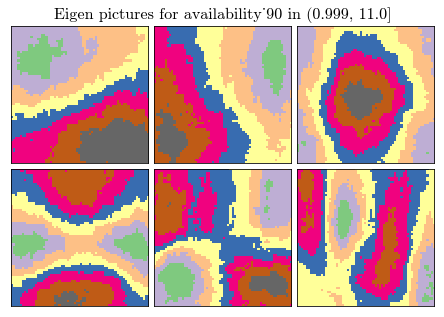

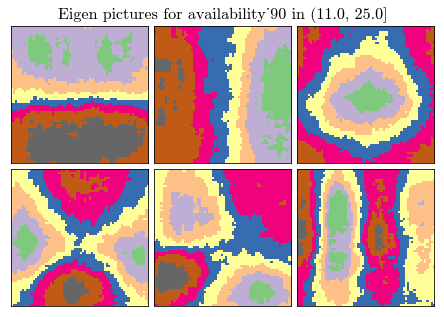

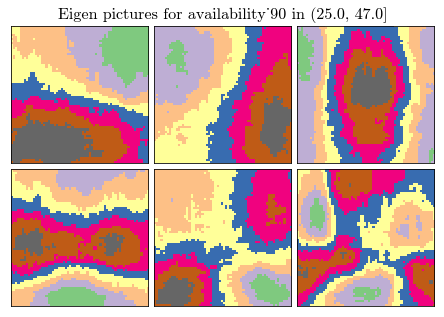

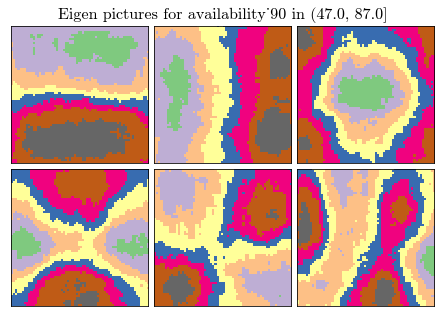

In [8]:
groupy_pictures= df_pictures.groupby('availability_quartile')

for name,group in groupy_pictures:
    prepare_pictures_pca(group,name)


## PCA on greyscale

35.9697459149


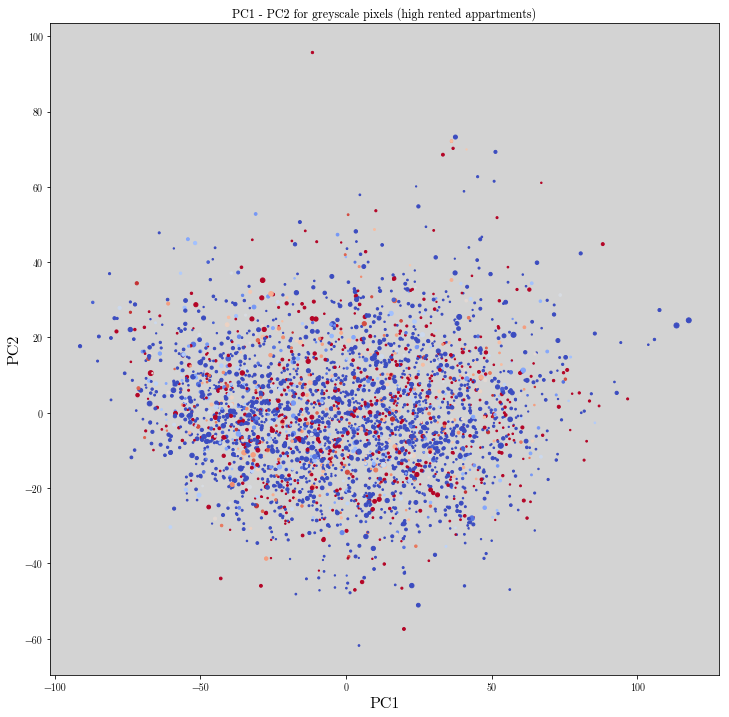

In [31]:
pca = PCA(n_components=50)
fig, plot = plt.subplots()
plot.set_facecolor('lightgrey')

X_train = scale(df_pictures[cols].values)
y_train = df_pictures['availability_90'].values
z_train = df_pictures['reviews_per_month']*3


X_transformed = pca.fit_transform(X_train)

print pca.explained_variance_ratio_[:2].sum()*100


colors = plt.cm.coolwarm(scale(y_train))


plot.scatter(X_transformed[:, 0], X_transformed[:, 1], c=colors,s=z_train,alpha=1)

plot.set_ylabel('PC2', size=16, fontname='CMU Serif')
plot.set_xlabel('PC1', size=16, fontname='CMU Serif')
plot.set_title('PC1 - PC2 for greyscale pixels (high rented appartments)', size=12, **hfont)
for tick in plot.get_xticklabels():
    tick.set_fontname("CMU Serif")
    tick.set_fontsize(10)
for tick in plot.get_yticklabels():
    tick.set_fontname("CMU Serif")
    tick.set_fontsize(10)

df_pictures['PC_1'] = X_transformed[:, 0]
df_pictures['PC_2'] = X_transformed[:, 2]

## Colors Rainbows

In [10]:
df_colors_cluster=pd.read_csv('data/df_colours_clusters.csv')
df_colors_cluster=pd.merge(df_colors_cluster,df_listing_high_renter[['id','review_scores_rating','reviews_per_month','availability_90','price']],left_on='listing_id',right_on='id')

In [11]:
df_colors_cluster['availability_quartile'] = pd.qcut(df_colors_cluster.availability_90,10)
df_colors_cluster['reviews_per_month_quartile'] = pd.qcut(df_colors_cluster.reviews_per_month,10)

In [12]:
def get_clusters_colors(df,availability_90, higher=True,n_clusters=10):
    
    
    X_colors_centroids = df[['Centroid_R_1','Centroid_G_1','Centroid_B_1']].values
    clt = KMeans(n_clusters = n_clusters)
    clt.fit(X_colors_centroids)
    list_col=[]

    for i in range(0,clt.cluster_centers_.shape[0]):
        arr_col = clt.cluster_centers_[i]/255
        
        list_col.append((arr_col.tolist()))
        
    list_col.sort()
    return list_col

(0.999, 5.0]
(5.0, 9.0]
(9.0, 14.0]
(14.0, 19.0]
(19.0, 25.0]
(25.0, 32.0]
(32.0, 41.0]
(41.0, 53.0]
(53.0, 67.0]
(67.0, 87.0]


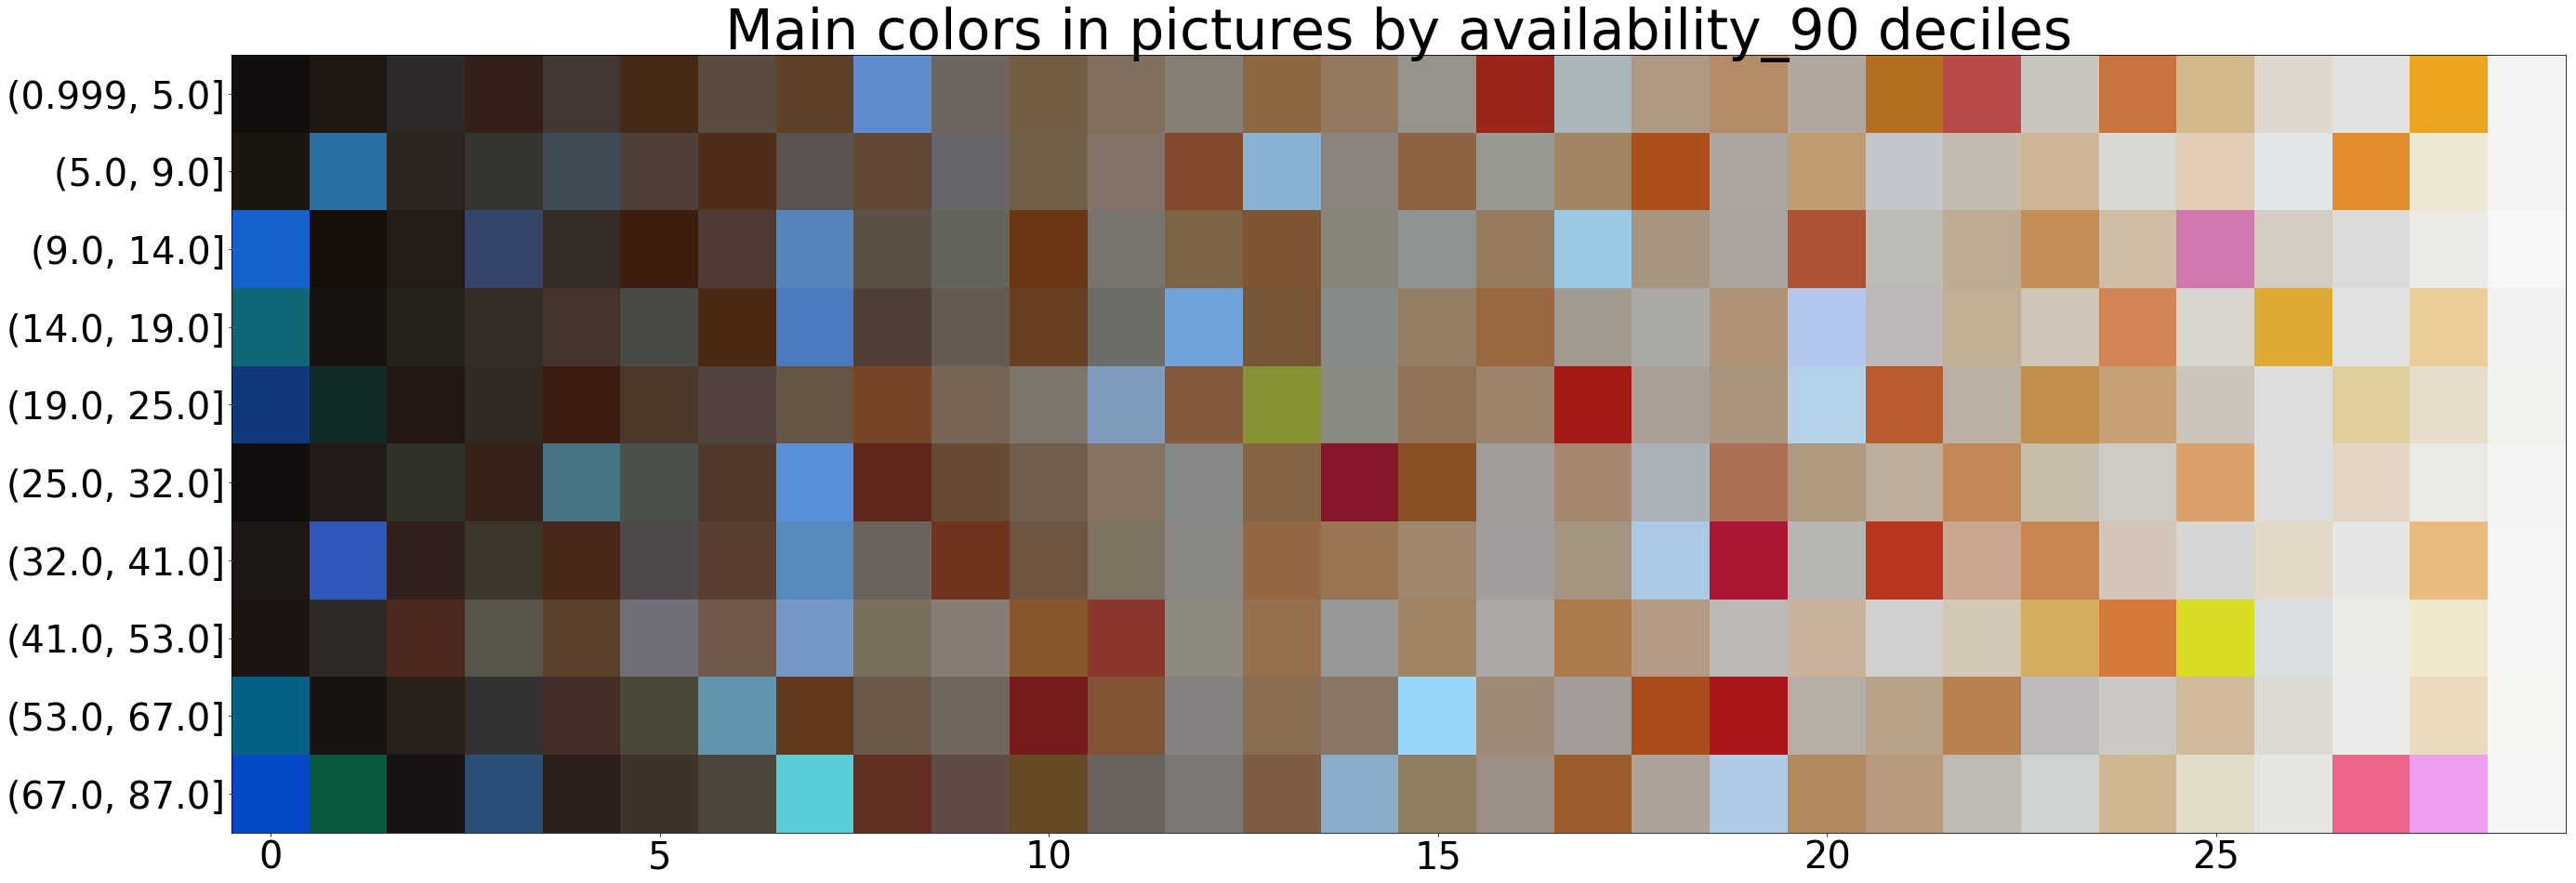

In [13]:
groupy_colors_clusters = df_colors_cluster.groupby('availability_quartile')

list_all_colors_clusters = []
for name,group in groupy_colors_clusters:
    print name
    list_all_colors_clusters.append(get_clusters_colors(group, 10,False,n_clusters=30))  
    
fig_size = plt.rcParams["figure.figsize"]
 
plt.figure(figsize=(45,30))

plt.yticks(range(0,11),[str(quantile_name) for quantile_name, _  in groupy_colors_clusters])
plt.tick_params(axis='both', which='major', labelsize=40)

plt.title('Main colors in pictures by availability_90 deciles', fontsize=60)
plt.imshow([c for c in list_all_colors_clusters])

In [14]:
df_colors_cluster.corr()[['review_scores_rating','availability_90']].sort_values(by='availability_90')

,review_scores_rating,availability_90
review_scores_rating,1.000000,-0.125836
reviews_per_month,-0.059182,-0.023410
Centroid_B_4,0.017235,-0.019328
Centroid_G_4,0.010054,-0.018775
Centroid_R_2,-0.017758,-0.018096
Centroid_G_2,-0.013181,-0.015922
Centroid_R_1,-0.030640,-0.015524
Centroid_R_4,0.001515,-0.014687
Centroid_G_3,0.037052,-0.012645
Centroid_B_3,0.036678,-0.012475


In [15]:
cols_int = [col for col in df_colors_cluster.columns if 'Centroid' in col]
cols_int = [col for col in cols_int if 'hex' not in col]

pca = PCA(n_components=6)

X_train = scale(df_colors_cluster[cols_int].values)
y_train = df_colors_cluster['availability_90'].values
z_train = df_colors_cluster['reviews_per_month']*5

X_transformed = pca.fit_transform(X_train)
print pca.explained_variance_ratio_.sum()*100



78.5824933114


In [16]:
df_pca = pd.DataFrame({'PC1':X_transformed[:, 0],'PC2': X_transformed[:, 1], 'availability_90':(y_train),'reviews_per_month':z_train})

In [17]:
df_pca.reviews_per_month=df_pca.reviews_per_month.astype(int)
df_pca.availability_90=df_pca.availability_90.astype(int)

airBColor= '#ff5a5f'
airBColor2='#008489'

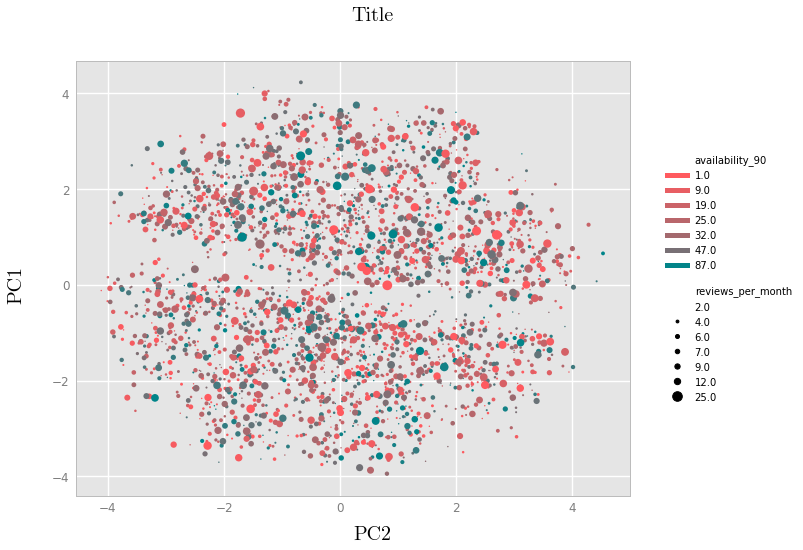

<ggplot: (8774138171241)>

In [46]:
ggplot(df_pca,aes(x='PC1',y='PC2',color='availability_90',size='reviews_per_month'))+geom_point()+scale_color_gradient(low = airBColor, high =airBColor2)+\
ggtitle('PCA for colors clusters')+ theme(plot_title = element_text(size=20, text='Title',family="CMU Serif"), \
        axis_title_y = element_text(size=20, text='PC1',family="CMU Serif"), \
        axis_title_x = element_text(size=20, text='PC2',family="CMU Serif"))

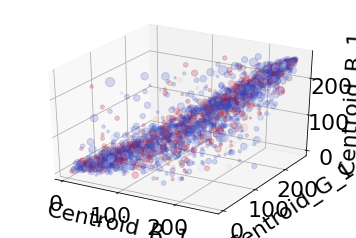

In [19]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

n = 100
rcParams['figure.figsize'] = 12, 12
# For each set of style and range settings, plot n random points in the box
# defined by x in [23, 32], y in [0, 100], z in [zlow, zhigh].

colors = plt.cm.coolwarm(scale(df_colors_cluster['availability_90']))

xs = df_colors_cluster['Centroid_R_1']
ys = df_colors_cluster['Centroid_G_1']
zs = df_colors_cluster['Centroid_B_1']
ax.scatter(xs, ys, zs,c=colors,alpha=.2,s=df_colors_cluster['reviews_per_month']*10)


ax.set_xlabel('Centroid_R_1')
ax.set_ylabel('Centroid_G_1')
ax.set_zlabel('Centroid_B_1')



plt.show()


In [20]:
import matplotlib.font_manager
[f.name for f in matplotlib.font_manager.fontManager.ttflist]

[u'CMU Bright',
 u'STIXNonUnicode',
 u'DejaVu Sans',
 u'DejaVu Serif',
 u'CMU Serif Extra',
 u'CMU Typewriter Text Variable Width',
 u'STIXSizeThreeSym',
 u'DejaVu Sans Mono',
 u'CMU Sans Serif',
 u'DejaVu Sans',
 u'CMU Typewriter Text',
 u'CMU Sans Serif',
 u'CMU Bright',
 u'CMU Typewriter Text',
 u'CMU Typewriter Text',
 u'cmtt10',
 u'STIXSizeFourSym',
 u'CMU Bright',
 u'CMU Bright',
 u'DejaVu Sans',
 u'DejaVu Sans Mono',
 u'cmmi10',
 u'DejaVu Sans Mono',
 u'CMU Concrete',
 u'STIXSizeThreeSym',
 u'CMU Sans Serif Demi Condensed',
 u'STIXNonUnicode',
 u'STIXGeneral',
 u'CMU Typewriter Text',
 u'STIXGeneral',
 u'DejaVu Serif',
 u'cmsy10',
 u'STIXSizeOneSym',
 u'DejaVu Serif',
 u'CMU Serif Extra',
 u'CMU Typewriter Text',
 u'CMU Classical Serif',
 u'STIXSizeFiveSym',
 u'STIXGeneral',
 u'STIXSizeTwoSym',
 u'CMU Concrete',
 u'CMU Sans Serif',
 u'CMU Serif',
 u'DejaVu Serif',
 u'CMU Typewriter Text',
 u'STIXSizeTwoSym',
 u'STIXNonUnicode',
 u'CMU Bright',
 u'DejaVu Sans',
 u'CMU Concrete',
